# Imports & Global Constants

In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb
import timm
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.amp import autocast, GradScaler

# visualization
import matplotlib.pyplot as plt

/data/ephemeral/home/pybum/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/train/DCM"
LABEL_ROOT = "../data/train/outputs_json"

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [4]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [5]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [6]:
BATCH_SIZE = 1
LR = 1e-5
RANDOM_SEED = 21
GRAD_ACCUM = 1

NUM_EPOCHS = 150
VAL_EVERY = 2

SAVED_DIR = "checkpoints"

if not os.path.exists(SAVED_DIR):                                                           
    os.makedirs(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [7]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [8]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [9]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [10]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [11]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [12]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [13]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5,shuffle=True, random_state=RANDOM_SEED)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        # image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            result = self.transforms(image=image, mask=label)
            image, label = result["image"], result["mask"]
        # to tenser will be done later
        # image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        # label = label.transpose(2, 0, 1)
        label = label.float()
        # image = torch.from_numpy(image).float()
        # label = torch.from_numpy(label).float()
            
        return image, label

# Check Data Sample

In [14]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

# Augmentataion

In [15]:
# tf = A.Resize(640,640)
IMAGE_SIZE = 2048
train_tf = A.Compose([
    # A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    A.CropNonEmptyMaskIfExists(height=int(IMAGE_SIZE* 0.8), width=int(IMAGE_SIZE* 0.8),p=0.35),
    # A.RandomResizedCrop(height=IMAGE_SIZE,width=IMAGE_SIZE,scale=(0.8, 1.2),ratio=(1.0,1.0),p=0.4),
    A.CLAHE(clip_limit=1.0, p=0.3),
    # A.ElasticTransform(alpha=30,sigma=6,border_mode=cv2.BORDER_CONSTANT,value=0,mask_value=0,approximate=False,p=0.3), 
    # A.RandomBrightnessContrast(brightness_limit=0.08,contrast_limit=0.2,p=0.4,),
    A.Normalize(mean=(0.485, 0.456, 0.406),std =(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True),
])

valid_tf = A.Compose([
    # A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    # A.CLAHE(clip_limit=2.0, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406),std =(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True),
])

In [16]:
train_dataset = XRayDataset(is_train=True, transforms=train_tf)
valid_dataset = XRayDataset(is_train=False, transforms=valid_tf)

# Setup Dataloader

In [17]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers=4,
    drop_last=True,
    num_workers=2,         
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=1,
)


valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

# Define Functions for Training

In [18]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [19]:
def save_model(model, file_name='models_best.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [20]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [21]:
def validation(epoch, model, data_loader, criterion, thr=0.5, use_amp=True):
    print(f'Start validation #{epoch:2d}')
    model.eval()
    # model = model.cuda()

    dices = []
    with torch.no_grad():
        total_loss = 0.0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()
            
            # outputs = model(images)['out']
            with autocast(device_type="cuda", enabled=use_amp):
                outputs = model(pixel_values=images).logits
                # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion(outputs, masks)
                
            total_loss += loss.item()
            cnt += 1

            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach()
            masks = masks.detach()

            dice = dice_coef(outputs, masks)
            dices.append(dice.cpu())

    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    
    dice_str = "\n".join([f"{c:<12}: {d.item():.4f}" for c, d in zip(CLASSES, dices_per_class)])
    print(dice_str)

    avg_dice = torch.mean(dices_per_class).item()
    avg_val_loss = total_loss / max(cnt, 1)  

    return avg_dice, avg_val_loss, dices_per_class.detach().cpu()


In [22]:
def train(model, data_loader, val_loader, criterion, optimizer, scheduler, accum_steps=4, use_amp=True):
    print(f'Start training..')

    best_dice = 0.0
    model = model.cuda()

    scaler = GradScaler(enabled=use_amp)

    wandb.init(
        project="segmentation",
        name=f"{model.__class__.__name__}",
        config={
            "batch_size": BATCH_SIZE,
            "num_epochs": NUM_EPOCHS,
            "val_every": VAL_EVERY,
            "thr": 0.5,
            "optimizer": optimizer.__class__.__name__,
            "lr": optimizer.param_groups[0].get("lr", None),
            "criterion": criterion.__class__.__name__,
            "model": model.__class__.__name__,
            "accum_steps": accum_steps,
            "use_amp": use_amp,
        }
    )

    global_step = 0

    for epoch in range(NUM_EPOCHS):
        model.train()

        pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", dynamic_ncols=True)

        optimizer.zero_grad(set_to_none=True)

        running_loss = 0.0
        running_count = 0

        for step, (images, masks) in enumerate(pbar):
            images, masks = images.cuda(), masks.cuda()

            #amp적용
            with autocast(device_type="cuda", enabled=use_amp):
                outputs = model(pixel_values=images).logits
                # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion(outputs, masks)

            running_loss += loss.item()
            running_count += 1
            
            # 이번 스텝이 업데이트 시점인지/에폭 마지막인지 판단
            is_update = ((step + 1) % accum_steps == 0)
            is_last = ((step + 1) == len(data_loader))


            # AMP + grad accumulation
            scaler.scale(loss / accum_steps).backward()

            # 업데이트 시점 또는 마지막 남은 배치에서 step
            if is_update or is_last:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

                global_step += 1
                current_lr = optimizer.param_groups[0]["lr"]

                # accum 구간 평균 loss 로깅
                avg_loss = running_loss / running_count
                wandb.log(
                    {"train/loss": avg_loss, "train/lr": current_lr, "epoch": epoch + 1},
                    step=global_step
                )

                pbar.set_postfix(loss=f"{avg_loss:.4f}")

                running_loss = 0.0
                running_count = 0
            else:
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            if (step + 1) % 25 == 0:
                tqdm.write(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(data_loader)}], '
                    f'Loss: {round(loss.item(), 4)}'
                )

        # scheduler.step()
        pbar.close()

        if (epoch + 1) % VAL_EVERY == 0:
            log_dict = {}
            dice, val_loss, dices_pc = validation(epoch + 1, model, val_loader, criterion, use_amp=use_amp)

            wandb.log(
                {"val/loss": val_loss, "val/dice": dice, "epoch": epoch + 1},
                step=global_step
            )

            for c, d in zip(CLASSES, dices_pc):
                log_dict[f"val/dice/{c}"] = float(d)
            wandb.log(log_dict)

            if best_dice < dice:
                tqdm.write(f"Best performance at epoch {epoch+1}: {best_dice:.4f} -> {dice:.4f}")
                tqdm.write(f"val_loss: {val_loss:.4f}")
                best_dice = dice
                save_model(model, file_name='swinupernet_best.pt')

    wandb.finish()


# Losses

In [23]:
# single
# ABeDice안에서 dice를 사용하기 때문에 dice안에서는 sigmoid(pred)하면 안됨
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()  
    
    intersection = (pred * target).sum(dim=(2,3))
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth)))

    return loss.mean()

## p, pred, erc를 만들면서 vram많이 차지함 -> pred로 덮어쓰기 
# def ABeDice(pred, target, alpha=1, beta=1, smooth=1e-5):
#     pred= pred.contiguous()
#     target= target.contiguous()
#     pred = torch.sigmoid(pred)
    
#     t =1.0 
#     for _ in range(beta):
#         t = 1- pred**t
#     pred = pred ** (alpha * t)
    
#     return dice_loss(pred, target, smooth)
    
def ABeDice(pred, target, alpha=1, beta=1, smooth=1e-5):
    pred= pred.contiguous()
    target= target.contiguous()
    pred = torch.sigmoid(pred)
    
    t =1.0 
    for _ in range(beta):
        t = 1- pred**t
    pred = pred ** (alpha * t)
    
    intersection = (pred * target).sum(dim=(2, 3))
    p_sum = (pred**2).sum(dim=(2, 3))
    t_sum = (target**2).sum(dim=(2, 3)) 
    
    loss = 1 - ((2. * intersection + smooth) / (p_sum + t_sum + smooth))
    return loss.mean()

wrist_indices = [
    CLASSES.index("finger-1"),
    CLASSES.index("finger-17"),
    CLASSES.index("Trapezium"),
    CLASSES.index("Trapezoid"),
    CLASSES.index("Capitate"),
    CLASSES.index("Hamate"),
    CLASSES.index("Scaphoid"),
    CLASSES.index("Lunate"),
    CLASSES.index("Triquetrum"),
    CLASSES.index("Pisiform"),
]

def focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, smooth=1e-6, class_idx=None):
    pred= torch.sigmoid(pred).contiguous()
    target= target.contiguous()

    if class_idx is not None:
        pred= pred[:, class_idx, ...]
        target= target[:, class_idx, ...]
    
    dims = (2, 3)
    tp = (pred * target).sum(dim=dims)
    fp = (pred * (1 - target)).sum(dim=dims)
    fn = ((1 - pred) * target).sum(dim=dims)

    tversky= (tp+smooth) / (tp + alpha * fp + beta * fn+ smooth)
    loss= torch.pow((1-tversky), gamma)
    return loss.mean()

# multi 
def bce_dice(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    loss = bce* bce_weight + dice* (1 - bce_weight)
    return loss

def bce_abedice(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    abe = ABeDice(pred, target, alpha=1, beta=1)
    loss = bce* bce_weight + abe * (1 - bce_weight)
    return loss
    
def bce_ftversky(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    focal_tversky = focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=None)
    loss = bce * bce_weight + focal_tversky * (1 - bce_weight)
    return loss
    
def ABeDice_ftversky(pred, target, wrist_idx=wrist_indices, lam=2):
    base = ABeDice(pred,target, alpha=1, beta=1)
    wrist = focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=wrist_idx)
    return base + lam * wrist
    
def bce_ABeDice_ftversky(pred, target, wrist_idx=wrist_indices,bce_weight=0.33, ABe_weight=0.33, ft_weight=0.33):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    ABe = ABeDice(pred, target, alpha=1, beta=1)
    ft= focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=wrist_idx)
    loss = bce* bce_weight + ABe * ABe_weight + ft * ft_weight
    return loss
    
def bce_Dice_ftversky(pred, target, wrist_idx=wrist_indices,bce_weight=0.4, Dice_weight=0.4, ft_weight=0.2):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    ft= focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=wrist_idx)
    pred = torch.sigmoid(pred)
    Dice = dice_loss(pred, target)
    
    loss = bce* bce_weight + Dice * Dice_weight + ft * ft_weight

    return loss

# Training

In [24]:
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

NUM_CLASSES = 29  

model = UperNetForSemanticSegmentation.from_pretrained(
    "openmmlab/upernet-swin-base",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True, 
)

def replace_bn_with_gn(module, num_groups=32):
    for name, child in module.named_children():
        if isinstance(child, torch.nn.BatchNorm2d):
            setattr(
                module,
                name,
                torch.nn.GroupNorm(
                    num_groups=num_groups,
                    num_channels=child.num_features
                )
            )
        else:
            replace_bn_with_gn(child, num_groups)

replace_bn_with_gn(model)
model = model.cuda()

Some weights of UperNetForSemanticSegmentation were not initialized from the model checkpoint at openmmlab/upernet-swin-base and are newly initialized because the shapes did not match:
- auxiliary_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([29]) in the model instantiated
- auxiliary_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([29, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([29]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 512, 1, 1]) in the checkpoint and torch.Size([29, 512, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Loss function을 정의합니다.
# criterion = nn.BCEWithLogitsLoss()
# criterion = bce_dice
# criterion = ABeDice

# criterion = ABeDice_ftversky
criterion = bce_Dice_ftversky

# criterion = bce_abedice

# criterion = bce_ftversky


# Optimizer를 정의합니다.
optimizer = optim.AdamW(params=model.parameters(), lr=LR, weight_decay=5e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=NUM_EPOCHS,eta_min=3e-5)



In [26]:
# 시드를 설정합니다.
set_seed()

In [27]:
train(model, train_loader, valid_loader, criterion, optimizer, scheduler, GRAD_ACCUM, use_amp=True)

Start training..


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch 1/150:   0%|                                                                              | 0/640 [00:00…

2026-01-04 16:33:44 | Epoch [1/150], Step [25/640], Loss: 0.7561
2026-01-04 16:34:16 | Epoch [1/150], Step [50/640], Loss: 0.7262
2026-01-04 16:34:48 | Epoch [1/150], Step [75/640], Loss: 0.7105
2026-01-04 16:35:21 | Epoch [1/150], Step [100/640], Loss: 0.7044
2026-01-04 16:35:56 | Epoch [1/150], Step [125/640], Loss: 0.6978
2026-01-04 16:36:28 | Epoch [1/150], Step [150/640], Loss: 0.6935
2026-01-04 16:37:01 | Epoch [1/150], Step [175/640], Loss: 0.6879
2026-01-04 16:37:34 | Epoch [1/150], Step [200/640], Loss: 0.6828
2026-01-04 16:38:07 | Epoch [1/150], Step [225/640], Loss: 0.6801
2026-01-04 16:38:40 | Epoch [1/150], Step [250/640], Loss: 0.6755
2026-01-04 16:39:12 | Epoch [1/150], Step [275/640], Loss: 0.6708
2026-01-04 16:39:46 | Epoch [1/150], Step [300/640], Loss: 0.6661
2026-01-04 16:40:18 | Epoch [1/150], Step [325/640], Loss: 0.6638
2026-01-04 16:40:51 | Epoch [1/150], Step [350/640], Loss: 0.657
2026-01-04 16:41:22 | Epoch [1/150], Step [375/640], Loss: 0.6528
2026-01-04 16:

Epoch 2/150:   0%|                                                                              | 0/640 [00:00…

2026-01-04 16:47:46 | Epoch [2/150], Step [25/640], Loss: 0.5886
2026-01-04 16:48:19 | Epoch [2/150], Step [50/640], Loss: 0.5888
2026-01-04 16:48:52 | Epoch [2/150], Step [75/640], Loss: 0.5848
2026-01-04 16:49:25 | Epoch [2/150], Step [100/640], Loss: 0.5856
2026-01-04 16:49:57 | Epoch [2/150], Step [125/640], Loss: 0.5816
2026-01-04 16:50:30 | Epoch [2/150], Step [150/640], Loss: 0.5769
2026-01-04 16:51:03 | Epoch [2/150], Step [175/640], Loss: 0.5557
2026-01-04 16:51:36 | Epoch [2/150], Step [200/640], Loss: 0.5674
2026-01-04 16:52:09 | Epoch [2/150], Step [225/640], Loss: 0.5614
2026-01-04 16:52:40 | Epoch [2/150], Step [250/640], Loss: 0.5586
2026-01-04 16:53:13 | Epoch [2/150], Step [275/640], Loss: 0.5529
2026-01-04 16:53:46 | Epoch [2/150], Step [300/640], Loss: 0.5543
2026-01-04 16:54:19 | Epoch [2/150], Step [325/640], Loss: 0.5532
2026-01-04 16:54:50 | Epoch [2/150], Step [350/640], Loss: 0.5437
2026-01-04 16:55:22 | Epoch [2/150], Step [375/640], Loss: 0.5181
2026-01-04 16

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.1761
finger-2    : 0.1153
finger-3    : 0.5095
finger-4    : 0.0034
finger-5    : 0.0135
finger-6    : 0.2569
finger-7    : 0.3735
finger-8    : 0.0040
finger-9    : 0.0111
finger-10   : 0.2080
finger-11   : 0.3317
finger-12   : 0.0042
finger-13   : 0.0093
finger-14   : 0.1725
finger-15   : 0.3685
finger-16   : 0.0038
finger-17   : 0.0535
finger-18   : 0.0989
finger-19   : 0.3367
Trapezium   : 0.4027
Trapezoid   : 0.0780
Capitate    : 0.5990
Hamate      : 0.2790
Scaphoid    : 0.3449
Lunate      : 0.1364
Triquetrum  : 0.0665
Pisiform    : 0.0346
Radius      : 0.5481
Ulna        : 0.4572
Best performance at epoch 2: 0.0000 -> 0.2068
val_loss: 0.4807


Epoch 3/150:   0%|                                                                              | 0/640 [00:00…

2026-01-04 17:03:35 | Epoch [3/150], Step [25/640], Loss: 0.4572
2026-01-04 17:04:08 | Epoch [3/150], Step [50/640], Loss: 0.439
2026-01-04 17:04:41 | Epoch [3/150], Step [75/640], Loss: 0.4729
2026-01-04 17:05:14 | Epoch [3/150], Step [100/640], Loss: 0.4383
2026-01-04 17:05:48 | Epoch [3/150], Step [125/640], Loss: 0.4625
2026-01-04 17:06:19 | Epoch [3/150], Step [150/640], Loss: 0.412
2026-01-04 17:06:51 | Epoch [3/150], Step [175/640], Loss: 0.4156
2026-01-04 17:07:24 | Epoch [3/150], Step [200/640], Loss: 0.3862
2026-01-04 17:07:58 | Epoch [3/150], Step [225/640], Loss: 0.4228
2026-01-04 17:08:31 | Epoch [3/150], Step [250/640], Loss: 0.4066
2026-01-04 17:09:04 | Epoch [3/150], Step [275/640], Loss: 0.3913
2026-01-04 17:09:37 | Epoch [3/150], Step [300/640], Loss: 0.386
2026-01-04 17:10:09 | Epoch [3/150], Step [325/640], Loss: 0.3377
2026-01-04 17:10:42 | Epoch [3/150], Step [350/640], Loss: 0.3607
2026-01-04 17:11:15 | Epoch [3/150], Step [375/640], Loss: 0.3754
2026-01-04 17:11

Epoch 4/150:   0%|                                                                              | 0/640 [00:00…

2026-01-04 17:17:41 | Epoch [4/150], Step [25/640], Loss: 0.2907
2026-01-04 17:18:12 | Epoch [4/150], Step [50/640], Loss: 0.2775
2026-01-04 17:18:44 | Epoch [4/150], Step [75/640], Loss: 0.2705
2026-01-04 17:19:17 | Epoch [4/150], Step [100/640], Loss: 0.2602
2026-01-04 17:19:48 | Epoch [4/150], Step [125/640], Loss: 0.2468
2026-01-04 17:20:22 | Epoch [4/150], Step [150/640], Loss: 0.2334
2026-01-04 17:20:54 | Epoch [4/150], Step [175/640], Loss: 0.2185
2026-01-04 17:21:27 | Epoch [4/150], Step [200/640], Loss: 0.2618
2026-01-04 17:22:00 | Epoch [4/150], Step [225/640], Loss: 0.243
2026-01-04 17:22:33 | Epoch [4/150], Step [250/640], Loss: 0.2301
2026-01-04 17:23:06 | Epoch [4/150], Step [275/640], Loss: 0.2346
2026-01-04 17:23:37 | Epoch [4/150], Step [300/640], Loss: 0.2113
2026-01-04 17:24:10 | Epoch [4/150], Step [325/640], Loss: 0.2185
2026-01-04 17:24:44 | Epoch [4/150], Step [350/640], Loss: 0.2141
2026-01-04 17:25:16 | Epoch [4/150], Step [375/640], Loss: 0.1931
2026-01-04 17:

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.8204
finger-2    : 0.7511
finger-3    : 0.8596
finger-4    : 0.0048
finger-5    : 0.6627
finger-6    : 0.8161
finger-7    : 0.8097
finger-8    : 0.0079
finger-9    : 0.5632
finger-10   : 0.7959
finger-11   : 0.8082
finger-12   : 0.0054
finger-13   : 0.4651
finger-14   : 0.7826
finger-15   : 0.8235
finger-16   : 0.0044
finger-17   : 0.7823
finger-18   : 0.7569
finger-19   : 0.8401
Trapezium   : 0.8188
Trapezoid   : 0.7221
Capitate    : 0.8512
Hamate      : 0.8019
Scaphoid    : 0.8339
Lunate      : 0.8082
Triquetrum  : 0.7289
Pisiform    : 0.6393
Radius      : 0.8452
Ulna        : 0.8433
Best performance at epoch 4: 0.2068 -> 0.6639
val_loss: 0.1670


Epoch 5/150:   0%|                                                                              | 0/640 [00:00…

2026-01-04 17:33:33 | Epoch [5/150], Step [25/640], Loss: 0.1537
2026-01-04 17:34:03 | Epoch [5/150], Step [50/640], Loss: 0.1491
2026-01-04 17:34:37 | Epoch [5/150], Step [75/640], Loss: 0.1498
2026-01-04 17:35:09 | Epoch [5/150], Step [100/640], Loss: 0.1547
2026-01-04 17:35:42 | Epoch [5/150], Step [125/640], Loss: 0.1572
2026-01-04 17:36:13 | Epoch [5/150], Step [150/640], Loss: 0.1486
2026-01-04 17:36:46 | Epoch [5/150], Step [175/640], Loss: 0.1507
2026-01-04 17:37:19 | Epoch [5/150], Step [200/640], Loss: 0.1402
2026-01-04 17:37:51 | Epoch [5/150], Step [225/640], Loss: 0.1363
2026-01-04 17:38:24 | Epoch [5/150], Step [250/640], Loss: 0.1456
2026-01-04 17:38:57 | Epoch [5/150], Step [275/640], Loss: 0.1355
2026-01-04 17:39:29 | Epoch [5/150], Step [300/640], Loss: 0.1366
2026-01-04 17:40:02 | Epoch [5/150], Step [325/640], Loss: 0.1234
2026-01-04 17:40:35 | Epoch [5/150], Step [350/640], Loss: 0.1304
2026-01-04 17:41:06 | Epoch [5/150], Step [375/640], Loss: 0.1385
2026-01-04 17

Epoch 6/150:   0%|                                                                              | 0/640 [00:00…

2026-01-04 17:47:28 | Epoch [6/150], Step [25/640], Loss: 0.0994
2026-01-04 17:48:01 | Epoch [6/150], Step [50/640], Loss: 0.0918
2026-01-04 17:48:34 | Epoch [6/150], Step [75/640], Loss: 0.0795
2026-01-04 17:49:07 | Epoch [6/150], Step [100/640], Loss: 0.0783
2026-01-04 17:49:41 | Epoch [6/150], Step [125/640], Loss: 0.0783
2026-01-04 17:50:14 | Epoch [6/150], Step [150/640], Loss: 0.0796
2026-01-04 17:50:47 | Epoch [6/150], Step [175/640], Loss: 0.0866
2026-01-04 17:51:19 | Epoch [6/150], Step [200/640], Loss: 0.0766
2026-01-04 17:51:52 | Epoch [6/150], Step [225/640], Loss: 0.0736
2026-01-04 17:52:24 | Epoch [6/150], Step [250/640], Loss: 0.0651
2026-01-04 17:52:56 | Epoch [6/150], Step [275/640], Loss: 0.0691
2026-01-04 17:53:28 | Epoch [6/150], Step [300/640], Loss: 0.0707
2026-01-04 17:53:59 | Epoch [6/150], Step [325/640], Loss: 0.0894
2026-01-04 17:54:33 | Epoch [6/150], Step [350/640], Loss: 0.0722
2026-01-04 17:55:06 | Epoch [6/150], Step [375/640], Loss: 0.0639
2026-01-04 17

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9146
finger-2    : 0.9142
finger-3    : 0.9314
finger-4    : 0.8168
finger-5    : 0.9033
finger-6    : 0.9322
finger-7    : 0.9200
finger-8    : 0.8462
finger-9    : 0.9034
finger-10   : 0.9259
finger-11   : 0.9089
finger-12   : 0.8210
finger-13   : 0.8903
finger-14   : 0.9227
finger-15   : 0.9165
finger-16   : 0.8128
finger-17   : 0.9151
finger-18   : 0.9187
finger-19   : 0.9252
Trapezium   : 0.8929
Trapezoid   : 0.8518
Capitate    : 0.9128
Hamate      : 0.8925
Scaphoid    : 0.9134
Lunate      : 0.8988
Triquetrum  : 0.8842
Pisiform    : 0.8245
Radius      : 0.9220
Ulna        : 0.9339
Best performance at epoch 6: 0.6639 -> 0.8954
val_loss: 0.0555


Epoch 7/150:   0%|                                                                              | 0/640 [00:00…

2026-01-04 18:03:21 | Epoch [7/150], Step [25/640], Loss: 0.0558
2026-01-04 18:03:52 | Epoch [7/150], Step [50/640], Loss: 0.0797
2026-01-04 18:04:24 | Epoch [7/150], Step [75/640], Loss: 0.0728
2026-01-04 18:04:57 | Epoch [7/150], Step [100/640], Loss: 0.0489
2026-01-04 18:05:29 | Epoch [7/150], Step [125/640], Loss: 0.0747
2026-01-04 18:06:02 | Epoch [7/150], Step [150/640], Loss: 0.0512
2026-01-04 18:06:35 | Epoch [7/150], Step [175/640], Loss: 0.048
2026-01-04 18:07:08 | Epoch [7/150], Step [200/640], Loss: 0.0452
2026-01-04 18:07:40 | Epoch [7/150], Step [225/640], Loss: 0.0665
2026-01-04 18:08:12 | Epoch [7/150], Step [250/640], Loss: 0.0426
2026-01-04 18:08:45 | Epoch [7/150], Step [275/640], Loss: 0.0602
2026-01-04 18:09:19 | Epoch [7/150], Step [300/640], Loss: 0.0438
2026-01-04 18:09:52 | Epoch [7/150], Step [325/640], Loss: 0.0429
2026-01-04 18:10:24 | Epoch [7/150], Step [350/640], Loss: 0.072
2026-01-04 18:10:55 | Epoch [7/150], Step [375/640], Loss: 0.052
2026-01-04 18:11

Epoch 8/150:   0%|                                                                              | 0/640 [00:00…

2026-01-04 18:17:15 | Epoch [8/150], Step [25/640], Loss: 0.0411
2026-01-04 18:17:48 | Epoch [8/150], Step [50/640], Loss: 0.0493
2026-01-04 18:18:21 | Epoch [8/150], Step [75/640], Loss: 0.0389
2026-01-04 18:18:52 | Epoch [8/150], Step [100/640], Loss: 0.0386
2026-01-04 18:19:25 | Epoch [8/150], Step [125/640], Loss: 0.0367
2026-01-04 18:19:58 | Epoch [8/150], Step [150/640], Loss: 0.0375
2026-01-04 18:20:31 | Epoch [8/150], Step [175/640], Loss: 0.0481
2026-01-04 18:21:04 | Epoch [8/150], Step [200/640], Loss: 0.0353
2026-01-04 18:21:35 | Epoch [8/150], Step [225/640], Loss: 0.038
2026-01-04 18:22:10 | Epoch [8/150], Step [250/640], Loss: 0.0367
2026-01-04 18:22:41 | Epoch [8/150], Step [275/640], Loss: 0.0294
2026-01-04 18:23:13 | Epoch [8/150], Step [300/640], Loss: 0.0377
2026-01-04 18:23:47 | Epoch [8/150], Step [325/640], Loss: 0.0287
2026-01-04 18:24:18 | Epoch [8/150], Step [350/640], Loss: 0.0397
2026-01-04 18:24:52 | Epoch [8/150], Step [375/640], Loss: 0.0304
2026-01-04 18:

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9391
finger-2    : 0.9525
finger-3    : 0.9564
finger-4    : 0.9324
finger-5    : 0.9475
finger-6    : 0.9603
finger-7    : 0.9536
finger-8    : 0.9376
finger-9    : 0.9499
finger-10   : 0.9588
finger-11   : 0.9451
finger-12   : 0.9302
finger-13   : 0.9458
finger-14   : 0.9554
finger-15   : 0.9485
finger-16   : 0.9220
finger-17   : 0.9431
finger-18   : 0.9535
finger-19   : 0.9561
Trapezium   : 0.9189
Trapezoid   : 0.8840
Capitate    : 0.9332
Hamate      : 0.9191
Scaphoid    : 0.9414
Lunate      : 0.9283
Triquetrum  : 0.9186
Pisiform    : 0.8747
Radius      : 0.9548
Ulna        : 0.9596
Best performance at epoch 8: 0.8954 -> 0.9386
val_loss: 0.0340


Epoch 9/150:   0%|                                                                              | 0/640 [00:00…

2026-01-04 18:33:07 | Epoch [9/150], Step [25/640], Loss: 0.0271
2026-01-04 18:33:39 | Epoch [9/150], Step [50/640], Loss: 0.0312
2026-01-04 18:34:11 | Epoch [9/150], Step [75/640], Loss: 0.0277
2026-01-04 18:34:43 | Epoch [9/150], Step [100/640], Loss: 0.0439
2026-01-04 18:35:16 | Epoch [9/150], Step [125/640], Loss: 0.0303
2026-01-04 18:35:47 | Epoch [9/150], Step [150/640], Loss: 0.0723
2026-01-04 18:36:20 | Epoch [9/150], Step [175/640], Loss: 0.0284
2026-01-04 18:36:53 | Epoch [9/150], Step [200/640], Loss: 0.0426
2026-01-04 18:37:25 | Epoch [9/150], Step [225/640], Loss: 0.0291
2026-01-04 18:37:58 | Epoch [9/150], Step [250/640], Loss: 0.0301
2026-01-04 18:38:30 | Epoch [9/150], Step [275/640], Loss: 0.0462
2026-01-04 18:39:04 | Epoch [9/150], Step [300/640], Loss: 0.0296
2026-01-04 18:39:36 | Epoch [9/150], Step [325/640], Loss: 0.0297
2026-01-04 18:40:09 | Epoch [9/150], Step [350/640], Loss: 0.0382
2026-01-04 18:40:42 | Epoch [9/150], Step [375/640], Loss: 0.0267
2026-01-04 18

Epoch 10/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 18:47:05 | Epoch [10/150], Step [25/640], Loss: 0.0514
2026-01-04 18:47:37 | Epoch [10/150], Step [50/640], Loss: 0.0278
2026-01-04 18:48:08 | Epoch [10/150], Step [75/640], Loss: 0.0371
2026-01-04 18:48:41 | Epoch [10/150], Step [100/640], Loss: 0.0239
2026-01-04 18:49:13 | Epoch [10/150], Step [125/640], Loss: 0.0238
2026-01-04 18:49:47 | Epoch [10/150], Step [150/640], Loss: 0.038
2026-01-04 18:50:20 | Epoch [10/150], Step [175/640], Loss: 0.0254
2026-01-04 18:50:52 | Epoch [10/150], Step [200/640], Loss: 0.0288
2026-01-04 18:51:24 | Epoch [10/150], Step [225/640], Loss: 0.036
2026-01-04 18:51:57 | Epoch [10/150], Step [250/640], Loss: 0.0213
2026-01-04 18:52:29 | Epoch [10/150], Step [275/640], Loss: 0.0218
2026-01-04 18:53:02 | Epoch [10/150], Step [300/640], Loss: 0.022
2026-01-04 18:53:34 | Epoch [10/150], Step [325/640], Loss: 0.0263
2026-01-04 18:54:08 | Epoch [10/150], Step [350/640], Loss: 0.022
2026-01-04 18:54:41 | Epoch [10/150], Step [375/640], Loss: 0.0262
20

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9485
finger-2    : 0.9658
finger-3    : 0.9651
finger-4    : 0.9546
finger-5    : 0.9610
finger-6    : 0.9719
finger-7    : 0.9657
finger-8    : 0.9598
finger-9    : 0.9650
finger-10   : 0.9718
finger-11   : 0.9598
finger-12   : 0.9530
finger-13   : 0.9611
finger-14   : 0.9694
finger-15   : 0.9603
finger-16   : 0.9467
finger-17   : 0.9554
finger-18   : 0.9669
finger-19   : 0.9665
Trapezium   : 0.9284
Trapezoid   : 0.8930
Capitate    : 0.9439
Hamate      : 0.9300
Scaphoid    : 0.9513
Lunate      : 0.9398
Triquetrum  : 0.9324
Pisiform    : 0.8860
Radius      : 0.9670
Ulna        : 0.9687
Best performance at epoch 10: 0.9386 -> 0.9520
val_loss: 0.0273


Epoch 11/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 19:03:00 | Epoch [11/150], Step [25/640], Loss: 0.029
2026-01-04 19:03:33 | Epoch [11/150], Step [50/640], Loss: 0.0257
2026-01-04 19:04:05 | Epoch [11/150], Step [75/640], Loss: 0.0241
2026-01-04 19:04:38 | Epoch [11/150], Step [100/640], Loss: 0.0215
2026-01-04 19:05:10 | Epoch [11/150], Step [125/640], Loss: 0.022
2026-01-04 19:05:43 | Epoch [11/150], Step [150/640], Loss: 0.0264
2026-01-04 19:06:16 | Epoch [11/150], Step [175/640], Loss: 0.0248
2026-01-04 19:06:48 | Epoch [11/150], Step [200/640], Loss: 0.0227
2026-01-04 19:07:21 | Epoch [11/150], Step [225/640], Loss: 0.0216
2026-01-04 19:07:55 | Epoch [11/150], Step [250/640], Loss: 0.0241
2026-01-04 19:08:27 | Epoch [11/150], Step [275/640], Loss: 0.0226
2026-01-04 19:08:59 | Epoch [11/150], Step [300/640], Loss: 0.0217
2026-01-04 19:09:31 | Epoch [11/150], Step [325/640], Loss: 0.0222
2026-01-04 19:10:03 | Epoch [11/150], Step [350/640], Loss: 0.0279
2026-01-04 19:10:35 | Epoch [11/150], Step [375/640], Loss: 0.0491


Epoch 12/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 19:17:00 | Epoch [12/150], Step [25/640], Loss: 0.028
2026-01-04 19:17:33 | Epoch [12/150], Step [50/640], Loss: 0.0224
2026-01-04 19:18:06 | Epoch [12/150], Step [75/640], Loss: 0.0177
2026-01-04 19:18:39 | Epoch [12/150], Step [100/640], Loss: 0.0188
2026-01-04 19:19:12 | Epoch [12/150], Step [125/640], Loss: 0.0295
2026-01-04 19:19:43 | Epoch [12/150], Step [150/640], Loss: 0.0352
2026-01-04 19:20:16 | Epoch [12/150], Step [175/640], Loss: 0.0227
2026-01-04 19:20:49 | Epoch [12/150], Step [200/640], Loss: 0.02
2026-01-04 19:21:22 | Epoch [12/150], Step [225/640], Loss: 0.0216
2026-01-04 19:21:54 | Epoch [12/150], Step [250/640], Loss: 0.0221
2026-01-04 19:22:26 | Epoch [12/150], Step [275/640], Loss: 0.0217
2026-01-04 19:22:59 | Epoch [12/150], Step [300/640], Loss: 0.0235
2026-01-04 19:23:31 | Epoch [12/150], Step [325/640], Loss: 0.0182
2026-01-04 19:24:04 | Epoch [12/150], Step [350/640], Loss: 0.0198
2026-01-04 19:24:37 | Epoch [12/150], Step [375/640], Loss: 0.0211
2

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9526
finger-2    : 0.9714
finger-3    : 0.9708
finger-4    : 0.9635
finger-5    : 0.9668
finger-6    : 0.9778
finger-7    : 0.9729
finger-8    : 0.9671
finger-9    : 0.9713
finger-10   : 0.9783
finger-11   : 0.9668
finger-12   : 0.9613
finger-13   : 0.9683
finger-14   : 0.9764
finger-15   : 0.9677
finger-16   : 0.9531
finger-17   : 0.9591
finger-18   : 0.9737
finger-19   : 0.9738
Trapezium   : 0.9332
Trapezoid   : 0.8996
Capitate    : 0.9485
Hamate      : 0.9365
Scaphoid    : 0.9568
Lunate      : 0.9438
Triquetrum  : 0.9394
Pisiform    : 0.8965
Radius      : 0.9725
Ulna        : 0.9732
Best performance at epoch 12: 0.9520 -> 0.9584
val_loss: 0.0240


Epoch 13/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 19:32:54 | Epoch [13/150], Step [25/640], Loss: 0.0212
2026-01-04 19:33:27 | Epoch [13/150], Step [50/640], Loss: 0.0529
2026-01-04 19:33:59 | Epoch [13/150], Step [75/640], Loss: 0.083
2026-01-04 19:34:32 | Epoch [13/150], Step [100/640], Loss: 0.0353
2026-01-04 19:35:06 | Epoch [13/150], Step [125/640], Loss: 0.0178
2026-01-04 19:35:37 | Epoch [13/150], Step [150/640], Loss: 0.0207
2026-01-04 19:36:10 | Epoch [13/150], Step [175/640], Loss: 0.0208
2026-01-04 19:36:43 | Epoch [13/150], Step [200/640], Loss: 0.0229
2026-01-04 19:37:14 | Epoch [13/150], Step [225/640], Loss: 0.0247
2026-01-04 19:37:46 | Epoch [13/150], Step [250/640], Loss: 0.0224
2026-01-04 19:38:18 | Epoch [13/150], Step [275/640], Loss: 0.0439
2026-01-04 19:38:50 | Epoch [13/150], Step [300/640], Loss: 0.0254
2026-01-04 19:39:23 | Epoch [13/150], Step [325/640], Loss: 0.0191
2026-01-04 19:39:55 | Epoch [13/150], Step [350/640], Loss: 0.0204
2026-01-04 19:40:28 | Epoch [13/150], Step [375/640], Loss: 0.016


Epoch 14/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 19:46:56 | Epoch [14/150], Step [25/640], Loss: 0.0183
2026-01-04 19:47:30 | Epoch [14/150], Step [50/640], Loss: 0.0224
2026-01-04 19:48:03 | Epoch [14/150], Step [75/640], Loss: 0.0196
2026-01-04 19:48:36 | Epoch [14/150], Step [100/640], Loss: 0.0198
2026-01-04 19:49:09 | Epoch [14/150], Step [125/640], Loss: 0.0187
2026-01-04 19:49:40 | Epoch [14/150], Step [150/640], Loss: 0.0578
2026-01-04 19:50:14 | Epoch [14/150], Step [175/640], Loss: 0.0202
2026-01-04 19:50:46 | Epoch [14/150], Step [200/640], Loss: 0.0162
2026-01-04 19:51:17 | Epoch [14/150], Step [225/640], Loss: 0.0664
2026-01-04 19:51:51 | Epoch [14/150], Step [250/640], Loss: 0.017
2026-01-04 19:52:23 | Epoch [14/150], Step [275/640], Loss: 0.0171
2026-01-04 19:52:57 | Epoch [14/150], Step [300/640], Loss: 0.0219
2026-01-04 19:53:31 | Epoch [14/150], Step [325/640], Loss: 0.0221
2026-01-04 19:54:02 | Epoch [14/150], Step [350/640], Loss: 0.1156
2026-01-04 19:54:34 | Epoch [14/150], Step [375/640], Loss: 0.0217

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9543
finger-2    : 0.9749
finger-3    : 0.9736
finger-4    : 0.9671
finger-5    : 0.9704
finger-6    : 0.9807
finger-7    : 0.9759
finger-8    : 0.9717
finger-9    : 0.9736
finger-10   : 0.9808
finger-11   : 0.9702
finger-12   : 0.9662
finger-13   : 0.9723
finger-14   : 0.9783
finger-15   : 0.9707
finger-16   : 0.9619
finger-17   : 0.9628
finger-18   : 0.9750
finger-19   : 0.9765
Trapezium   : 0.9337
Trapezoid   : 0.9038
Capitate    : 0.9506
Hamate      : 0.9389
Scaphoid    : 0.9601
Lunate      : 0.9494
Triquetrum  : 0.9429
Pisiform    : 0.9008
Radius      : 0.9762
Ulna        : 0.9767
Best performance at epoch 14: 0.9584 -> 0.9617
val_loss: 0.0223


Epoch 15/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 20:02:56 | Epoch [15/150], Step [25/640], Loss: 0.0225
2026-01-04 20:03:29 | Epoch [15/150], Step [50/640], Loss: 0.0379
2026-01-04 20:04:02 | Epoch [15/150], Step [75/640], Loss: 0.0325
2026-01-04 20:04:34 | Epoch [15/150], Step [100/640], Loss: 0.0232
2026-01-04 20:05:07 | Epoch [15/150], Step [125/640], Loss: 0.0137
2026-01-04 20:05:40 | Epoch [15/150], Step [150/640], Loss: 0.016
2026-01-04 20:06:13 | Epoch [15/150], Step [175/640], Loss: 0.0189
2026-01-04 20:06:46 | Epoch [15/150], Step [200/640], Loss: 0.0189
2026-01-04 20:07:19 | Epoch [15/150], Step [225/640], Loss: 0.0169
2026-01-04 20:07:51 | Epoch [15/150], Step [250/640], Loss: 0.0176
2026-01-04 20:08:23 | Epoch [15/150], Step [275/640], Loss: 0.0205
2026-01-04 20:08:58 | Epoch [15/150], Step [300/640], Loss: 0.0203
2026-01-04 20:09:31 | Epoch [15/150], Step [325/640], Loss: 0.0156
2026-01-04 20:10:03 | Epoch [15/150], Step [350/640], Loss: 0.0155
2026-01-04 20:10:36 | Epoch [15/150], Step [375/640], Loss: 0.0195

Epoch 16/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 20:16:59 | Epoch [16/150], Step [25/640], Loss: 0.0201
2026-01-04 20:17:32 | Epoch [16/150], Step [50/640], Loss: 0.0151
2026-01-04 20:18:04 | Epoch [16/150], Step [75/640], Loss: 0.0171
2026-01-04 20:18:37 | Epoch [16/150], Step [100/640], Loss: 0.0137
2026-01-04 20:19:10 | Epoch [16/150], Step [125/640], Loss: 0.0156
2026-01-04 20:19:42 | Epoch [16/150], Step [150/640], Loss: 0.0228
2026-01-04 20:20:16 | Epoch [16/150], Step [175/640], Loss: 0.0142
2026-01-04 20:20:50 | Epoch [16/150], Step [200/640], Loss: 0.0158
2026-01-04 20:21:23 | Epoch [16/150], Step [225/640], Loss: 0.0163
2026-01-04 20:21:56 | Epoch [16/150], Step [250/640], Loss: 0.0466
2026-01-04 20:22:28 | Epoch [16/150], Step [275/640], Loss: 0.0539
2026-01-04 20:23:02 | Epoch [16/150], Step [300/640], Loss: 0.0172
2026-01-04 20:23:34 | Epoch [16/150], Step [325/640], Loss: 0.0178
2026-01-04 20:24:07 | Epoch [16/150], Step [350/640], Loss: 0.0161
2026-01-04 20:24:39 | Epoch [16/150], Step [375/640], Loss: 0.018

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9565
finger-2    : 0.9771
finger-3    : 0.9744
finger-4    : 0.9712
finger-5    : 0.9725
finger-6    : 0.9823
finger-7    : 0.9783
finger-8    : 0.9750
finger-9    : 0.9761
finger-10   : 0.9825
finger-11   : 0.9717
finger-12   : 0.9691
finger-13   : 0.9744
finger-14   : 0.9813
finger-15   : 0.9729
finger-16   : 0.9639
finger-17   : 0.9653
finger-18   : 0.9784
finger-19   : 0.9786
Trapezium   : 0.9338
Trapezoid   : 0.9044
Capitate    : 0.9534
Hamate      : 0.9396
Scaphoid    : 0.9621
Lunate      : 0.9493
Triquetrum  : 0.9444
Pisiform    : 0.9005
Radius      : 0.9782
Ulna        : 0.9778
Best performance at epoch 16: 0.9617 -> 0.9636
val_loss: 0.0214


Epoch 17/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 20:32:54 | Epoch [17/150], Step [25/640], Loss: 0.0418
2026-01-04 20:33:27 | Epoch [17/150], Step [50/640], Loss: 0.0153
2026-01-04 20:33:59 | Epoch [17/150], Step [75/640], Loss: 0.0211
2026-01-04 20:34:33 | Epoch [17/150], Step [100/640], Loss: 0.0143
2026-01-04 20:35:04 | Epoch [17/150], Step [125/640], Loss: 0.0216
2026-01-04 20:35:36 | Epoch [17/150], Step [150/640], Loss: 0.0396
2026-01-04 20:36:10 | Epoch [17/150], Step [175/640], Loss: 0.0171
2026-01-04 20:36:42 | Epoch [17/150], Step [200/640], Loss: 0.0205
2026-01-04 20:37:16 | Epoch [17/150], Step [225/640], Loss: 0.0137
2026-01-04 20:37:49 | Epoch [17/150], Step [250/640], Loss: 0.0362
2026-01-04 20:38:21 | Epoch [17/150], Step [275/640], Loss: 0.0247
2026-01-04 20:38:56 | Epoch [17/150], Step [300/640], Loss: 0.0178
2026-01-04 20:39:29 | Epoch [17/150], Step [325/640], Loss: 0.0128
2026-01-04 20:40:01 | Epoch [17/150], Step [350/640], Loss: 0.0187
2026-01-04 20:40:33 | Epoch [17/150], Step [375/640], Loss: 0.013

Epoch 18/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 20:46:56 | Epoch [18/150], Step [25/640], Loss: 0.0158
2026-01-04 20:47:28 | Epoch [18/150], Step [50/640], Loss: 0.0168
2026-01-04 20:48:01 | Epoch [18/150], Step [75/640], Loss: 0.0205
2026-01-04 20:48:33 | Epoch [18/150], Step [100/640], Loss: 0.0154
2026-01-04 20:49:07 | Epoch [18/150], Step [125/640], Loss: 0.016
2026-01-04 20:49:40 | Epoch [18/150], Step [150/640], Loss: 0.0217
2026-01-04 20:50:13 | Epoch [18/150], Step [175/640], Loss: 0.0171
2026-01-04 20:50:45 | Epoch [18/150], Step [200/640], Loss: 0.0473
2026-01-04 20:51:17 | Epoch [18/150], Step [225/640], Loss: 0.0195
2026-01-04 20:51:51 | Epoch [18/150], Step [250/640], Loss: 0.0272
2026-01-04 20:52:24 | Epoch [18/150], Step [275/640], Loss: 0.0165
2026-01-04 20:52:58 | Epoch [18/150], Step [300/640], Loss: 0.0173
2026-01-04 20:53:30 | Epoch [18/150], Step [325/640], Loss: 0.0178
2026-01-04 20:54:03 | Epoch [18/150], Step [350/640], Loss: 0.0141
2026-01-04 20:54:37 | Epoch [18/150], Step [375/640], Loss: 0.0136

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9570
finger-2    : 0.9775
finger-3    : 0.9744
finger-4    : 0.9700
finger-5    : 0.9730
finger-6    : 0.9825
finger-7    : 0.9786
finger-8    : 0.9746
finger-9    : 0.9765
finger-10   : 0.9830
finger-11   : 0.9715
finger-12   : 0.9670
finger-13   : 0.9748
finger-14   : 0.9822
finger-15   : 0.9728
finger-16   : 0.9607
finger-17   : 0.9664
finger-18   : 0.9779
finger-19   : 0.9769
Trapezium   : 0.9388
Trapezoid   : 0.9069
Capitate    : 0.9492
Hamate      : 0.9420
Scaphoid    : 0.9613
Lunate      : 0.9499
Triquetrum  : 0.9440
Pisiform    : 0.8908
Radius      : 0.9780
Ulna        : 0.9776


Epoch 19/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 21:02:55 | Epoch [19/150], Step [25/640], Loss: 0.0191
2026-01-04 21:03:28 | Epoch [19/150], Step [50/640], Loss: 0.0193
2026-01-04 21:04:01 | Epoch [19/150], Step [75/640], Loss: 0.0225
2026-01-04 21:04:35 | Epoch [19/150], Step [100/640], Loss: 0.0206
2026-01-04 21:05:07 | Epoch [19/150], Step [125/640], Loss: 0.015
2026-01-04 21:05:40 | Epoch [19/150], Step [150/640], Loss: 0.0179
2026-01-04 21:06:13 | Epoch [19/150], Step [175/640], Loss: 0.0176
2026-01-04 21:06:45 | Epoch [19/150], Step [200/640], Loss: 0.0116
2026-01-04 21:07:18 | Epoch [19/150], Step [225/640], Loss: 0.0172
2026-01-04 21:07:51 | Epoch [19/150], Step [250/640], Loss: 0.0128
2026-01-04 21:08:24 | Epoch [19/150], Step [275/640], Loss: 0.0343
2026-01-04 21:08:57 | Epoch [19/150], Step [300/640], Loss: 0.0125
2026-01-04 21:09:30 | Epoch [19/150], Step [325/640], Loss: 0.0141
2026-01-04 21:10:02 | Epoch [19/150], Step [350/640], Loss: 0.0123
2026-01-04 21:10:35 | Epoch [19/150], Step [375/640], Loss: 0.018


Epoch 20/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 21:17:04 | Epoch [20/150], Step [25/640], Loss: 0.0145
2026-01-04 21:17:38 | Epoch [20/150], Step [50/640], Loss: 0.0148
2026-01-04 21:18:11 | Epoch [20/150], Step [75/640], Loss: 0.0163
2026-01-04 21:18:45 | Epoch [20/150], Step [100/640], Loss: 0.018
2026-01-04 21:19:18 | Epoch [20/150], Step [125/640], Loss: 0.0125
2026-01-04 21:19:51 | Epoch [20/150], Step [150/640], Loss: 0.0196
2026-01-04 21:20:24 | Epoch [20/150], Step [175/640], Loss: 0.0156
2026-01-04 21:20:57 | Epoch [20/150], Step [200/640], Loss: 0.0188
2026-01-04 21:21:32 | Epoch [20/150], Step [225/640], Loss: 0.0124
2026-01-04 21:22:04 | Epoch [20/150], Step [250/640], Loss: 0.0175
2026-01-04 21:22:36 | Epoch [20/150], Step [275/640], Loss: 0.0129
2026-01-04 21:23:09 | Epoch [20/150], Step [300/640], Loss: 0.0162
2026-01-04 21:23:42 | Epoch [20/150], Step [325/640], Loss: 0.0173
2026-01-04 21:24:14 | Epoch [20/150], Step [350/640], Loss: 0.0203
2026-01-04 21:24:48 | Epoch [20/150], Step [375/640], Loss: 0.0292

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9585
finger-2    : 0.9797
finger-3    : 0.9768
finger-4    : 0.9732
finger-5    : 0.9746
finger-6    : 0.9843
finger-7    : 0.9808
finger-8    : 0.9765
finger-9    : 0.9785
finger-10   : 0.9854
finger-11   : 0.9743
finger-12   : 0.9722
finger-13   : 0.9763
finger-14   : 0.9836
finger-15   : 0.9761
finger-16   : 0.9670
finger-17   : 0.9674
finger-18   : 0.9808
finger-19   : 0.9814
Trapezium   : 0.9404
Trapezoid   : 0.9071
Capitate    : 0.9562
Hamate      : 0.9426
Scaphoid    : 0.9642
Lunate      : 0.9525
Triquetrum  : 0.9473
Pisiform    : 0.8975
Radius      : 0.9800
Ulna        : 0.9796
Best performance at epoch 20: 0.9636 -> 0.9660
val_loss: 0.0202


Epoch 21/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 21:33:10 | Epoch [21/150], Step [25/640], Loss: 0.0146
2026-01-04 21:33:42 | Epoch [21/150], Step [50/640], Loss: 0.0205
2026-01-04 21:34:17 | Epoch [21/150], Step [75/640], Loss: 0.0135
2026-01-04 21:34:50 | Epoch [21/150], Step [100/640], Loss: 0.0146
2026-01-04 21:35:25 | Epoch [21/150], Step [125/640], Loss: 0.0151
2026-01-04 21:35:58 | Epoch [21/150], Step [150/640], Loss: 0.0173
2026-01-04 21:36:30 | Epoch [21/150], Step [175/640], Loss: 0.0201
2026-01-04 21:37:03 | Epoch [21/150], Step [200/640], Loss: 0.0189
2026-01-04 21:37:36 | Epoch [21/150], Step [225/640], Loss: 0.0139
2026-01-04 21:38:08 | Epoch [21/150], Step [250/640], Loss: 0.0169
2026-01-04 21:38:41 | Epoch [21/150], Step [275/640], Loss: 0.0149
2026-01-04 21:39:13 | Epoch [21/150], Step [300/640], Loss: 0.0185
2026-01-04 21:39:47 | Epoch [21/150], Step [325/640], Loss: 0.0136
2026-01-04 21:40:19 | Epoch [21/150], Step [350/640], Loss: 0.0119
2026-01-04 21:40:51 | Epoch [21/150], Step [375/640], Loss: 0.012

Epoch 22/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 21:47:18 | Epoch [22/150], Step [25/640], Loss: 0.018
2026-01-04 21:47:52 | Epoch [22/150], Step [50/640], Loss: 0.0165
2026-01-04 21:48:26 | Epoch [22/150], Step [75/640], Loss: 0.0153
2026-01-04 21:48:59 | Epoch [22/150], Step [100/640], Loss: 0.0274
2026-01-04 21:49:32 | Epoch [22/150], Step [125/640], Loss: 0.0152
2026-01-04 21:50:05 | Epoch [22/150], Step [150/640], Loss: 0.0189
2026-01-04 21:50:38 | Epoch [22/150], Step [175/640], Loss: 0.0124
2026-01-04 21:51:12 | Epoch [22/150], Step [200/640], Loss: 0.0137
2026-01-04 21:51:45 | Epoch [22/150], Step [225/640], Loss: 0.0249
2026-01-04 21:52:17 | Epoch [22/150], Step [250/640], Loss: 0.0177
2026-01-04 21:52:49 | Epoch [22/150], Step [275/640], Loss: 0.0412
2026-01-04 21:53:21 | Epoch [22/150], Step [300/640], Loss: 0.0235
2026-01-04 21:53:53 | Epoch [22/150], Step [325/640], Loss: 0.0126
2026-01-04 21:54:27 | Epoch [22/150], Step [350/640], Loss: 0.0241
2026-01-04 21:55:00 | Epoch [22/150], Step [375/640], Loss: 0.0124

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9596
finger-2    : 0.9806
finger-3    : 0.9778
finger-4    : 0.9742
finger-5    : 0.9752
finger-6    : 0.9851
finger-7    : 0.9819
finger-8    : 0.9774
finger-9    : 0.9789
finger-10   : 0.9862
finger-11   : 0.9753
finger-12   : 0.9732
finger-13   : 0.9773
finger-14   : 0.9847
finger-15   : 0.9771
finger-16   : 0.9683
finger-17   : 0.9682
finger-18   : 0.9818
finger-19   : 0.9821
Trapezium   : 0.9416
Trapezoid   : 0.9079
Capitate    : 0.9562
Hamate      : 0.9445
Scaphoid    : 0.9643
Lunate      : 0.9506
Triquetrum  : 0.9482
Pisiform    : 0.9069
Radius      : 0.9810
Ulna        : 0.9808
Best performance at epoch 22: 0.9660 -> 0.9671
val_loss: 0.0196


Epoch 23/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 22:03:21 | Epoch [23/150], Step [25/640], Loss: 0.0215
2026-01-04 22:03:54 | Epoch [23/150], Step [50/640], Loss: 0.0191
2026-01-04 22:04:26 | Epoch [23/150], Step [75/640], Loss: 0.0156
2026-01-04 22:05:00 | Epoch [23/150], Step [100/640], Loss: 0.0167
2026-01-04 22:05:32 | Epoch [23/150], Step [125/640], Loss: 0.0163
2026-01-04 22:06:04 | Epoch [23/150], Step [150/640], Loss: 0.0154
2026-01-04 22:06:37 | Epoch [23/150], Step [175/640], Loss: 0.0189
2026-01-04 22:07:08 | Epoch [23/150], Step [200/640], Loss: 0.0176
2026-01-04 22:07:41 | Epoch [23/150], Step [225/640], Loss: 0.0127
2026-01-04 22:08:14 | Epoch [23/150], Step [250/640], Loss: 0.0127
2026-01-04 22:08:46 | Epoch [23/150], Step [275/640], Loss: 0.0143
2026-01-04 22:09:18 | Epoch [23/150], Step [300/640], Loss: 0.0206
2026-01-04 22:09:50 | Epoch [23/150], Step [325/640], Loss: 0.0152
2026-01-04 22:10:23 | Epoch [23/150], Step [350/640], Loss: 0.0247
2026-01-04 22:10:56 | Epoch [23/150], Step [375/640], Loss: 0.014

Epoch 24/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 22:17:20 | Epoch [24/150], Step [25/640], Loss: 0.0154
2026-01-04 22:17:53 | Epoch [24/150], Step [50/640], Loss: 0.0139
2026-01-04 22:18:26 | Epoch [24/150], Step [75/640], Loss: 0.0128
2026-01-04 22:18:59 | Epoch [24/150], Step [100/640], Loss: 0.0116
2026-01-04 22:19:31 | Epoch [24/150], Step [125/640], Loss: 0.0115
2026-01-04 22:20:04 | Epoch [24/150], Step [150/640], Loss: 0.0112
2026-01-04 22:20:37 | Epoch [24/150], Step [175/640], Loss: 0.0118
2026-01-04 22:21:09 | Epoch [24/150], Step [200/640], Loss: 0.0143
2026-01-04 22:21:41 | Epoch [24/150], Step [225/640], Loss: 0.0199
2026-01-04 22:22:14 | Epoch [24/150], Step [250/640], Loss: 0.0205
2026-01-04 22:22:46 | Epoch [24/150], Step [275/640], Loss: 0.0137
2026-01-04 22:23:18 | Epoch [24/150], Step [300/640], Loss: 0.0166
2026-01-04 22:23:51 | Epoch [24/150], Step [325/640], Loss: 0.0172
2026-01-04 22:24:24 | Epoch [24/150], Step [350/640], Loss: 0.0186
2026-01-04 22:24:57 | Epoch [24/150], Step [375/640], Loss: 0.011

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9587
finger-2    : 0.9807
finger-3    : 0.9780
finger-4    : 0.9741
finger-5    : 0.9755
finger-6    : 0.9851
finger-7    : 0.9819
finger-8    : 0.9770
finger-9    : 0.9789
finger-10   : 0.9860
finger-11   : 0.9751
finger-12   : 0.9733
finger-13   : 0.9772
finger-14   : 0.9843
finger-15   : 0.9764
finger-16   : 0.9678
finger-17   : 0.9687
finger-18   : 0.9814
finger-19   : 0.9814
Trapezium   : 0.9402
Trapezoid   : 0.9082
Capitate    : 0.9581
Hamate      : 0.9443
Scaphoid    : 0.9654
Lunate      : 0.9527
Triquetrum  : 0.9486
Pisiform    : 0.9064
Radius      : 0.9811
Ulna        : 0.9809
Best performance at epoch 24: 0.9671 -> 0.9671
val_loss: 0.0196


Epoch 25/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 22:33:05 | Epoch [25/150], Step [25/640], Loss: 0.0118
2026-01-04 22:33:37 | Epoch [25/150], Step [50/640], Loss: 0.0225
2026-01-04 22:34:10 | Epoch [25/150], Step [75/640], Loss: 0.0149
2026-01-04 22:34:41 | Epoch [25/150], Step [100/640], Loss: 0.0149
2026-01-04 22:35:14 | Epoch [25/150], Step [125/640], Loss: 0.0126
2026-01-04 22:35:47 | Epoch [25/150], Step [150/640], Loss: 0.0165
2026-01-04 22:36:21 | Epoch [25/150], Step [175/640], Loss: 0.0148
2026-01-04 22:36:54 | Epoch [25/150], Step [200/640], Loss: 0.016
2026-01-04 22:37:27 | Epoch [25/150], Step [225/640], Loss: 0.0151
2026-01-04 22:38:00 | Epoch [25/150], Step [250/640], Loss: 0.0131
2026-01-04 22:38:32 | Epoch [25/150], Step [275/640], Loss: 0.0128
2026-01-04 22:39:04 | Epoch [25/150], Step [300/640], Loss: 0.0173
2026-01-04 22:39:38 | Epoch [25/150], Step [325/640], Loss: 0.0141
2026-01-04 22:40:11 | Epoch [25/150], Step [350/640], Loss: 0.0124
2026-01-04 22:40:43 | Epoch [25/150], Step [375/640], Loss: 0.0135

Epoch 26/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 22:47:07 | Epoch [26/150], Step [25/640], Loss: 0.012
2026-01-04 22:47:39 | Epoch [26/150], Step [50/640], Loss: 0.0195
2026-01-04 22:48:12 | Epoch [26/150], Step [75/640], Loss: 0.0122
2026-01-04 22:48:46 | Epoch [26/150], Step [100/640], Loss: 0.0126
2026-01-04 22:49:18 | Epoch [26/150], Step [125/640], Loss: 0.0108
2026-01-04 22:49:52 | Epoch [26/150], Step [150/640], Loss: 0.0142
2026-01-04 22:50:25 | Epoch [26/150], Step [175/640], Loss: 0.0108
2026-01-04 22:50:56 | Epoch [26/150], Step [200/640], Loss: 0.0138
2026-01-04 22:51:29 | Epoch [26/150], Step [225/640], Loss: 0.0168
2026-01-04 22:52:03 | Epoch [26/150], Step [250/640], Loss: 0.0152
2026-01-04 22:52:36 | Epoch [26/150], Step [275/640], Loss: 0.0125
2026-01-04 22:53:08 | Epoch [26/150], Step [300/640], Loss: 0.015
2026-01-04 22:53:41 | Epoch [26/150], Step [325/640], Loss: 0.0122
2026-01-04 22:54:13 | Epoch [26/150], Step [350/640], Loss: 0.0104
2026-01-04 22:54:45 | Epoch [26/150], Step [375/640], Loss: 0.0154


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9589
finger-2    : 0.9805
finger-3    : 0.9786
finger-4    : 0.9748
finger-5    : 0.9756
finger-6    : 0.9857
finger-7    : 0.9828
finger-8    : 0.9777
finger-9    : 0.9792
finger-10   : 0.9869
finger-11   : 0.9762
finger-12   : 0.9740
finger-13   : 0.9780
finger-14   : 0.9854
finger-15   : 0.9781
finger-16   : 0.9698
finger-17   : 0.9687
finger-18   : 0.9823
finger-19   : 0.9828
Trapezium   : 0.9416
Trapezoid   : 0.9083
Capitate    : 0.9582
Hamate      : 0.9448
Scaphoid    : 0.9660
Lunate      : 0.9543
Triquetrum  : 0.9494
Pisiform    : 0.9063
Radius      : 0.9814
Ulna        : 0.9815
Best performance at epoch 26: 0.9671 -> 0.9679
val_loss: 0.0193


Epoch 27/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 23:02:59 | Epoch [27/150], Step [25/640], Loss: 0.0171
2026-01-04 23:03:32 | Epoch [27/150], Step [50/640], Loss: 0.0131
2026-01-04 23:04:04 | Epoch [27/150], Step [75/640], Loss: 0.0141
2026-01-04 23:04:37 | Epoch [27/150], Step [100/640], Loss: 0.0139
2026-01-04 23:05:08 | Epoch [27/150], Step [125/640], Loss: 0.0151
2026-01-04 23:05:42 | Epoch [27/150], Step [150/640], Loss: 0.0134
2026-01-04 23:06:14 | Epoch [27/150], Step [175/640], Loss: 0.0148
2026-01-04 23:06:47 | Epoch [27/150], Step [200/640], Loss: 0.0111
2026-01-04 23:07:19 | Epoch [27/150], Step [225/640], Loss: 0.0162
2026-01-04 23:07:50 | Epoch [27/150], Step [250/640], Loss: 0.0139
2026-01-04 23:08:23 | Epoch [27/150], Step [275/640], Loss: 0.0172
2026-01-04 23:08:54 | Epoch [27/150], Step [300/640], Loss: 0.0148
2026-01-04 23:09:28 | Epoch [27/150], Step [325/640], Loss: 0.0279
2026-01-04 23:10:01 | Epoch [27/150], Step [350/640], Loss: 0.0162
2026-01-04 23:10:35 | Epoch [27/150], Step [375/640], Loss: 0.014

Epoch 28/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 23:17:00 | Epoch [28/150], Step [25/640], Loss: 0.0175
2026-01-04 23:17:33 | Epoch [28/150], Step [50/640], Loss: 0.0145
2026-01-04 23:18:07 | Epoch [28/150], Step [75/640], Loss: 0.0156
2026-01-04 23:18:40 | Epoch [28/150], Step [100/640], Loss: 0.0146
2026-01-04 23:19:11 | Epoch [28/150], Step [125/640], Loss: 0.0191
2026-01-04 23:19:43 | Epoch [28/150], Step [150/640], Loss: 0.0205
2026-01-04 23:20:16 | Epoch [28/150], Step [175/640], Loss: 0.0138
2026-01-04 23:20:48 | Epoch [28/150], Step [200/640], Loss: 0.0165
2026-01-04 23:21:21 | Epoch [28/150], Step [225/640], Loss: 0.0232
2026-01-04 23:21:53 | Epoch [28/150], Step [250/640], Loss: 0.0132
2026-01-04 23:22:25 | Epoch [28/150], Step [275/640], Loss: 0.0191
2026-01-04 23:22:58 | Epoch [28/150], Step [300/640], Loss: 0.0131
2026-01-04 23:23:31 | Epoch [28/150], Step [325/640], Loss: 0.0113
2026-01-04 23:24:02 | Epoch [28/150], Step [350/640], Loss: 0.0142
2026-01-04 23:24:35 | Epoch [28/150], Step [375/640], Loss: 0.012

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9596
finger-2    : 0.9809
finger-3    : 0.9784
finger-4    : 0.9736
finger-5    : 0.9759
finger-6    : 0.9850
finger-7    : 0.9825
finger-8    : 0.9776
finger-9    : 0.9798
finger-10   : 0.9870
finger-11   : 0.9760
finger-12   : 0.9737
finger-13   : 0.9780
finger-14   : 0.9846
finger-15   : 0.9778
finger-16   : 0.9693
finger-17   : 0.9699
finger-18   : 0.9816
finger-19   : 0.9817
Trapezium   : 0.9425
Trapezoid   : 0.9070
Capitate    : 0.9574
Hamate      : 0.9425
Scaphoid    : 0.9643
Lunate      : 0.9532
Triquetrum  : 0.9498
Pisiform    : 0.9032
Radius      : 0.9820
Ulna        : 0.9798


Epoch 29/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 23:32:47 | Epoch [29/150], Step [25/640], Loss: 0.0179
2026-01-04 23:33:19 | Epoch [29/150], Step [50/640], Loss: 0.0107
2026-01-04 23:33:51 | Epoch [29/150], Step [75/640], Loss: 0.013
2026-01-04 23:34:24 | Epoch [29/150], Step [100/640], Loss: 0.0104
2026-01-04 23:34:56 | Epoch [29/150], Step [125/640], Loss: 0.0167
2026-01-04 23:35:28 | Epoch [29/150], Step [150/640], Loss: 0.0106
2026-01-04 23:36:01 | Epoch [29/150], Step [175/640], Loss: 0.0241
2026-01-04 23:36:33 | Epoch [29/150], Step [200/640], Loss: 0.0113
2026-01-04 23:37:06 | Epoch [29/150], Step [225/640], Loss: 0.0147
2026-01-04 23:37:38 | Epoch [29/150], Step [250/640], Loss: 0.0136
2026-01-04 23:38:11 | Epoch [29/150], Step [275/640], Loss: 0.0126
2026-01-04 23:38:44 | Epoch [29/150], Step [300/640], Loss: 0.0117
2026-01-04 23:39:16 | Epoch [29/150], Step [325/640], Loss: 0.0167
2026-01-04 23:39:49 | Epoch [29/150], Step [350/640], Loss: 0.0182
2026-01-04 23:40:22 | Epoch [29/150], Step [375/640], Loss: 0.0204

Epoch 30/150:   0%|                                                                             | 0/640 [00:00…

2026-01-04 23:46:45 | Epoch [30/150], Step [25/640], Loss: 0.0172
2026-01-04 23:47:18 | Epoch [30/150], Step [50/640], Loss: 0.0233
2026-01-04 23:47:50 | Epoch [30/150], Step [75/640], Loss: 0.0134
2026-01-04 23:48:24 | Epoch [30/150], Step [100/640], Loss: 0.0124
2026-01-04 23:48:57 | Epoch [30/150], Step [125/640], Loss: 0.0108
2026-01-04 23:49:29 | Epoch [30/150], Step [150/640], Loss: 0.0159
2026-01-04 23:50:01 | Epoch [30/150], Step [175/640], Loss: 0.0167
2026-01-04 23:50:35 | Epoch [30/150], Step [200/640], Loss: 0.011
2026-01-04 23:51:08 | Epoch [30/150], Step [225/640], Loss: 0.012
2026-01-04 23:51:41 | Epoch [30/150], Step [250/640], Loss: 0.0168
2026-01-04 23:52:12 | Epoch [30/150], Step [275/640], Loss: 0.0118
2026-01-04 23:52:45 | Epoch [30/150], Step [300/640], Loss: 0.0122
2026-01-04 23:53:18 | Epoch [30/150], Step [325/640], Loss: 0.0122
2026-01-04 23:53:51 | Epoch [30/150], Step [350/640], Loss: 0.0183
2026-01-04 23:54:24 | Epoch [30/150], Step [375/640], Loss: 0.0151


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9599
finger-2    : 0.9815
finger-3    : 0.9791
finger-4    : 0.9749
finger-5    : 0.9754
finger-6    : 0.9861
finger-7    : 0.9827
finger-8    : 0.9781
finger-9    : 0.9797
finger-10   : 0.9874
finger-11   : 0.9764
finger-12   : 0.9734
finger-13   : 0.9784
finger-14   : 0.9857
finger-15   : 0.9783
finger-16   : 0.9705
finger-17   : 0.9693
finger-18   : 0.9831
finger-19   : 0.9832
Trapezium   : 0.9434
Trapezoid   : 0.9072
Capitate    : 0.9565
Hamate      : 0.9402
Scaphoid    : 0.9631
Lunate      : 0.9550
Triquetrum  : 0.9502
Pisiform    : 0.9077
Radius      : 0.9823
Ulna        : 0.9813
Best performance at epoch 30: 0.9679 -> 0.9679
val_loss: 0.0193


Epoch 31/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 00:02:39 | Epoch [31/150], Step [25/640], Loss: 0.0179
2026-01-05 00:03:11 | Epoch [31/150], Step [50/640], Loss: 0.1178
2026-01-05 00:03:44 | Epoch [31/150], Step [75/640], Loss: 0.0143
2026-01-05 00:04:17 | Epoch [31/150], Step [100/640], Loss: 0.0135
2026-01-05 00:04:47 | Epoch [31/150], Step [125/640], Loss: 0.016
2026-01-05 00:05:21 | Epoch [31/150], Step [150/640], Loss: 0.0128
2026-01-05 00:05:54 | Epoch [31/150], Step [175/640], Loss: 0.0109
2026-01-05 00:06:28 | Epoch [31/150], Step [200/640], Loss: 0.0136
2026-01-05 00:07:00 | Epoch [31/150], Step [225/640], Loss: 0.0115
2026-01-05 00:07:32 | Epoch [31/150], Step [250/640], Loss: 0.013
2026-01-05 00:08:05 | Epoch [31/150], Step [275/640], Loss: 0.012
2026-01-05 00:08:38 | Epoch [31/150], Step [300/640], Loss: 0.0133
2026-01-05 00:09:08 | Epoch [31/150], Step [325/640], Loss: 0.013
2026-01-05 00:09:40 | Epoch [31/150], Step [350/640], Loss: 0.0169
2026-01-05 00:10:13 | Epoch [31/150], Step [375/640], Loss: 0.0152
20

Epoch 32/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 00:16:35 | Epoch [32/150], Step [25/640], Loss: 0.0109
2026-01-05 00:17:08 | Epoch [32/150], Step [50/640], Loss: 0.0117
2026-01-05 00:17:42 | Epoch [32/150], Step [75/640], Loss: 0.0129
2026-01-05 00:18:14 | Epoch [32/150], Step [100/640], Loss: 0.016
2026-01-05 00:18:47 | Epoch [32/150], Step [125/640], Loss: 0.0106
2026-01-05 00:19:20 | Epoch [32/150], Step [150/640], Loss: 0.015
2026-01-05 00:19:53 | Epoch [32/150], Step [175/640], Loss: 0.0152
2026-01-05 00:20:26 | Epoch [32/150], Step [200/640], Loss: 0.0141
2026-01-05 00:20:56 | Epoch [32/150], Step [225/640], Loss: 0.0156
2026-01-05 00:21:29 | Epoch [32/150], Step [250/640], Loss: 0.0137
2026-01-05 00:22:01 | Epoch [32/150], Step [275/640], Loss: 0.0106
2026-01-05 00:22:35 | Epoch [32/150], Step [300/640], Loss: 0.0102
2026-01-05 00:23:07 | Epoch [32/150], Step [325/640], Loss: 0.0098
2026-01-05 00:23:40 | Epoch [32/150], Step [350/640], Loss: 0.0108
2026-01-05 00:24:13 | Epoch [32/150], Step [375/640], Loss: 0.0088


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9584
finger-2    : 0.9812
finger-3    : 0.9793
finger-4    : 0.9753
finger-5    : 0.9764
finger-6    : 0.9862
finger-7    : 0.9830
finger-8    : 0.9785
finger-9    : 0.9801
finger-10   : 0.9875
finger-11   : 0.9765
finger-12   : 0.9748
finger-13   : 0.9788
finger-14   : 0.9861
finger-15   : 0.9788
finger-16   : 0.9710
finger-17   : 0.9703
finger-18   : 0.9833
finger-19   : 0.9838
Trapezium   : 0.9412
Trapezoid   : 0.9088
Capitate    : 0.9587
Hamate      : 0.9444
Scaphoid    : 0.9666
Lunate      : 0.9555
Triquetrum  : 0.9504
Pisiform    : 0.9087
Radius      : 0.9825
Ulna        : 0.9819
Best performance at epoch 32: 0.9679 -> 0.9686
val_loss: 0.0189


Epoch 33/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 00:32:33 | Epoch [33/150], Step [25/640], Loss: 0.0129
2026-01-05 00:33:06 | Epoch [33/150], Step [50/640], Loss: 0.0119
2026-01-05 00:33:39 | Epoch [33/150], Step [75/640], Loss: 0.0125
2026-01-05 00:34:12 | Epoch [33/150], Step [100/640], Loss: 0.0117
2026-01-05 00:34:45 | Epoch [33/150], Step [125/640], Loss: 0.01
2026-01-05 00:35:18 | Epoch [33/150], Step [150/640], Loss: 0.0108
2026-01-05 00:35:52 | Epoch [33/150], Step [175/640], Loss: 0.0143
2026-01-05 00:36:24 | Epoch [33/150], Step [200/640], Loss: 0.0117
2026-01-05 00:36:57 | Epoch [33/150], Step [225/640], Loss: 0.0125
2026-01-05 00:37:29 | Epoch [33/150], Step [250/640], Loss: 0.0141
2026-01-05 00:38:03 | Epoch [33/150], Step [275/640], Loss: 0.0108
2026-01-05 00:38:35 | Epoch [33/150], Step [300/640], Loss: 0.049
2026-01-05 00:39:09 | Epoch [33/150], Step [325/640], Loss: 0.0121
2026-01-05 00:39:41 | Epoch [33/150], Step [350/640], Loss: 0.0122
2026-01-05 00:40:14 | Epoch [33/150], Step [375/640], Loss: 0.0102
2

Epoch 34/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 00:46:37 | Epoch [34/150], Step [25/640], Loss: 0.0105
2026-01-05 00:47:08 | Epoch [34/150], Step [50/640], Loss: 0.0133
2026-01-05 00:47:42 | Epoch [34/150], Step [75/640], Loss: 0.0102
2026-01-05 00:48:15 | Epoch [34/150], Step [100/640], Loss: 0.0254
2026-01-05 00:48:48 | Epoch [34/150], Step [125/640], Loss: 0.0141
2026-01-05 00:49:20 | Epoch [34/150], Step [150/640], Loss: 0.0164
2026-01-05 00:49:52 | Epoch [34/150], Step [175/640], Loss: 0.0127
2026-01-05 00:50:24 | Epoch [34/150], Step [200/640], Loss: 0.0141
2026-01-05 00:50:57 | Epoch [34/150], Step [225/640], Loss: 0.0155
2026-01-05 00:51:31 | Epoch [34/150], Step [250/640], Loss: 0.0119
2026-01-05 00:52:04 | Epoch [34/150], Step [275/640], Loss: 0.0124
2026-01-05 00:52:36 | Epoch [34/150], Step [300/640], Loss: 0.0148
2026-01-05 00:53:08 | Epoch [34/150], Step [325/640], Loss: 0.0129
2026-01-05 00:53:42 | Epoch [34/150], Step [350/640], Loss: 0.0111
2026-01-05 00:54:15 | Epoch [34/150], Step [375/640], Loss: 0.016

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9602
finger-2    : 0.9821
finger-3    : 0.9793
finger-4    : 0.9758
finger-5    : 0.9768
finger-6    : 0.9866
finger-7    : 0.9834
finger-8    : 0.9787
finger-9    : 0.9802
finger-10   : 0.9874
finger-11   : 0.9766
finger-12   : 0.9748
finger-13   : 0.9789
finger-14   : 0.9861
finger-15   : 0.9790
finger-16   : 0.9700
finger-17   : 0.9706
finger-18   : 0.9832
finger-19   : 0.9838
Trapezium   : 0.9432
Trapezoid   : 0.9073
Capitate    : 0.9591
Hamate      : 0.9451
Scaphoid    : 0.9668
Lunate      : 0.9550
Triquetrum  : 0.9493
Pisiform    : 0.8949
Radius      : 0.9824
Ulna        : 0.9820


Epoch 35/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 01:02:34 | Epoch [35/150], Step [25/640], Loss: 0.0122
2026-01-05 01:03:06 | Epoch [35/150], Step [50/640], Loss: 0.0194
2026-01-05 01:03:38 | Epoch [35/150], Step [75/640], Loss: 0.0178
2026-01-05 01:04:12 | Epoch [35/150], Step [100/640], Loss: 0.0099
2026-01-05 01:04:44 | Epoch [35/150], Step [125/640], Loss: 0.0098
2026-01-05 01:05:18 | Epoch [35/150], Step [150/640], Loss: 0.0128
2026-01-05 01:05:50 | Epoch [35/150], Step [175/640], Loss: 0.01
2026-01-05 01:06:23 | Epoch [35/150], Step [200/640], Loss: 0.0113
2026-01-05 01:06:56 | Epoch [35/150], Step [225/640], Loss: 0.01
2026-01-05 01:07:28 | Epoch [35/150], Step [250/640], Loss: 0.0151
2026-01-05 01:08:00 | Epoch [35/150], Step [275/640], Loss: 0.0149
2026-01-05 01:08:33 | Epoch [35/150], Step [300/640], Loss: 0.0114
2026-01-05 01:09:05 | Epoch [35/150], Step [325/640], Loss: 0.016
2026-01-05 01:09:38 | Epoch [35/150], Step [350/640], Loss: 0.0103
2026-01-05 01:10:10 | Epoch [35/150], Step [375/640], Loss: 0.0097
202

Epoch 36/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 01:16:34 | Epoch [36/150], Step [25/640], Loss: 0.0139
2026-01-05 01:17:07 | Epoch [36/150], Step [50/640], Loss: 0.0115
2026-01-05 01:17:39 | Epoch [36/150], Step [75/640], Loss: 0.0141
2026-01-05 01:18:12 | Epoch [36/150], Step [100/640], Loss: 0.0176
2026-01-05 01:18:46 | Epoch [36/150], Step [125/640], Loss: 0.0115
2026-01-05 01:19:18 | Epoch [36/150], Step [150/640], Loss: 0.0088
2026-01-05 01:19:50 | Epoch [36/150], Step [175/640], Loss: 0.0136
2026-01-05 01:20:24 | Epoch [36/150], Step [200/640], Loss: 0.0106
2026-01-05 01:20:57 | Epoch [36/150], Step [225/640], Loss: 0.0128
2026-01-05 01:21:30 | Epoch [36/150], Step [250/640], Loss: 0.0136
2026-01-05 01:22:02 | Epoch [36/150], Step [275/640], Loss: 0.0113
2026-01-05 01:22:35 | Epoch [36/150], Step [300/640], Loss: 0.0091
2026-01-05 01:23:07 | Epoch [36/150], Step [325/640], Loss: 0.0152
2026-01-05 01:23:39 | Epoch [36/150], Step [350/640], Loss: 0.0151
2026-01-05 01:24:12 | Epoch [36/150], Step [375/640], Loss: 0.011

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9598
finger-2    : 0.9822
finger-3    : 0.9796
finger-4    : 0.9759
finger-5    : 0.9768
finger-6    : 0.9866
finger-7    : 0.9836
finger-8    : 0.9787
finger-9    : 0.9803
finger-10   : 0.9878
finger-11   : 0.9765
finger-12   : 0.9751
finger-13   : 0.9789
finger-14   : 0.9862
finger-15   : 0.9790
finger-16   : 0.9703
finger-17   : 0.9708
finger-18   : 0.9835
finger-19   : 0.9841
Trapezium   : 0.9433
Trapezoid   : 0.9088
Capitate    : 0.9567
Hamate      : 0.9438
Scaphoid    : 0.9665
Lunate      : 0.9551
Triquetrum  : 0.9502
Pisiform    : 0.9063
Radius      : 0.9829
Ulna        : 0.9821
Best performance at epoch 36: 0.9686 -> 0.9687
val_loss: 0.0189


Epoch 37/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 01:32:31 | Epoch [37/150], Step [25/640], Loss: 0.0192
2026-01-05 01:33:04 | Epoch [37/150], Step [50/640], Loss: 0.0108
2026-01-05 01:33:37 | Epoch [37/150], Step [75/640], Loss: 0.0107
2026-01-05 01:34:09 | Epoch [37/150], Step [100/640], Loss: 0.0118
2026-01-05 01:34:42 | Epoch [37/150], Step [125/640], Loss: 0.0199
2026-01-05 01:35:16 | Epoch [37/150], Step [150/640], Loss: 0.0094
2026-01-05 01:35:48 | Epoch [37/150], Step [175/640], Loss: 0.0125
2026-01-05 01:36:20 | Epoch [37/150], Step [200/640], Loss: 0.0143
2026-01-05 01:36:54 | Epoch [37/150], Step [225/640], Loss: 0.0114
2026-01-05 01:37:26 | Epoch [37/150], Step [250/640], Loss: 0.0131
2026-01-05 01:37:58 | Epoch [37/150], Step [275/640], Loss: 0.0158
2026-01-05 01:38:30 | Epoch [37/150], Step [300/640], Loss: 0.0082
2026-01-05 01:39:04 | Epoch [37/150], Step [325/640], Loss: 0.0112
2026-01-05 01:39:35 | Epoch [37/150], Step [350/640], Loss: 0.014
2026-01-05 01:40:09 | Epoch [37/150], Step [375/640], Loss: 0.0133

Epoch 38/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 01:46:31 | Epoch [38/150], Step [25/640], Loss: 0.0102
2026-01-05 01:47:04 | Epoch [38/150], Step [50/640], Loss: 0.0118
2026-01-05 01:47:38 | Epoch [38/150], Step [75/640], Loss: 0.013
2026-01-05 01:48:11 | Epoch [38/150], Step [100/640], Loss: 0.0153
2026-01-05 01:48:44 | Epoch [38/150], Step [125/640], Loss: 0.0105
2026-01-05 01:49:18 | Epoch [38/150], Step [150/640], Loss: 0.0123
2026-01-05 01:49:51 | Epoch [38/150], Step [175/640], Loss: 0.0185
2026-01-05 01:50:25 | Epoch [38/150], Step [200/640], Loss: 0.0104
2026-01-05 01:50:57 | Epoch [38/150], Step [225/640], Loss: 0.0119
2026-01-05 01:51:30 | Epoch [38/150], Step [250/640], Loss: 0.0159
2026-01-05 01:52:03 | Epoch [38/150], Step [275/640], Loss: 0.0103
2026-01-05 01:52:36 | Epoch [38/150], Step [300/640], Loss: 0.0115
2026-01-05 01:53:09 | Epoch [38/150], Step [325/640], Loss: 0.0094
2026-01-05 01:53:41 | Epoch [38/150], Step [350/640], Loss: 0.0107
2026-01-05 01:54:14 | Epoch [38/150], Step [375/640], Loss: 0.0097

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9595
finger-2    : 0.9822
finger-3    : 0.9796
finger-4    : 0.9761
finger-5    : 0.9767
finger-6    : 0.9864
finger-7    : 0.9831
finger-8    : 0.9789
finger-9    : 0.9801
finger-10   : 0.9876
finger-11   : 0.9754
finger-12   : 0.9736
finger-13   : 0.9782
finger-14   : 0.9860
finger-15   : 0.9794
finger-16   : 0.9711
finger-17   : 0.9701
finger-18   : 0.9837
finger-19   : 0.9837
Trapezium   : 0.9429
Trapezoid   : 0.9089
Capitate    : 0.9587
Hamate      : 0.9437
Scaphoid    : 0.9666
Lunate      : 0.9551
Triquetrum  : 0.9503
Pisiform    : 0.9063
Radius      : 0.9825
Ulna        : 0.9822


Epoch 39/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 02:02:33 | Epoch [39/150], Step [25/640], Loss: 0.0116
2026-01-05 02:03:05 | Epoch [39/150], Step [50/640], Loss: 0.0104
2026-01-05 02:03:38 | Epoch [39/150], Step [75/640], Loss: 0.0117
2026-01-05 02:04:10 | Epoch [39/150], Step [100/640], Loss: 0.0195
2026-01-05 02:04:42 | Epoch [39/150], Step [125/640], Loss: 0.0237
2026-01-05 02:05:14 | Epoch [39/150], Step [150/640], Loss: 0.0163
2026-01-05 02:05:48 | Epoch [39/150], Step [175/640], Loss: 0.0113
2026-01-05 02:06:20 | Epoch [39/150], Step [200/640], Loss: 0.0122
2026-01-05 02:06:52 | Epoch [39/150], Step [225/640], Loss: 0.0142
2026-01-05 02:07:25 | Epoch [39/150], Step [250/640], Loss: 0.0105
2026-01-05 02:07:58 | Epoch [39/150], Step [275/640], Loss: 0.0113
2026-01-05 02:08:32 | Epoch [39/150], Step [300/640], Loss: 0.0139
2026-01-05 02:09:05 | Epoch [39/150], Step [325/640], Loss: 0.0099
2026-01-05 02:09:36 | Epoch [39/150], Step [350/640], Loss: 0.0109
2026-01-05 02:10:10 | Epoch [39/150], Step [375/640], Loss: 0.013

Epoch 40/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 02:16:34 | Epoch [40/150], Step [25/640], Loss: 0.0105
2026-01-05 02:17:06 | Epoch [40/150], Step [50/640], Loss: 0.0126
2026-01-05 02:17:38 | Epoch [40/150], Step [75/640], Loss: 0.0135
2026-01-05 02:18:10 | Epoch [40/150], Step [100/640], Loss: 0.0463
2026-01-05 02:18:44 | Epoch [40/150], Step [125/640], Loss: 0.0151
2026-01-05 02:19:17 | Epoch [40/150], Step [150/640], Loss: 0.0103
2026-01-05 02:19:49 | Epoch [40/150], Step [175/640], Loss: 0.0087
2026-01-05 02:20:21 | Epoch [40/150], Step [200/640], Loss: 0.0111
2026-01-05 02:20:53 | Epoch [40/150], Step [225/640], Loss: 0.0147
2026-01-05 02:21:25 | Epoch [40/150], Step [250/640], Loss: 0.0142
2026-01-05 02:21:58 | Epoch [40/150], Step [275/640], Loss: 0.0138
2026-01-05 02:22:32 | Epoch [40/150], Step [300/640], Loss: 0.012
2026-01-05 02:23:04 | Epoch [40/150], Step [325/640], Loss: 0.0106
2026-01-05 02:23:37 | Epoch [40/150], Step [350/640], Loss: 0.0114
2026-01-05 02:24:08 | Epoch [40/150], Step [375/640], Loss: 0.0148

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9597
finger-2    : 0.9823
finger-3    : 0.9798
finger-4    : 0.9760
finger-5    : 0.9765
finger-6    : 0.9866
finger-7    : 0.9840
finger-8    : 0.9788
finger-9    : 0.9798
finger-10   : 0.9870
finger-11   : 0.9764
finger-12   : 0.9742
finger-13   : 0.9775
finger-14   : 0.9862
finger-15   : 0.9793
finger-16   : 0.9707
finger-17   : 0.9699
finger-18   : 0.9835
finger-19   : 0.9843
Trapezium   : 0.9431
Trapezoid   : 0.9092
Capitate    : 0.9590
Hamate      : 0.9448
Scaphoid    : 0.9669
Lunate      : 0.9556
Triquetrum  : 0.9510
Pisiform    : 0.9066
Radius      : 0.9828
Ulna        : 0.9823
Best performance at epoch 40: 0.9687 -> 0.9688
val_loss: 0.0189


Epoch 41/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 02:32:30 | Epoch [41/150], Step [25/640], Loss: 0.0079
2026-01-05 02:33:02 | Epoch [41/150], Step [50/640], Loss: 0.0129
2026-01-05 02:33:35 | Epoch [41/150], Step [75/640], Loss: 0.01
2026-01-05 02:34:08 | Epoch [41/150], Step [100/640], Loss: 0.0089
2026-01-05 02:34:40 | Epoch [41/150], Step [125/640], Loss: 0.011
2026-01-05 02:35:12 | Epoch [41/150], Step [150/640], Loss: 0.0173
2026-01-05 02:35:46 | Epoch [41/150], Step [175/640], Loss: 0.0113
2026-01-05 02:36:17 | Epoch [41/150], Step [200/640], Loss: 0.013
2026-01-05 02:36:51 | Epoch [41/150], Step [225/640], Loss: 0.0139
2026-01-05 02:37:24 | Epoch [41/150], Step [250/640], Loss: 0.0099
2026-01-05 02:37:56 | Epoch [41/150], Step [275/640], Loss: 0.0159
2026-01-05 02:38:30 | Epoch [41/150], Step [300/640], Loss: 0.0093
2026-01-05 02:39:02 | Epoch [41/150], Step [325/640], Loss: 0.0117
2026-01-05 02:39:37 | Epoch [41/150], Step [350/640], Loss: 0.0095
2026-01-05 02:40:09 | Epoch [41/150], Step [375/640], Loss: 0.0135
20

Epoch 42/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 02:46:31 | Epoch [42/150], Step [25/640], Loss: 0.01
2026-01-05 02:47:03 | Epoch [42/150], Step [50/640], Loss: 0.0127
2026-01-05 02:47:35 | Epoch [42/150], Step [75/640], Loss: 0.012
2026-01-05 02:48:07 | Epoch [42/150], Step [100/640], Loss: 0.0101
2026-01-05 02:48:39 | Epoch [42/150], Step [125/640], Loss: 0.0117
2026-01-05 02:49:12 | Epoch [42/150], Step [150/640], Loss: 0.0113
2026-01-05 02:49:46 | Epoch [42/150], Step [175/640], Loss: 0.0102
2026-01-05 02:50:19 | Epoch [42/150], Step [200/640], Loss: 0.0092
2026-01-05 02:50:51 | Epoch [42/150], Step [225/640], Loss: 0.0103
2026-01-05 02:51:24 | Epoch [42/150], Step [250/640], Loss: 0.0104
2026-01-05 02:51:56 | Epoch [42/150], Step [275/640], Loss: 0.0131
2026-01-05 02:52:30 | Epoch [42/150], Step [300/640], Loss: 0.0098
2026-01-05 02:53:01 | Epoch [42/150], Step [325/640], Loss: 0.0097
2026-01-05 02:53:35 | Epoch [42/150], Step [350/640], Loss: 0.0111
2026-01-05 02:54:07 | Epoch [42/150], Step [375/640], Loss: 0.0091
2

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9600
finger-2    : 0.9826
finger-3    : 0.9799
finger-4    : 0.9757
finger-5    : 0.9768
finger-6    : 0.9867
finger-7    : 0.9835
finger-8    : 0.9784
finger-9    : 0.9803
finger-10   : 0.9879
finger-11   : 0.9768
finger-12   : 0.9747
finger-13   : 0.9793
finger-14   : 0.9864
finger-15   : 0.9797
finger-16   : 0.9713
finger-17   : 0.9709
finger-18   : 0.9841
finger-19   : 0.9841
Trapezium   : 0.9431
Trapezoid   : 0.9102
Capitate    : 0.9595
Hamate      : 0.9448
Scaphoid    : 0.9672
Lunate      : 0.9555
Triquetrum  : 0.9514
Pisiform    : 0.9007
Radius      : 0.9831
Ulna        : 0.9822
Best performance at epoch 42: 0.9688 -> 0.9689
val_loss: 0.0189


Epoch 43/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 03:02:25 | Epoch [43/150], Step [25/640], Loss: 0.012
2026-01-05 03:02:58 | Epoch [43/150], Step [50/640], Loss: 0.0101
2026-01-05 03:03:29 | Epoch [43/150], Step [75/640], Loss: 0.0135
2026-01-05 03:04:03 | Epoch [43/150], Step [100/640], Loss: 0.0092
2026-01-05 03:04:35 | Epoch [43/150], Step [125/640], Loss: 0.01
2026-01-05 03:05:08 | Epoch [43/150], Step [150/640], Loss: 0.0101
2026-01-05 03:05:41 | Epoch [43/150], Step [175/640], Loss: 0.0117
2026-01-05 03:06:13 | Epoch [43/150], Step [200/640], Loss: 0.0113
2026-01-05 03:06:45 | Epoch [43/150], Step [225/640], Loss: 0.0128
2026-01-05 03:07:18 | Epoch [43/150], Step [250/640], Loss: 0.0146
2026-01-05 03:07:51 | Epoch [43/150], Step [275/640], Loss: 0.0099
2026-01-05 03:08:23 | Epoch [43/150], Step [300/640], Loss: 0.0122
2026-01-05 03:08:57 | Epoch [43/150], Step [325/640], Loss: 0.0106
2026-01-05 03:09:29 | Epoch [43/150], Step [350/640], Loss: 0.0139
2026-01-05 03:10:01 | Epoch [43/150], Step [375/640], Loss: 0.0163
2

Epoch 44/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 03:16:23 | Epoch [44/150], Step [25/640], Loss: 0.0107
2026-01-05 03:16:56 | Epoch [44/150], Step [50/640], Loss: 0.0108
2026-01-05 03:17:28 | Epoch [44/150], Step [75/640], Loss: 0.0081
2026-01-05 03:18:02 | Epoch [44/150], Step [100/640], Loss: 0.0096
2026-01-05 03:18:34 | Epoch [44/150], Step [125/640], Loss: 0.0091
2026-01-05 03:19:08 | Epoch [44/150], Step [150/640], Loss: 0.0113
2026-01-05 03:19:41 | Epoch [44/150], Step [175/640], Loss: 0.0158
2026-01-05 03:20:14 | Epoch [44/150], Step [200/640], Loss: 0.0111
2026-01-05 03:20:48 | Epoch [44/150], Step [225/640], Loss: 0.0281
2026-01-05 03:21:21 | Epoch [44/150], Step [250/640], Loss: 0.0116
2026-01-05 03:21:53 | Epoch [44/150], Step [275/640], Loss: 0.0098
2026-01-05 03:22:24 | Epoch [44/150], Step [300/640], Loss: 0.016
2026-01-05 03:22:58 | Epoch [44/150], Step [325/640], Loss: 0.0107
2026-01-05 03:23:29 | Epoch [44/150], Step [350/640], Loss: 0.0127
2026-01-05 03:24:02 | Epoch [44/150], Step [375/640], Loss: 0.0204

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9597
finger-2    : 0.9826
finger-3    : 0.9799
finger-4    : 0.9760
finger-5    : 0.9769
finger-6    : 0.9869
finger-7    : 0.9842
finger-8    : 0.9792
finger-9    : 0.9806
finger-10   : 0.9880
finger-11   : 0.9772
finger-12   : 0.9761
finger-13   : 0.9794
finger-14   : 0.9866
finger-15   : 0.9796
finger-16   : 0.9713
finger-17   : 0.9707
finger-18   : 0.9841
finger-19   : 0.9843
Trapezium   : 0.9428
Trapezoid   : 0.9096
Capitate    : 0.9595
Hamate      : 0.9459
Scaphoid    : 0.9661
Lunate      : 0.9559
Triquetrum  : 0.9499
Pisiform    : 0.9077
Radius      : 0.9825
Ulna        : 0.9810
Best performance at epoch 44: 0.9689 -> 0.9691
val_loss: 0.0187


Epoch 45/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 03:32:20 | Epoch [45/150], Step [25/640], Loss: 0.0085
2026-01-05 03:32:53 | Epoch [45/150], Step [50/640], Loss: 0.0094
2026-01-05 03:33:25 | Epoch [45/150], Step [75/640], Loss: 0.0085
2026-01-05 03:33:57 | Epoch [45/150], Step [100/640], Loss: 0.0108
2026-01-05 03:34:30 | Epoch [45/150], Step [125/640], Loss: 0.012
2026-01-05 03:35:02 | Epoch [45/150], Step [150/640], Loss: 0.0092
2026-01-05 03:35:35 | Epoch [45/150], Step [175/640], Loss: 0.0117
2026-01-05 03:36:08 | Epoch [45/150], Step [200/640], Loss: 0.0106
2026-01-05 03:36:42 | Epoch [45/150], Step [225/640], Loss: 0.0107
2026-01-05 03:37:13 | Epoch [45/150], Step [250/640], Loss: 0.0111
2026-01-05 03:37:46 | Epoch [45/150], Step [275/640], Loss: 0.0112
2026-01-05 03:38:18 | Epoch [45/150], Step [300/640], Loss: 0.0306
2026-01-05 03:38:51 | Epoch [45/150], Step [325/640], Loss: 0.0096
2026-01-05 03:39:23 | Epoch [45/150], Step [350/640], Loss: 0.0104
2026-01-05 03:39:55 | Epoch [45/150], Step [375/640], Loss: 0.0169

Epoch 46/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 03:46:23 | Epoch [46/150], Step [25/640], Loss: 0.011
2026-01-05 03:46:57 | Epoch [46/150], Step [50/640], Loss: 0.0134
2026-01-05 03:47:30 | Epoch [46/150], Step [75/640], Loss: 0.0147
2026-01-05 03:48:04 | Epoch [46/150], Step [100/640], Loss: 0.0089
2026-01-05 03:48:36 | Epoch [46/150], Step [125/640], Loss: 0.0109
2026-01-05 03:49:09 | Epoch [46/150], Step [150/640], Loss: 0.0098
2026-01-05 03:49:42 | Epoch [46/150], Step [175/640], Loss: 0.0097
2026-01-05 03:50:14 | Epoch [46/150], Step [200/640], Loss: 0.0103
2026-01-05 03:50:47 | Epoch [46/150], Step [225/640], Loss: 0.0123
2026-01-05 03:51:19 | Epoch [46/150], Step [250/640], Loss: 0.0105
2026-01-05 03:51:51 | Epoch [46/150], Step [275/640], Loss: 0.0112
2026-01-05 03:52:24 | Epoch [46/150], Step [300/640], Loss: 0.0144
2026-01-05 03:52:58 | Epoch [46/150], Step [325/640], Loss: 0.009
2026-01-05 03:53:30 | Epoch [46/150], Step [350/640], Loss: 0.0196
2026-01-05 03:54:03 | Epoch [46/150], Step [375/640], Loss: 0.0085


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9600
finger-2    : 0.9826
finger-3    : 0.9797
finger-4    : 0.9763
finger-5    : 0.9770
finger-6    : 0.9868
finger-7    : 0.9842
finger-8    : 0.9792
finger-9    : 0.9803
finger-10   : 0.9880
finger-11   : 0.9770
finger-12   : 0.9761
finger-13   : 0.9792
finger-14   : 0.9867
finger-15   : 0.9796
finger-16   : 0.9718
finger-17   : 0.9694
finger-18   : 0.9839
finger-19   : 0.9845
Trapezium   : 0.9391
Trapezoid   : 0.9100
Capitate    : 0.9595
Hamate      : 0.9435
Scaphoid    : 0.9654
Lunate      : 0.9535
Triquetrum  : 0.9514
Pisiform    : 0.9090
Radius      : 0.9832
Ulna        : 0.9820


Epoch 47/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 04:02:20 | Epoch [47/150], Step [25/640], Loss: 0.0132
2026-01-05 04:02:55 | Epoch [47/150], Step [50/640], Loss: 0.0133
2026-01-05 04:03:28 | Epoch [47/150], Step [75/640], Loss: 0.0095
2026-01-05 04:04:02 | Epoch [47/150], Step [100/640], Loss: 0.0105
2026-01-05 04:04:35 | Epoch [47/150], Step [125/640], Loss: 0.0109
2026-01-05 04:05:09 | Epoch [47/150], Step [150/640], Loss: 0.0093
2026-01-05 04:05:41 | Epoch [47/150], Step [175/640], Loss: 0.0111
2026-01-05 04:06:15 | Epoch [47/150], Step [200/640], Loss: 0.0203
2026-01-05 04:06:48 | Epoch [47/150], Step [225/640], Loss: 0.0085
2026-01-05 04:07:21 | Epoch [47/150], Step [250/640], Loss: 0.0163
2026-01-05 04:07:55 | Epoch [47/150], Step [275/640], Loss: 0.0098
2026-01-05 04:08:27 | Epoch [47/150], Step [300/640], Loss: 0.0082
2026-01-05 04:09:01 | Epoch [47/150], Step [325/640], Loss: 0.0099
2026-01-05 04:09:34 | Epoch [47/150], Step [350/640], Loss: 0.0104
2026-01-05 04:10:07 | Epoch [47/150], Step [375/640], Loss: 0.009

Epoch 48/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 04:16:33 | Epoch [48/150], Step [25/640], Loss: 0.0104
2026-01-05 04:17:06 | Epoch [48/150], Step [50/640], Loss: 0.0104
2026-01-05 04:17:40 | Epoch [48/150], Step [75/640], Loss: 0.0095
2026-01-05 04:18:12 | Epoch [48/150], Step [100/640], Loss: 0.0353
2026-01-05 04:18:44 | Epoch [48/150], Step [125/640], Loss: 0.0131
2026-01-05 04:19:15 | Epoch [48/150], Step [150/640], Loss: 0.0149
2026-01-05 04:19:48 | Epoch [48/150], Step [175/640], Loss: 0.0113
2026-01-05 04:20:21 | Epoch [48/150], Step [200/640], Loss: 0.0102
2026-01-05 04:20:54 | Epoch [48/150], Step [225/640], Loss: 0.0099
2026-01-05 04:21:28 | Epoch [48/150], Step [250/640], Loss: 0.0085
2026-01-05 04:22:00 | Epoch [48/150], Step [275/640], Loss: 0.0089
2026-01-05 04:22:32 | Epoch [48/150], Step [300/640], Loss: 0.015
2026-01-05 04:23:05 | Epoch [48/150], Step [325/640], Loss: 0.01
2026-01-05 04:23:38 | Epoch [48/150], Step [350/640], Loss: 0.0097
2026-01-05 04:24:11 | Epoch [48/150], Step [375/640], Loss: 0.0143
2

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9585
finger-2    : 0.9826
finger-3    : 0.9789
finger-4    : 0.9745
finger-5    : 0.9763
finger-6    : 0.9868
finger-7    : 0.9841
finger-8    : 0.9781
finger-9    : 0.9801
finger-10   : 0.9878
finger-11   : 0.9770
finger-12   : 0.9737
finger-13   : 0.9793
finger-14   : 0.9867
finger-15   : 0.9795
finger-16   : 0.9702
finger-17   : 0.9704
finger-18   : 0.9835
finger-19   : 0.9841
Trapezium   : 0.9424
Trapezoid   : 0.9108
Capitate    : 0.9596
Hamate      : 0.9438
Scaphoid    : 0.9670
Lunate      : 0.9559
Triquetrum  : 0.9504
Pisiform    : 0.9079
Radius      : 0.9831
Ulna        : 0.9822


Epoch 49/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 04:32:28 | Epoch [49/150], Step [25/640], Loss: 0.0119
2026-01-05 04:33:02 | Epoch [49/150], Step [50/640], Loss: 0.0104
2026-01-05 04:33:33 | Epoch [49/150], Step [75/640], Loss: 0.0181
2026-01-05 04:34:07 | Epoch [49/150], Step [100/640], Loss: 0.011
2026-01-05 04:34:40 | Epoch [49/150], Step [125/640], Loss: 0.0106
2026-01-05 04:35:12 | Epoch [49/150], Step [150/640], Loss: 0.0102
2026-01-05 04:35:45 | Epoch [49/150], Step [175/640], Loss: 0.0088
2026-01-05 04:36:16 | Epoch [49/150], Step [200/640], Loss: 0.0115
2026-01-05 04:36:48 | Epoch [49/150], Step [225/640], Loss: 0.0104
2026-01-05 04:37:21 | Epoch [49/150], Step [250/640], Loss: 0.0107
2026-01-05 04:37:55 | Epoch [49/150], Step [275/640], Loss: 0.0098
2026-01-05 04:38:26 | Epoch [49/150], Step [300/640], Loss: 0.0129
2026-01-05 04:39:00 | Epoch [49/150], Step [325/640], Loss: 0.0088
2026-01-05 04:39:33 | Epoch [49/150], Step [350/640], Loss: 0.0079
2026-01-05 04:40:05 | Epoch [49/150], Step [375/640], Loss: 0.0094

Epoch 50/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 04:46:32 | Epoch [50/150], Step [25/640], Loss: 0.0093
2026-01-05 04:47:04 | Epoch [50/150], Step [50/640], Loss: 0.0143
2026-01-05 04:47:38 | Epoch [50/150], Step [75/640], Loss: 0.0097
2026-01-05 04:48:10 | Epoch [50/150], Step [100/640], Loss: 0.0129
2026-01-05 04:48:43 | Epoch [50/150], Step [125/640], Loss: 0.0105
2026-01-05 04:49:16 | Epoch [50/150], Step [150/640], Loss: 0.014
2026-01-05 04:49:50 | Epoch [50/150], Step [175/640], Loss: 0.0112
2026-01-05 04:50:21 | Epoch [50/150], Step [200/640], Loss: 0.0175
2026-01-05 04:50:55 | Epoch [50/150], Step [225/640], Loss: 0.0104
2026-01-05 04:51:27 | Epoch [50/150], Step [250/640], Loss: 0.0101
2026-01-05 04:52:01 | Epoch [50/150], Step [275/640], Loss: 0.0127
2026-01-05 04:52:32 | Epoch [50/150], Step [300/640], Loss: 0.0154
2026-01-05 04:53:05 | Epoch [50/150], Step [325/640], Loss: 0.0231
2026-01-05 04:53:38 | Epoch [50/150], Step [350/640], Loss: 0.015
2026-01-05 04:54:11 | Epoch [50/150], Step [375/640], Loss: 0.0095


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9596
finger-2    : 0.9812
finger-3    : 0.9797
finger-4    : 0.9751
finger-5    : 0.9756
finger-6    : 0.9865
finger-7    : 0.9843
finger-8    : 0.9773
finger-9    : 0.9803
finger-10   : 0.9875
finger-11   : 0.9766
finger-12   : 0.9740
finger-13   : 0.9785
finger-14   : 0.9852
finger-15   : 0.9797
finger-16   : 0.9663
finger-17   : 0.9688
finger-18   : 0.9831
finger-19   : 0.9841
Trapezium   : 0.9409
Trapezoid   : 0.9100
Capitate    : 0.9589
Hamate      : 0.9440
Scaphoid    : 0.9671
Lunate      : 0.9556
Triquetrum  : 0.9506
Pisiform    : 0.9092
Radius      : 0.9816
Ulna        : 0.9820


Epoch 51/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 05:02:30 | Epoch [51/150], Step [25/640], Loss: 0.0142
2026-01-05 05:03:03 | Epoch [51/150], Step [50/640], Loss: 0.0107
2026-01-05 05:03:37 | Epoch [51/150], Step [75/640], Loss: 0.0125
2026-01-05 05:04:11 | Epoch [51/150], Step [100/640], Loss: 0.009
2026-01-05 05:04:44 | Epoch [51/150], Step [125/640], Loss: 0.0111
2026-01-05 05:05:16 | Epoch [51/150], Step [150/640], Loss: 0.0234
2026-01-05 05:05:49 | Epoch [51/150], Step [175/640], Loss: 0.0106
2026-01-05 05:06:23 | Epoch [51/150], Step [200/640], Loss: 0.0142
2026-01-05 05:06:56 | Epoch [51/150], Step [225/640], Loss: 0.0134
2026-01-05 05:07:29 | Epoch [51/150], Step [250/640], Loss: 0.0933
2026-01-05 05:08:02 | Epoch [51/150], Step [275/640], Loss: 0.0139
2026-01-05 05:08:36 | Epoch [51/150], Step [300/640], Loss: 0.0089
2026-01-05 05:09:08 | Epoch [51/150], Step [325/640], Loss: 0.0223
2026-01-05 05:09:41 | Epoch [51/150], Step [350/640], Loss: 0.0137
2026-01-05 05:10:14 | Epoch [51/150], Step [375/640], Loss: 0.0107

Epoch 52/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 05:16:39 | Epoch [52/150], Step [25/640], Loss: 0.1647
2026-01-05 05:17:12 | Epoch [52/150], Step [50/640], Loss: 0.0107
2026-01-05 05:17:44 | Epoch [52/150], Step [75/640], Loss: 0.0093
2026-01-05 05:18:18 | Epoch [52/150], Step [100/640], Loss: 0.0106
2026-01-05 05:18:50 | Epoch [52/150], Step [125/640], Loss: 0.013
2026-01-05 05:19:22 | Epoch [52/150], Step [150/640], Loss: 0.0132
2026-01-05 05:19:54 | Epoch [52/150], Step [175/640], Loss: 0.0123
2026-01-05 05:20:28 | Epoch [52/150], Step [200/640], Loss: 0.0085
2026-01-05 05:21:00 | Epoch [52/150], Step [225/640], Loss: 0.0102
2026-01-05 05:21:35 | Epoch [52/150], Step [250/640], Loss: 0.0105
2026-01-05 05:22:08 | Epoch [52/150], Step [275/640], Loss: 0.0094
2026-01-05 05:22:41 | Epoch [52/150], Step [300/640], Loss: 0.0091
2026-01-05 05:23:14 | Epoch [52/150], Step [325/640], Loss: 0.0107
2026-01-05 05:23:46 | Epoch [52/150], Step [350/640], Loss: 0.0187
2026-01-05 05:24:18 | Epoch [52/150], Step [375/640], Loss: 0.0143

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9605
finger-2    : 0.9830
finger-3    : 0.9801
finger-4    : 0.9765
finger-5    : 0.9771
finger-6    : 0.9872
finger-7    : 0.9846
finger-8    : 0.9795
finger-9    : 0.9808
finger-10   : 0.9882
finger-11   : 0.9776
finger-12   : 0.9766
finger-13   : 0.9798
finger-14   : 0.9869
finger-15   : 0.9804
finger-16   : 0.9724
finger-17   : 0.9709
finger-18   : 0.9847
finger-19   : 0.9849
Trapezium   : 0.9421
Trapezoid   : 0.9097
Capitate    : 0.9597
Hamate      : 0.9458
Scaphoid    : 0.9667
Lunate      : 0.9559
Triquetrum  : 0.9506
Pisiform    : 0.9018
Radius      : 0.9836
Ulna        : 0.9826
Best performance at epoch 52: 0.9691 -> 0.9693
val_loss: 0.0187


Epoch 53/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 05:32:37 | Epoch [53/150], Step [25/640], Loss: 0.0107
2026-01-05 05:33:09 | Epoch [53/150], Step [50/640], Loss: 0.0086
2026-01-05 05:33:43 | Epoch [53/150], Step [75/640], Loss: 0.0122
2026-01-05 05:34:15 | Epoch [53/150], Step [100/640], Loss: 0.0176
2026-01-05 05:34:48 | Epoch [53/150], Step [125/640], Loss: 0.0098
2026-01-05 05:35:20 | Epoch [53/150], Step [150/640], Loss: 0.0107
2026-01-05 05:35:53 | Epoch [53/150], Step [175/640], Loss: 0.0096
2026-01-05 05:36:27 | Epoch [53/150], Step [200/640], Loss: 0.0098
2026-01-05 05:37:00 | Epoch [53/150], Step [225/640], Loss: 0.0103
2026-01-05 05:37:33 | Epoch [53/150], Step [250/640], Loss: 0.0095
2026-01-05 05:38:05 | Epoch [53/150], Step [275/640], Loss: 0.0377
2026-01-05 05:38:39 | Epoch [53/150], Step [300/640], Loss: 0.0102
2026-01-05 05:39:11 | Epoch [53/150], Step [325/640], Loss: 0.0121
2026-01-05 05:39:45 | Epoch [53/150], Step [350/640], Loss: 0.0117
2026-01-05 05:40:18 | Epoch [53/150], Step [375/640], Loss: 0.01


Epoch 54/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 05:46:44 | Epoch [54/150], Step [25/640], Loss: 0.0093
2026-01-05 05:47:16 | Epoch [54/150], Step [50/640], Loss: 0.0099
2026-01-05 05:47:49 | Epoch [54/150], Step [75/640], Loss: 0.0111
2026-01-05 05:48:22 | Epoch [54/150], Step [100/640], Loss: 0.0123
2026-01-05 05:48:54 | Epoch [54/150], Step [125/640], Loss: 0.0197
2026-01-05 05:49:27 | Epoch [54/150], Step [150/640], Loss: 0.0118
2026-01-05 05:50:01 | Epoch [54/150], Step [175/640], Loss: 0.0096
2026-01-05 05:50:35 | Epoch [54/150], Step [200/640], Loss: 0.0113
2026-01-05 05:51:08 | Epoch [54/150], Step [225/640], Loss: 0.0127
2026-01-05 05:51:40 | Epoch [54/150], Step [250/640], Loss: 0.0105
2026-01-05 05:52:13 | Epoch [54/150], Step [275/640], Loss: 0.0097
2026-01-05 05:52:47 | Epoch [54/150], Step [300/640], Loss: 0.0099
2026-01-05 05:53:20 | Epoch [54/150], Step [325/640], Loss: 0.01
2026-01-05 05:53:54 | Epoch [54/150], Step [350/640], Loss: 0.0099
2026-01-05 05:54:26 | Epoch [54/150], Step [375/640], Loss: 0.0112


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9598
finger-2    : 0.9829
finger-3    : 0.9801
finger-4    : 0.9763
finger-5    : 0.9766
finger-6    : 0.9870
finger-7    : 0.9849
finger-8    : 0.9779
finger-9    : 0.9807
finger-10   : 0.9883
finger-11   : 0.9776
finger-12   : 0.9742
finger-13   : 0.9797
finger-14   : 0.9869
finger-15   : 0.9803
finger-16   : 0.9696
finger-17   : 0.9708
finger-18   : 0.9844
finger-19   : 0.9849
Trapezium   : 0.9439
Trapezoid   : 0.9098
Capitate    : 0.9601
Hamate      : 0.9458
Scaphoid    : 0.9668
Lunate      : 0.9562
Triquetrum  : 0.9518
Pisiform    : 0.9090
Radius      : 0.9834
Ulna        : 0.9826
Best performance at epoch 54: 0.9693 -> 0.9694
val_loss: 0.0186


Epoch 55/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 06:02:49 | Epoch [55/150], Step [25/640], Loss: 0.0087
2026-01-05 06:03:24 | Epoch [55/150], Step [50/640], Loss: 0.0084
2026-01-05 06:03:56 | Epoch [55/150], Step [75/640], Loss: 0.0108
2026-01-05 06:04:29 | Epoch [55/150], Step [100/640], Loss: 0.0146
2026-01-05 06:05:01 | Epoch [55/150], Step [125/640], Loss: 0.0132
2026-01-05 06:05:34 | Epoch [55/150], Step [150/640], Loss: 0.1394
2026-01-05 06:06:07 | Epoch [55/150], Step [175/640], Loss: 0.0091
2026-01-05 06:06:40 | Epoch [55/150], Step [200/640], Loss: 0.0085
2026-01-05 06:07:11 | Epoch [55/150], Step [225/640], Loss: 0.0157
2026-01-05 06:07:44 | Epoch [55/150], Step [250/640], Loss: 0.0085
2026-01-05 06:08:17 | Epoch [55/150], Step [275/640], Loss: 0.01
2026-01-05 06:08:50 | Epoch [55/150], Step [300/640], Loss: 0.0084
2026-01-05 06:09:22 | Epoch [55/150], Step [325/640], Loss: 0.0103
2026-01-05 06:09:54 | Epoch [55/150], Step [350/640], Loss: 0.008
2026-01-05 06:10:27 | Epoch [55/150], Step [375/640], Loss: 0.0095
2

Epoch 56/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 06:16:47 | Epoch [56/150], Step [25/640], Loss: 0.0125
2026-01-05 06:17:19 | Epoch [56/150], Step [50/640], Loss: 0.0094
2026-01-05 06:17:50 | Epoch [56/150], Step [75/640], Loss: 0.0165
2026-01-05 06:18:24 | Epoch [56/150], Step [100/640], Loss: 0.0106
2026-01-05 06:18:57 | Epoch [56/150], Step [125/640], Loss: 0.0079
2026-01-05 06:19:27 | Epoch [56/150], Step [150/640], Loss: 0.0132
2026-01-05 06:20:00 | Epoch [56/150], Step [175/640], Loss: 0.012
2026-01-05 06:20:32 | Epoch [56/150], Step [200/640], Loss: 0.009
2026-01-05 06:21:04 | Epoch [56/150], Step [225/640], Loss: 0.0077
2026-01-05 06:21:37 | Epoch [56/150], Step [250/640], Loss: 0.0104
2026-01-05 06:22:09 | Epoch [56/150], Step [275/640], Loss: 0.0102
2026-01-05 06:22:41 | Epoch [56/150], Step [300/640], Loss: 0.0079
2026-01-05 06:23:14 | Epoch [56/150], Step [325/640], Loss: 0.0095
2026-01-05 06:23:46 | Epoch [56/150], Step [350/640], Loss: 0.0102
2026-01-05 06:24:19 | Epoch [56/150], Step [375/640], Loss: 0.0082


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9598
finger-2    : 0.9830
finger-3    : 0.9801
finger-4    : 0.9759
finger-5    : 0.9769
finger-6    : 0.9871
finger-7    : 0.9849
finger-8    : 0.9794
finger-9    : 0.9806
finger-10   : 0.9883
finger-11   : 0.9772
finger-12   : 0.9763
finger-13   : 0.9795
finger-14   : 0.9868
finger-15   : 0.9804
finger-16   : 0.9722
finger-17   : 0.9700
finger-18   : 0.9847
finger-19   : 0.9851
Trapezium   : 0.9422
Trapezoid   : 0.9085
Capitate    : 0.9594
Hamate      : 0.9465
Scaphoid    : 0.9669
Lunate      : 0.9553
Triquetrum  : 0.9514
Pisiform    : 0.9092
Radius      : 0.9833
Ulna        : 0.9824
Best performance at epoch 56: 0.9694 -> 0.9694
val_loss: 0.0186


Epoch 57/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 06:32:41 | Epoch [57/150], Step [25/640], Loss: 0.0114
2026-01-05 06:33:14 | Epoch [57/150], Step [50/640], Loss: 0.0112
2026-01-05 06:33:47 | Epoch [57/150], Step [75/640], Loss: 0.0078
2026-01-05 06:34:20 | Epoch [57/150], Step [100/640], Loss: 0.0129
2026-01-05 06:34:53 | Epoch [57/150], Step [125/640], Loss: 0.01
2026-01-05 06:35:26 | Epoch [57/150], Step [150/640], Loss: 0.0082
2026-01-05 06:35:58 | Epoch [57/150], Step [175/640], Loss: 0.0114
2026-01-05 06:36:31 | Epoch [57/150], Step [200/640], Loss: 0.0087
2026-01-05 06:37:04 | Epoch [57/150], Step [225/640], Loss: 0.0134
2026-01-05 06:37:36 | Epoch [57/150], Step [250/640], Loss: 0.01
2026-01-05 06:38:08 | Epoch [57/150], Step [275/640], Loss: 0.0123
2026-01-05 06:38:40 | Epoch [57/150], Step [300/640], Loss: 0.0095
2026-01-05 06:39:14 | Epoch [57/150], Step [325/640], Loss: 0.0122
2026-01-05 06:39:45 | Epoch [57/150], Step [350/640], Loss: 0.0141
2026-01-05 06:40:19 | Epoch [57/150], Step [375/640], Loss: 0.0105
20

Epoch 58/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 06:46:45 | Epoch [58/150], Step [25/640], Loss: 0.0098
2026-01-05 06:47:19 | Epoch [58/150], Step [50/640], Loss: 0.0103
2026-01-05 06:47:51 | Epoch [58/150], Step [75/640], Loss: 0.0103
2026-01-05 06:48:23 | Epoch [58/150], Step [100/640], Loss: 0.0077
2026-01-05 06:48:56 | Epoch [58/150], Step [125/640], Loss: 0.0153
2026-01-05 06:49:29 | Epoch [58/150], Step [150/640], Loss: 0.0094
2026-01-05 06:50:01 | Epoch [58/150], Step [175/640], Loss: 0.0099
2026-01-05 06:50:33 | Epoch [58/150], Step [200/640], Loss: 0.009
2026-01-05 06:51:05 | Epoch [58/150], Step [225/640], Loss: 0.0094
2026-01-05 06:51:38 | Epoch [58/150], Step [250/640], Loss: 0.0181
2026-01-05 06:52:11 | Epoch [58/150], Step [275/640], Loss: 0.0157
2026-01-05 06:52:45 | Epoch [58/150], Step [300/640], Loss: 0.0118
2026-01-05 06:53:19 | Epoch [58/150], Step [325/640], Loss: 0.0087
2026-01-05 06:53:52 | Epoch [58/150], Step [350/640], Loss: 0.009
2026-01-05 06:54:24 | Epoch [58/150], Step [375/640], Loss: 0.0093


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9601
finger-2    : 0.9830
finger-3    : 0.9804
finger-4    : 0.9762
finger-5    : 0.9770
finger-6    : 0.9872
finger-7    : 0.9848
finger-8    : 0.9793
finger-9    : 0.9806
finger-10   : 0.9885
finger-11   : 0.9775
finger-12   : 0.9767
finger-13   : 0.9796
finger-14   : 0.9870
finger-15   : 0.9801
finger-16   : 0.9726
finger-17   : 0.9703
finger-18   : 0.9846
finger-19   : 0.9851
Trapezium   : 0.9421
Trapezoid   : 0.9069
Capitate    : 0.9590
Hamate      : 0.9466
Scaphoid    : 0.9672
Lunate      : 0.9566
Triquetrum  : 0.9517
Pisiform    : 0.9009
Radius      : 0.9834
Ulna        : 0.9825


Epoch 59/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 07:02:34 | Epoch [59/150], Step [25/640], Loss: 0.011
2026-01-05 07:03:08 | Epoch [59/150], Step [50/640], Loss: 0.0087
2026-01-05 07:03:39 | Epoch [59/150], Step [75/640], Loss: 0.0088
2026-01-05 07:04:11 | Epoch [59/150], Step [100/640], Loss: 0.0097
2026-01-05 07:04:44 | Epoch [59/150], Step [125/640], Loss: 0.0077
2026-01-05 07:05:18 | Epoch [59/150], Step [150/640], Loss: 0.0103
2026-01-05 07:05:51 | Epoch [59/150], Step [175/640], Loss: 0.0086
2026-01-05 07:06:23 | Epoch [59/150], Step [200/640], Loss: 0.0093
2026-01-05 07:06:56 | Epoch [59/150], Step [225/640], Loss: 0.0105
2026-01-05 07:07:30 | Epoch [59/150], Step [250/640], Loss: 0.0116
2026-01-05 07:08:02 | Epoch [59/150], Step [275/640], Loss: 0.0086
2026-01-05 07:08:35 | Epoch [59/150], Step [300/640], Loss: 0.0086
2026-01-05 07:09:07 | Epoch [59/150], Step [325/640], Loss: 0.0119
2026-01-05 07:09:40 | Epoch [59/150], Step [350/640], Loss: 0.009
2026-01-05 07:10:14 | Epoch [59/150], Step [375/640], Loss: 0.0095


Epoch 60/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 07:16:36 | Epoch [60/150], Step [25/640], Loss: 0.0141
2026-01-05 07:17:08 | Epoch [60/150], Step [50/640], Loss: 0.0116
2026-01-05 07:17:40 | Epoch [60/150], Step [75/640], Loss: 0.0102
2026-01-05 07:18:13 | Epoch [60/150], Step [100/640], Loss: 0.0097
2026-01-05 07:18:47 | Epoch [60/150], Step [125/640], Loss: 0.014
2026-01-05 07:19:19 | Epoch [60/150], Step [150/640], Loss: 0.013
2026-01-05 07:19:52 | Epoch [60/150], Step [175/640], Loss: 0.0169
2026-01-05 07:20:25 | Epoch [60/150], Step [200/640], Loss: 0.0086
2026-01-05 07:20:58 | Epoch [60/150], Step [225/640], Loss: 0.007
2026-01-05 07:21:30 | Epoch [60/150], Step [250/640], Loss: 0.0107
2026-01-05 07:22:03 | Epoch [60/150], Step [275/640], Loss: 0.0082
2026-01-05 07:22:35 | Epoch [60/150], Step [300/640], Loss: 0.0181
2026-01-05 07:23:08 | Epoch [60/150], Step [325/640], Loss: 0.0098
2026-01-05 07:23:41 | Epoch [60/150], Step [350/640], Loss: 0.0108
2026-01-05 07:24:15 | Epoch [60/150], Step [375/640], Loss: 0.0135
2

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9601
finger-2    : 0.9829
finger-3    : 0.9804
finger-4    : 0.9766
finger-5    : 0.9766
finger-6    : 0.9872
finger-7    : 0.9850
finger-8    : 0.9797
finger-9    : 0.9806
finger-10   : 0.9884
finger-11   : 0.9773
finger-12   : 0.9762
finger-13   : 0.9798
finger-14   : 0.9871
finger-15   : 0.9805
finger-16   : 0.9727
finger-17   : 0.9713
finger-18   : 0.9848
finger-19   : 0.9851
Trapezium   : 0.9440
Trapezoid   : 0.9084
Capitate    : 0.9596
Hamate      : 0.9451
Scaphoid    : 0.9677
Lunate      : 0.9560
Triquetrum  : 0.9521
Pisiform    : 0.9132
Radius      : 0.9837
Ulna        : 0.9827
Best performance at epoch 60: 0.9694 -> 0.9698
val_loss: 0.0184


Epoch 61/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 07:32:35 | Epoch [61/150], Step [25/640], Loss: 0.0076
2026-01-05 07:33:08 | Epoch [61/150], Step [50/640], Loss: 0.0082
2026-01-05 07:33:40 | Epoch [61/150], Step [75/640], Loss: 0.0092
2026-01-05 07:34:12 | Epoch [61/150], Step [100/640], Loss: 0.0093
2026-01-05 07:34:44 | Epoch [61/150], Step [125/640], Loss: 0.0119
2026-01-05 07:35:16 | Epoch [61/150], Step [150/640], Loss: 0.008
2026-01-05 07:35:48 | Epoch [61/150], Step [175/640], Loss: 0.0078
2026-01-05 07:36:21 | Epoch [61/150], Step [200/640], Loss: 0.0092
2026-01-05 07:36:54 | Epoch [61/150], Step [225/640], Loss: 0.0375
2026-01-05 07:37:27 | Epoch [61/150], Step [250/640], Loss: 0.0116
2026-01-05 07:37:59 | Epoch [61/150], Step [275/640], Loss: 0.0093
2026-01-05 07:38:32 | Epoch [61/150], Step [300/640], Loss: 0.0084
2026-01-05 07:39:05 | Epoch [61/150], Step [325/640], Loss: 0.0092
2026-01-05 07:39:37 | Epoch [61/150], Step [350/640], Loss: 0.0104
2026-01-05 07:40:11 | Epoch [61/150], Step [375/640], Loss: 0.0092

Epoch 62/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 07:46:32 | Epoch [62/150], Step [25/640], Loss: 0.0118
2026-01-05 07:47:06 | Epoch [62/150], Step [50/640], Loss: 0.0075
2026-01-05 07:47:37 | Epoch [62/150], Step [75/640], Loss: 0.0108
2026-01-05 07:48:11 | Epoch [62/150], Step [100/640], Loss: 0.0105
2026-01-05 07:48:43 | Epoch [62/150], Step [125/640], Loss: 0.0093
2026-01-05 07:49:16 | Epoch [62/150], Step [150/640], Loss: 0.0089
2026-01-05 07:49:48 | Epoch [62/150], Step [175/640], Loss: 0.0111
2026-01-05 07:50:22 | Epoch [62/150], Step [200/640], Loss: 0.0086
2026-01-05 07:50:53 | Epoch [62/150], Step [225/640], Loss: 0.0187
2026-01-05 07:51:27 | Epoch [62/150], Step [250/640], Loss: 0.0095
2026-01-05 07:51:58 | Epoch [62/150], Step [275/640], Loss: 0.0096
2026-01-05 07:52:30 | Epoch [62/150], Step [300/640], Loss: 0.0091
2026-01-05 07:53:03 | Epoch [62/150], Step [325/640], Loss: 0.0098
2026-01-05 07:53:36 | Epoch [62/150], Step [350/640], Loss: 0.009
2026-01-05 07:54:08 | Epoch [62/150], Step [375/640], Loss: 0.0117

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9599
finger-2    : 0.9830
finger-3    : 0.9804
finger-4    : 0.9768
finger-5    : 0.9767
finger-6    : 0.9873
finger-7    : 0.9850
finger-8    : 0.9797
finger-9    : 0.9804
finger-10   : 0.9885
finger-11   : 0.9775
finger-12   : 0.9768
finger-13   : 0.9798
finger-14   : 0.9871
finger-15   : 0.9804
finger-16   : 0.9728
finger-17   : 0.9708
finger-18   : 0.9847
finger-19   : 0.9851
Trapezium   : 0.9450
Trapezoid   : 0.9098
Capitate    : 0.9596
Hamate      : 0.9450
Scaphoid    : 0.9677
Lunate      : 0.9570
Triquetrum  : 0.9528
Pisiform    : 0.9047
Radius      : 0.9838
Ulna        : 0.9828


Epoch 63/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 08:02:20 | Epoch [63/150], Step [25/640], Loss: 0.0082
2026-01-05 08:02:52 | Epoch [63/150], Step [50/640], Loss: 0.0082
2026-01-05 08:03:25 | Epoch [63/150], Step [75/640], Loss: 0.0084
2026-01-05 08:03:57 | Epoch [63/150], Step [100/640], Loss: 0.0083
2026-01-05 08:04:29 | Epoch [63/150], Step [125/640], Loss: 0.0093
2026-01-05 08:05:02 | Epoch [63/150], Step [150/640], Loss: 0.0093
2026-01-05 08:05:33 | Epoch [63/150], Step [175/640], Loss: 0.0131
2026-01-05 08:06:07 | Epoch [63/150], Step [200/640], Loss: 0.0081
2026-01-05 08:06:40 | Epoch [63/150], Step [225/640], Loss: 0.0088
2026-01-05 08:07:13 | Epoch [63/150], Step [250/640], Loss: 0.0164
2026-01-05 08:07:45 | Epoch [63/150], Step [275/640], Loss: 0.0115
2026-01-05 08:08:18 | Epoch [63/150], Step [300/640], Loss: 0.0145
2026-01-05 08:08:50 | Epoch [63/150], Step [325/640], Loss: 0.0102
2026-01-05 08:09:23 | Epoch [63/150], Step [350/640], Loss: 0.0076
2026-01-05 08:09:54 | Epoch [63/150], Step [375/640], Loss: 0.015

Epoch 64/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 08:16:18 | Epoch [64/150], Step [25/640], Loss: 0.01
2026-01-05 08:16:51 | Epoch [64/150], Step [50/640], Loss: 0.0102
2026-01-05 08:17:22 | Epoch [64/150], Step [75/640], Loss: 0.0096
2026-01-05 08:17:54 | Epoch [64/150], Step [100/640], Loss: 0.0137
2026-01-05 08:18:27 | Epoch [64/150], Step [125/640], Loss: 0.0131
2026-01-05 08:18:59 | Epoch [64/150], Step [150/640], Loss: 0.0133
2026-01-05 08:19:31 | Epoch [64/150], Step [175/640], Loss: 0.0088
2026-01-05 08:20:03 | Epoch [64/150], Step [200/640], Loss: 0.0996
2026-01-05 08:20:37 | Epoch [64/150], Step [225/640], Loss: 0.0087
2026-01-05 08:21:10 | Epoch [64/150], Step [250/640], Loss: 0.01
2026-01-05 08:21:42 | Epoch [64/150], Step [275/640], Loss: 0.012
2026-01-05 08:22:14 | Epoch [64/150], Step [300/640], Loss: 0.01
2026-01-05 08:22:47 | Epoch [64/150], Step [325/640], Loss: 0.0083
2026-01-05 08:23:19 | Epoch [64/150], Step [350/640], Loss: 0.0109
2026-01-05 08:23:52 | Epoch [64/150], Step [375/640], Loss: 0.0077
2026-

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9595
finger-2    : 0.9831
finger-3    : 0.9805
finger-4    : 0.9766
finger-5    : 0.9768
finger-6    : 0.9872
finger-7    : 0.9851
finger-8    : 0.9789
finger-9    : 0.9809
finger-10   : 0.9884
finger-11   : 0.9775
finger-12   : 0.9768
finger-13   : 0.9797
finger-14   : 0.9871
finger-15   : 0.9807
finger-16   : 0.9726
finger-17   : 0.9713
finger-18   : 0.9847
finger-19   : 0.9853
Trapezium   : 0.9439
Trapezoid   : 0.9103
Capitate    : 0.9593
Hamate      : 0.9465
Scaphoid    : 0.9675
Lunate      : 0.9563
Triquetrum  : 0.9521
Pisiform    : 0.9117
Radius      : 0.9837
Ulna        : 0.9828
Best performance at epoch 64: 0.9698 -> 0.9699
val_loss: 0.0184


Epoch 65/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 08:32:06 | Epoch [65/150], Step [25/640], Loss: 0.0083
2026-01-05 08:32:39 | Epoch [65/150], Step [50/640], Loss: 0.0085
2026-01-05 08:33:12 | Epoch [65/150], Step [75/640], Loss: 0.0102
2026-01-05 08:33:45 | Epoch [65/150], Step [100/640], Loss: 0.0107
2026-01-05 08:34:18 | Epoch [65/150], Step [125/640], Loss: 0.0087
2026-01-05 08:34:51 | Epoch [65/150], Step [150/640], Loss: 0.009
2026-01-05 08:35:22 | Epoch [65/150], Step [175/640], Loss: 0.0123
2026-01-05 08:35:54 | Epoch [65/150], Step [200/640], Loss: 0.0119
2026-01-05 08:36:27 | Epoch [65/150], Step [225/640], Loss: 0.0118
2026-01-05 08:36:59 | Epoch [65/150], Step [250/640], Loss: 0.0123
2026-01-05 08:37:32 | Epoch [65/150], Step [275/640], Loss: 0.0973
2026-01-05 08:38:06 | Epoch [65/150], Step [300/640], Loss: 0.0079
2026-01-05 08:38:38 | Epoch [65/150], Step [325/640], Loss: 0.0091
2026-01-05 08:39:12 | Epoch [65/150], Step [350/640], Loss: 0.009
2026-01-05 08:39:44 | Epoch [65/150], Step [375/640], Loss: 0.0087


Epoch 66/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 08:46:05 | Epoch [66/150], Step [25/640], Loss: 0.0104
2026-01-05 08:46:38 | Epoch [66/150], Step [50/640], Loss: 0.007
2026-01-05 08:47:11 | Epoch [66/150], Step [75/640], Loss: 0.0088
2026-01-05 08:47:43 | Epoch [66/150], Step [100/640], Loss: 0.0157
2026-01-05 08:48:17 | Epoch [66/150], Step [125/640], Loss: 0.0337
2026-01-05 08:48:51 | Epoch [66/150], Step [150/640], Loss: 0.0077
2026-01-05 08:49:22 | Epoch [66/150], Step [175/640], Loss: 0.0106
2026-01-05 08:49:55 | Epoch [66/150], Step [200/640], Loss: 0.0083
2026-01-05 08:50:28 | Epoch [66/150], Step [225/640], Loss: 0.01
2026-01-05 08:51:01 | Epoch [66/150], Step [250/640], Loss: 0.0102
2026-01-05 08:51:34 | Epoch [66/150], Step [275/640], Loss: 0.0086
2026-01-05 08:52:08 | Epoch [66/150], Step [300/640], Loss: 0.0093
2026-01-05 08:52:41 | Epoch [66/150], Step [325/640], Loss: 0.0113
2026-01-05 08:53:14 | Epoch [66/150], Step [350/640], Loss: 0.0086
2026-01-05 08:53:47 | Epoch [66/150], Step [375/640], Loss: 0.0092
2

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9606
finger-2    : 0.9830
finger-3    : 0.9802
finger-4    : 0.9769
finger-5    : 0.9766
finger-6    : 0.9872
finger-7    : 0.9850
finger-8    : 0.9797
finger-9    : 0.9807
finger-10   : 0.9883
finger-11   : 0.9771
finger-12   : 0.9765
finger-13   : 0.9797
finger-14   : 0.9866
finger-15   : 0.9807
finger-16   : 0.9725
finger-17   : 0.9710
finger-18   : 0.9847
finger-19   : 0.9849
Trapezium   : 0.9442
Trapezoid   : 0.9107
Capitate    : 0.9603
Hamate      : 0.9467
Scaphoid    : 0.9681
Lunate      : 0.9569
Triquetrum  : 0.9528
Pisiform    : 0.9087
Radius      : 0.9838
Ulna        : 0.9828


Epoch 67/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 09:02:04 | Epoch [67/150], Step [25/640], Loss: 0.0114
2026-01-05 09:02:35 | Epoch [67/150], Step [50/640], Loss: 0.0245
2026-01-05 09:03:07 | Epoch [67/150], Step [75/640], Loss: 0.0081
2026-01-05 09:03:41 | Epoch [67/150], Step [100/640], Loss: 0.0086
2026-01-05 09:04:14 | Epoch [67/150], Step [125/640], Loss: 0.0107
2026-01-05 09:04:47 | Epoch [67/150], Step [150/640], Loss: 0.0198
2026-01-05 09:05:20 | Epoch [67/150], Step [175/640], Loss: 0.0087
2026-01-05 09:05:53 | Epoch [67/150], Step [200/640], Loss: 0.0095
2026-01-05 09:06:26 | Epoch [67/150], Step [225/640], Loss: 0.0071
2026-01-05 09:06:59 | Epoch [67/150], Step [250/640], Loss: 0.0087
2026-01-05 09:07:32 | Epoch [67/150], Step [275/640], Loss: 0.0089
2026-01-05 09:08:05 | Epoch [67/150], Step [300/640], Loss: 0.0144
2026-01-05 09:08:38 | Epoch [67/150], Step [325/640], Loss: 0.0065
2026-01-05 09:09:09 | Epoch [67/150], Step [350/640], Loss: 0.0145
2026-01-05 09:09:42 | Epoch [67/150], Step [375/640], Loss: 0.010

Epoch 68/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 09:16:07 | Epoch [68/150], Step [25/640], Loss: 0.0148
2026-01-05 09:16:40 | Epoch [68/150], Step [50/640], Loss: 0.0091
2026-01-05 09:17:11 | Epoch [68/150], Step [75/640], Loss: 0.0072
2026-01-05 09:17:44 | Epoch [68/150], Step [100/640], Loss: 0.0096
2026-01-05 09:18:17 | Epoch [68/150], Step [125/640], Loss: 0.0121
2026-01-05 09:18:49 | Epoch [68/150], Step [150/640], Loss: 0.0104
2026-01-05 09:19:22 | Epoch [68/150], Step [175/640], Loss: 0.0093
2026-01-05 09:19:55 | Epoch [68/150], Step [200/640], Loss: 0.0082
2026-01-05 09:20:28 | Epoch [68/150], Step [225/640], Loss: 0.0136
2026-01-05 09:21:02 | Epoch [68/150], Step [250/640], Loss: 0.0078
2026-01-05 09:21:35 | Epoch [68/150], Step [275/640], Loss: 0.0075
2026-01-05 09:22:08 | Epoch [68/150], Step [300/640], Loss: 0.0158
2026-01-05 09:22:40 | Epoch [68/150], Step [325/640], Loss: 0.007
2026-01-05 09:23:12 | Epoch [68/150], Step [350/640], Loss: 0.0144
2026-01-05 09:23:45 | Epoch [68/150], Step [375/640], Loss: 0.0085

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9589
finger-2    : 0.9829
finger-3    : 0.9797
finger-4    : 0.9765
finger-5    : 0.9769
finger-6    : 0.9872
finger-7    : 0.9848
finger-8    : 0.9797
finger-9    : 0.9803
finger-10   : 0.9884
finger-11   : 0.9775
finger-12   : 0.9763
finger-13   : 0.9795
finger-14   : 0.9870
finger-15   : 0.9806
finger-16   : 0.9708
finger-17   : 0.9702
finger-18   : 0.9845
finger-19   : 0.9850
Trapezium   : 0.9434
Trapezoid   : 0.9101
Capitate    : 0.9595
Hamate      : 0.9468
Scaphoid    : 0.9671
Lunate      : 0.9563
Triquetrum  : 0.9525
Pisiform    : 0.9081
Radius      : 0.9837
Ulna        : 0.9828


Epoch 69/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 09:32:04 | Epoch [69/150], Step [25/640], Loss: 0.0086
2026-01-05 09:32:38 | Epoch [69/150], Step [50/640], Loss: 0.0105
2026-01-05 09:33:11 | Epoch [69/150], Step [75/640], Loss: 0.0082
2026-01-05 09:33:44 | Epoch [69/150], Step [100/640], Loss: 0.0099
2026-01-05 09:34:17 | Epoch [69/150], Step [125/640], Loss: 0.0076
2026-01-05 09:34:50 | Epoch [69/150], Step [150/640], Loss: 0.0087
2026-01-05 09:35:23 | Epoch [69/150], Step [175/640], Loss: 0.018
2026-01-05 09:35:55 | Epoch [69/150], Step [200/640], Loss: 0.0095
2026-01-05 09:36:29 | Epoch [69/150], Step [225/640], Loss: 0.0098
2026-01-05 09:37:02 | Epoch [69/150], Step [250/640], Loss: 0.0083
2026-01-05 09:37:34 | Epoch [69/150], Step [275/640], Loss: 0.0092
2026-01-05 09:38:07 | Epoch [69/150], Step [300/640], Loss: 0.0124
2026-01-05 09:38:40 | Epoch [69/150], Step [325/640], Loss: 0.0093
2026-01-05 09:39:13 | Epoch [69/150], Step [350/640], Loss: 0.0075
2026-01-05 09:39:46 | Epoch [69/150], Step [375/640], Loss: 0.0104

Epoch 70/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 09:46:13 | Epoch [70/150], Step [25/640], Loss: 0.0068
2026-01-05 09:46:47 | Epoch [70/150], Step [50/640], Loss: 0.0079
2026-01-05 09:47:20 | Epoch [70/150], Step [75/640], Loss: 0.0076
2026-01-05 09:47:53 | Epoch [70/150], Step [100/640], Loss: 0.0077
2026-01-05 09:48:27 | Epoch [70/150], Step [125/640], Loss: 0.007
2026-01-05 09:48:59 | Epoch [70/150], Step [150/640], Loss: 0.0074
2026-01-05 09:49:33 | Epoch [70/150], Step [175/640], Loss: 0.0069
2026-01-05 09:50:05 | Epoch [70/150], Step [200/640], Loss: 0.0106
2026-01-05 09:50:38 | Epoch [70/150], Step [225/640], Loss: 0.0084
2026-01-05 09:51:11 | Epoch [70/150], Step [250/640], Loss: 0.0087
2026-01-05 09:51:44 | Epoch [70/150], Step [275/640], Loss: 0.0102
2026-01-05 09:52:17 | Epoch [70/150], Step [300/640], Loss: 0.0075
2026-01-05 09:52:49 | Epoch [70/150], Step [325/640], Loss: 0.0104
2026-01-05 09:53:22 | Epoch [70/150], Step [350/640], Loss: 0.0071
2026-01-05 09:53:55 | Epoch [70/150], Step [375/640], Loss: 0.0077

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9605
finger-2    : 0.9831
finger-3    : 0.9804
finger-4    : 0.9770
finger-5    : 0.9766
finger-6    : 0.9873
finger-7    : 0.9852
finger-8    : 0.9797
finger-9    : 0.9808
finger-10   : 0.9886
finger-11   : 0.9778
finger-12   : 0.9766
finger-13   : 0.9796
finger-14   : 0.9872
finger-15   : 0.9809
finger-16   : 0.9723
finger-17   : 0.9709
finger-18   : 0.9848
finger-19   : 0.9854
Trapezium   : 0.9431
Trapezoid   : 0.9107
Capitate    : 0.9589
Hamate      : 0.9448
Scaphoid    : 0.9675
Lunate      : 0.9568
Triquetrum  : 0.9529
Pisiform    : 0.9091
Radius      : 0.9839
Ulna        : 0.9828


Epoch 71/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 10:02:09 | Epoch [71/150], Step [25/640], Loss: 0.0092
2026-01-05 10:02:41 | Epoch [71/150], Step [50/640], Loss: 0.027
2026-01-05 10:03:14 | Epoch [71/150], Step [75/640], Loss: 0.0074
2026-01-05 10:03:46 | Epoch [71/150], Step [100/640], Loss: 0.0204
2026-01-05 10:04:19 | Epoch [71/150], Step [125/640], Loss: 0.0086
2026-01-05 10:04:52 | Epoch [71/150], Step [150/640], Loss: 0.0096
2026-01-05 10:05:25 | Epoch [71/150], Step [175/640], Loss: 0.0078
2026-01-05 10:05:57 | Epoch [71/150], Step [200/640], Loss: 0.0119
2026-01-05 10:06:29 | Epoch [71/150], Step [225/640], Loss: 0.0131
2026-01-05 10:07:03 | Epoch [71/150], Step [250/640], Loss: 0.0104
2026-01-05 10:07:36 | Epoch [71/150], Step [275/640], Loss: 0.0094
2026-01-05 10:08:09 | Epoch [71/150], Step [300/640], Loss: 0.011
2026-01-05 10:08:42 | Epoch [71/150], Step [325/640], Loss: 0.009
2026-01-05 10:09:15 | Epoch [71/150], Step [350/640], Loss: 0.0116
2026-01-05 10:09:47 | Epoch [71/150], Step [375/640], Loss: 0.007
20

Epoch 72/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 10:16:10 | Epoch [72/150], Step [25/640], Loss: 0.0143
2026-01-05 10:16:45 | Epoch [72/150], Step [50/640], Loss: 0.008
2026-01-05 10:17:17 | Epoch [72/150], Step [75/640], Loss: 0.01
2026-01-05 10:17:50 | Epoch [72/150], Step [100/640], Loss: 0.0093
2026-01-05 10:18:22 | Epoch [72/150], Step [125/640], Loss: 0.0109
2026-01-05 10:18:55 | Epoch [72/150], Step [150/640], Loss: 0.0099
2026-01-05 10:19:30 | Epoch [72/150], Step [175/640], Loss: 0.0072
2026-01-05 10:20:01 | Epoch [72/150], Step [200/640], Loss: 0.0083
2026-01-05 10:20:32 | Epoch [72/150], Step [225/640], Loss: 0.0234
2026-01-05 10:21:06 | Epoch [72/150], Step [250/640], Loss: 0.015
2026-01-05 10:21:38 | Epoch [72/150], Step [275/640], Loss: 0.0073
2026-01-05 10:22:11 | Epoch [72/150], Step [300/640], Loss: 0.0114
2026-01-05 10:22:44 | Epoch [72/150], Step [325/640], Loss: 0.0121
2026-01-05 10:23:17 | Epoch [72/150], Step [350/640], Loss: 0.0154
2026-01-05 10:23:51 | Epoch [72/150], Step [375/640], Loss: 0.0123
20

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9602
finger-2    : 0.9828
finger-3    : 0.9805
finger-4    : 0.9766
finger-5    : 0.9756
finger-6    : 0.9872
finger-7    : 0.9849
finger-8    : 0.9793
finger-9    : 0.9799
finger-10   : 0.9886
finger-11   : 0.9775
finger-12   : 0.9764
finger-13   : 0.9791
finger-14   : 0.9872
finger-15   : 0.9808
finger-16   : 0.9726
finger-17   : 0.9710
finger-18   : 0.9849
finger-19   : 0.9853
Trapezium   : 0.9437
Trapezoid   : 0.9103
Capitate    : 0.9600
Hamate      : 0.9459
Scaphoid    : 0.9678
Lunate      : 0.9571
Triquetrum  : 0.9525
Pisiform    : 0.9127
Radius      : 0.9839
Ulna        : 0.9828


Epoch 73/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 10:32:11 | Epoch [73/150], Step [25/640], Loss: 0.0096
2026-01-05 10:32:45 | Epoch [73/150], Step [50/640], Loss: 0.0081
2026-01-05 10:33:17 | Epoch [73/150], Step [75/640], Loss: 0.0071
2026-01-05 10:33:49 | Epoch [73/150], Step [100/640], Loss: 0.0084
2026-01-05 10:34:22 | Epoch [73/150], Step [125/640], Loss: 0.0083
2026-01-05 10:34:55 | Epoch [73/150], Step [150/640], Loss: 0.0129
2026-01-05 10:35:28 | Epoch [73/150], Step [175/640], Loss: 0.0124
2026-01-05 10:36:01 | Epoch [73/150], Step [200/640], Loss: 0.0087
2026-01-05 10:36:36 | Epoch [73/150], Step [225/640], Loss: 0.0091
2026-01-05 10:37:09 | Epoch [73/150], Step [250/640], Loss: 0.0071
2026-01-05 10:37:40 | Epoch [73/150], Step [275/640], Loss: 0.0113
2026-01-05 10:38:13 | Epoch [73/150], Step [300/640], Loss: 0.0096
2026-01-05 10:38:44 | Epoch [73/150], Step [325/640], Loss: 0.0124
2026-01-05 10:39:19 | Epoch [73/150], Step [350/640], Loss: 0.0078
2026-01-05 10:39:51 | Epoch [73/150], Step [375/640], Loss: 0.007

Epoch 74/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 10:46:17 | Epoch [74/150], Step [25/640], Loss: 0.0075
2026-01-05 10:46:50 | Epoch [74/150], Step [50/640], Loss: 0.0212
2026-01-05 10:47:24 | Epoch [74/150], Step [75/640], Loss: 0.0075
2026-01-05 10:47:56 | Epoch [74/150], Step [100/640], Loss: 0.0102
2026-01-05 10:48:28 | Epoch [74/150], Step [125/640], Loss: 0.0137
2026-01-05 10:49:02 | Epoch [74/150], Step [150/640], Loss: 0.0129
2026-01-05 10:49:35 | Epoch [74/150], Step [175/640], Loss: 0.0121
2026-01-05 10:50:07 | Epoch [74/150], Step [200/640], Loss: 0.0105
2026-01-05 10:50:40 | Epoch [74/150], Step [225/640], Loss: 0.0084
2026-01-05 10:51:13 | Epoch [74/150], Step [250/640], Loss: 0.0171
2026-01-05 10:51:46 | Epoch [74/150], Step [275/640], Loss: 0.0159
2026-01-05 10:52:18 | Epoch [74/150], Step [300/640], Loss: 0.0085
2026-01-05 10:52:50 | Epoch [74/150], Step [325/640], Loss: 0.012
2026-01-05 10:53:22 | Epoch [74/150], Step [350/640], Loss: 0.015
2026-01-05 10:53:55 | Epoch [74/150], Step [375/640], Loss: 0.015
2

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9605
finger-2    : 0.9831
finger-3    : 0.9804
finger-4    : 0.9769
finger-5    : 0.9767
finger-6    : 0.9873
finger-7    : 0.9852
finger-8    : 0.9798
finger-9    : 0.9801
finger-10   : 0.9886
finger-11   : 0.9779
finger-12   : 0.9768
finger-13   : 0.9797
finger-14   : 0.9871
finger-15   : 0.9805
finger-16   : 0.9727
finger-17   : 0.9710
finger-18   : 0.9849
finger-19   : 0.9853
Trapezium   : 0.9442
Trapezoid   : 0.9093
Capitate    : 0.9597
Hamate      : 0.9474
Scaphoid    : 0.9675
Lunate      : 0.9564
Triquetrum  : 0.9525
Pisiform    : 0.9108
Radius      : 0.9838
Ulna        : 0.9829
Best performance at epoch 74: 0.9699 -> 0.9700
val_loss: 0.0183


Epoch 75/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 11:02:17 | Epoch [75/150], Step [25/640], Loss: 0.0097
2026-01-05 11:02:49 | Epoch [75/150], Step [50/640], Loss: 0.0102
2026-01-05 11:03:21 | Epoch [75/150], Step [75/640], Loss: 0.011
2026-01-05 11:03:54 | Epoch [75/150], Step [100/640], Loss: 0.01
2026-01-05 11:04:29 | Epoch [75/150], Step [125/640], Loss: 0.0099
2026-01-05 11:05:01 | Epoch [75/150], Step [150/640], Loss: 0.008
2026-01-05 11:05:34 | Epoch [75/150], Step [175/640], Loss: 0.0079
2026-01-05 11:06:06 | Epoch [75/150], Step [200/640], Loss: 0.0092
2026-01-05 11:06:38 | Epoch [75/150], Step [225/640], Loss: 0.0199
2026-01-05 11:07:10 | Epoch [75/150], Step [250/640], Loss: 0.007
2026-01-05 11:07:41 | Epoch [75/150], Step [275/640], Loss: 0.0093
2026-01-05 11:08:13 | Epoch [75/150], Step [300/640], Loss: 0.0108
2026-01-05 11:08:45 | Epoch [75/150], Step [325/640], Loss: 0.0103
2026-01-05 11:09:19 | Epoch [75/150], Step [350/640], Loss: 0.0094
2026-01-05 11:09:51 | Epoch [75/150], Step [375/640], Loss: 0.0123
202

Epoch 76/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 11:16:17 | Epoch [76/150], Step [25/640], Loss: 0.0086
2026-01-05 11:16:51 | Epoch [76/150], Step [50/640], Loss: 0.0077
2026-01-05 11:17:22 | Epoch [76/150], Step [75/640], Loss: 0.0131
2026-01-05 11:17:55 | Epoch [76/150], Step [100/640], Loss: 0.0087
2026-01-05 11:18:29 | Epoch [76/150], Step [125/640], Loss: 0.006
2026-01-05 11:19:02 | Epoch [76/150], Step [150/640], Loss: 0.0098
2026-01-05 11:19:34 | Epoch [76/150], Step [175/640], Loss: 0.0087
2026-01-05 11:20:06 | Epoch [76/150], Step [200/640], Loss: 0.0184
2026-01-05 11:20:39 | Epoch [76/150], Step [225/640], Loss: 0.0089
2026-01-05 11:21:12 | Epoch [76/150], Step [250/640], Loss: 0.0088
2026-01-05 11:21:46 | Epoch [76/150], Step [275/640], Loss: 0.0076
2026-01-05 11:22:19 | Epoch [76/150], Step [300/640], Loss: 0.0087
2026-01-05 11:22:52 | Epoch [76/150], Step [325/640], Loss: 0.0078
2026-01-05 11:23:24 | Epoch [76/150], Step [350/640], Loss: 0.0089
2026-01-05 11:23:57 | Epoch [76/150], Step [375/640], Loss: 0.0072

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9602
finger-2    : 0.9830
finger-3    : 0.9805
finger-4    : 0.9766
finger-5    : 0.9760
finger-6    : 0.9874
finger-7    : 0.9851
finger-8    : 0.9797
finger-9    : 0.9804
finger-10   : 0.9886
finger-11   : 0.9778
finger-12   : 0.9768
finger-13   : 0.9793
finger-14   : 0.9872
finger-15   : 0.9809
finger-16   : 0.9729
finger-17   : 0.9703
finger-18   : 0.9851
finger-19   : 0.9855
Trapezium   : 0.9449
Trapezoid   : 0.9099
Capitate    : 0.9603
Hamate      : 0.9469
Scaphoid    : 0.9681
Lunate      : 0.9568
Triquetrum  : 0.9527
Pisiform    : 0.9137
Radius      : 0.9839
Ulna        : 0.9827
Best performance at epoch 76: 0.9700 -> 0.9701
val_loss: 0.0183


Epoch 77/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 11:32:13 | Epoch [77/150], Step [25/640], Loss: 0.0073
2026-01-05 11:32:47 | Epoch [77/150], Step [50/640], Loss: 0.0165
2026-01-05 11:33:20 | Epoch [77/150], Step [75/640], Loss: 0.007
2026-01-05 11:33:54 | Epoch [77/150], Step [100/640], Loss: 0.0079
2026-01-05 11:34:27 | Epoch [77/150], Step [125/640], Loss: 0.011
2026-01-05 11:35:00 | Epoch [77/150], Step [150/640], Loss: 0.0072
2026-01-05 11:35:33 | Epoch [77/150], Step [175/640], Loss: 0.011
2026-01-05 11:36:05 | Epoch [77/150], Step [200/640], Loss: 0.0132
2026-01-05 11:36:38 | Epoch [77/150], Step [225/640], Loss: 0.0085
2026-01-05 11:37:10 | Epoch [77/150], Step [250/640], Loss: 0.0139
2026-01-05 11:37:43 | Epoch [77/150], Step [275/640], Loss: 0.0081
2026-01-05 11:38:16 | Epoch [77/150], Step [300/640], Loss: 0.0077
2026-01-05 11:38:48 | Epoch [77/150], Step [325/640], Loss: 0.0072
2026-01-05 11:39:22 | Epoch [77/150], Step [350/640], Loss: 0.0066
2026-01-05 11:39:53 | Epoch [77/150], Step [375/640], Loss: 0.0119
2

Epoch 78/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 11:46:16 | Epoch [78/150], Step [25/640], Loss: 0.0128
2026-01-05 11:46:49 | Epoch [78/150], Step [50/640], Loss: 0.0085
2026-01-05 11:47:21 | Epoch [78/150], Step [75/640], Loss: 0.0157
2026-01-05 11:47:54 | Epoch [78/150], Step [100/640], Loss: 0.0081
2026-01-05 11:48:26 | Epoch [78/150], Step [125/640], Loss: 0.0147
2026-01-05 11:48:58 | Epoch [78/150], Step [150/640], Loss: 0.0134
2026-01-05 11:49:31 | Epoch [78/150], Step [175/640], Loss: 0.0106
2026-01-05 11:50:05 | Epoch [78/150], Step [200/640], Loss: 0.0087
2026-01-05 11:50:38 | Epoch [78/150], Step [225/640], Loss: 0.0135
2026-01-05 11:51:10 | Epoch [78/150], Step [250/640], Loss: 0.0128
2026-01-05 11:51:42 | Epoch [78/150], Step [275/640], Loss: 0.0073
2026-01-05 11:52:16 | Epoch [78/150], Step [300/640], Loss: 0.0074
2026-01-05 11:52:48 | Epoch [78/150], Step [325/640], Loss: 0.0073
2026-01-05 11:53:21 | Epoch [78/150], Step [350/640], Loss: 0.0066
2026-01-05 11:53:54 | Epoch [78/150], Step [375/640], Loss: 0.007

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9560
finger-2    : 0.9818
finger-3    : 0.9802
finger-4    : 0.9751
finger-5    : 0.9767
finger-6    : 0.9863
finger-7    : 0.9848
finger-8    : 0.9744
finger-9    : 0.9799
finger-10   : 0.9878
finger-11   : 0.9774
finger-12   : 0.9757
finger-13   : 0.9789
finger-14   : 0.9860
finger-15   : 0.9805
finger-16   : 0.9714
finger-17   : 0.9703
finger-18   : 0.9844
finger-19   : 0.9853
Trapezium   : 0.9445
Trapezoid   : 0.9108
Capitate    : 0.9592
Hamate      : 0.9464
Scaphoid    : 0.9677
Lunate      : 0.9566
Triquetrum  : 0.9533
Pisiform    : 0.9079
Radius      : 0.9823
Ulna        : 0.9828


Epoch 79/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 12:02:12 | Epoch [79/150], Step [25/640], Loss: 0.0098
2026-01-05 12:02:45 | Epoch [79/150], Step [50/640], Loss: 0.0078
2026-01-05 12:03:17 | Epoch [79/150], Step [75/640], Loss: 0.0113
2026-01-05 12:03:51 | Epoch [79/150], Step [100/640], Loss: 0.0075
2026-01-05 12:04:22 | Epoch [79/150], Step [125/640], Loss: 0.0132
2026-01-05 12:04:55 | Epoch [79/150], Step [150/640], Loss: 0.0072
2026-01-05 12:05:27 | Epoch [79/150], Step [175/640], Loss: 0.0107
2026-01-05 12:05:59 | Epoch [79/150], Step [200/640], Loss: 0.0084
2026-01-05 12:06:32 | Epoch [79/150], Step [225/640], Loss: 0.0109
2026-01-05 12:07:05 | Epoch [79/150], Step [250/640], Loss: 0.0081
2026-01-05 12:07:37 | Epoch [79/150], Step [275/640], Loss: 0.015
2026-01-05 12:08:11 | Epoch [79/150], Step [300/640], Loss: 0.0086
2026-01-05 12:08:45 | Epoch [79/150], Step [325/640], Loss: 0.0066
2026-01-05 12:09:17 | Epoch [79/150], Step [350/640], Loss: 0.0128
2026-01-05 12:09:50 | Epoch [79/150], Step [375/640], Loss: 0.0108

Epoch 80/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 12:16:17 | Epoch [80/150], Step [25/640], Loss: 0.0097
2026-01-05 12:16:49 | Epoch [80/150], Step [50/640], Loss: 0.0086
2026-01-05 12:17:21 | Epoch [80/150], Step [75/640], Loss: 0.0084
2026-01-05 12:17:55 | Epoch [80/150], Step [100/640], Loss: 0.0071
2026-01-05 12:18:28 | Epoch [80/150], Step [125/640], Loss: 0.0072
2026-01-05 12:19:01 | Epoch [80/150], Step [150/640], Loss: 0.0102
2026-01-05 12:19:33 | Epoch [80/150], Step [175/640], Loss: 0.009
2026-01-05 12:20:05 | Epoch [80/150], Step [200/640], Loss: 0.0074
2026-01-05 12:20:38 | Epoch [80/150], Step [225/640], Loss: 0.0091
2026-01-05 12:21:11 | Epoch [80/150], Step [250/640], Loss: 0.0087
2026-01-05 12:21:43 | Epoch [80/150], Step [275/640], Loss: 0.0121
2026-01-05 12:22:17 | Epoch [80/150], Step [300/640], Loss: 0.0079
2026-01-05 12:22:49 | Epoch [80/150], Step [325/640], Loss: 0.0121
2026-01-05 12:23:23 | Epoch [80/150], Step [350/640], Loss: 0.0089
2026-01-05 12:23:57 | Epoch [80/150], Step [375/640], Loss: 0.0083

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9600
finger-2    : 0.9828
finger-3    : 0.9806
finger-4    : 0.9769
finger-5    : 0.9769
finger-6    : 0.9871
finger-7    : 0.9850
finger-8    : 0.9797
finger-9    : 0.9793
finger-10   : 0.9885
finger-11   : 0.9779
finger-12   : 0.9769
finger-13   : 0.9792
finger-14   : 0.9871
finger-15   : 0.9807
finger-16   : 0.9728
finger-17   : 0.9704
finger-18   : 0.9849
finger-19   : 0.9853
Trapezium   : 0.9437
Trapezoid   : 0.9099
Capitate    : 0.9601
Hamate      : 0.9428
Scaphoid    : 0.9673
Lunate      : 0.9575
Triquetrum  : 0.9527
Pisiform    : 0.9107
Radius      : 0.9840
Ulna        : 0.9829


Epoch 81/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 12:32:18 | Epoch [81/150], Step [25/640], Loss: 0.0074
2026-01-05 12:32:50 | Epoch [81/150], Step [50/640], Loss: 0.0066
2026-01-05 12:33:22 | Epoch [81/150], Step [75/640], Loss: 0.0083
2026-01-05 12:33:56 | Epoch [81/150], Step [100/640], Loss: 0.0131
2026-01-05 12:34:28 | Epoch [81/150], Step [125/640], Loss: 0.009
2026-01-05 12:35:02 | Epoch [81/150], Step [150/640], Loss: 0.0098
2026-01-05 12:35:34 | Epoch [81/150], Step [175/640], Loss: 0.0062
2026-01-05 12:36:08 | Epoch [81/150], Step [200/640], Loss: 0.0111
2026-01-05 12:36:41 | Epoch [81/150], Step [225/640], Loss: 0.0087
2026-01-05 12:37:13 | Epoch [81/150], Step [250/640], Loss: 0.0071
2026-01-05 12:37:47 | Epoch [81/150], Step [275/640], Loss: 0.0076
2026-01-05 12:38:20 | Epoch [81/150], Step [300/640], Loss: 0.0105
2026-01-05 12:38:54 | Epoch [81/150], Step [325/640], Loss: 0.0078
2026-01-05 12:39:27 | Epoch [81/150], Step [350/640], Loss: 0.0076
2026-01-05 12:40:00 | Epoch [81/150], Step [375/640], Loss: 0.0076

Epoch 82/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 12:46:26 | Epoch [82/150], Step [25/640], Loss: 0.0081
2026-01-05 12:46:58 | Epoch [82/150], Step [50/640], Loss: 0.0098
2026-01-05 12:47:31 | Epoch [82/150], Step [75/640], Loss: 0.0083
2026-01-05 12:48:04 | Epoch [82/150], Step [100/640], Loss: 0.0088
2026-01-05 12:48:37 | Epoch [82/150], Step [125/640], Loss: 0.0073
2026-01-05 12:49:10 | Epoch [82/150], Step [150/640], Loss: 0.0116
2026-01-05 12:49:44 | Epoch [82/150], Step [175/640], Loss: 0.0065
2026-01-05 12:50:16 | Epoch [82/150], Step [200/640], Loss: 0.0106
2026-01-05 12:50:49 | Epoch [82/150], Step [225/640], Loss: 0.0086
2026-01-05 12:51:21 | Epoch [82/150], Step [250/640], Loss: 0.0097
2026-01-05 12:51:55 | Epoch [82/150], Step [275/640], Loss: 0.0094
2026-01-05 12:52:28 | Epoch [82/150], Step [300/640], Loss: 0.0402
2026-01-05 12:53:01 | Epoch [82/150], Step [325/640], Loss: 0.0066
2026-01-05 12:53:35 | Epoch [82/150], Step [350/640], Loss: 0.0074
2026-01-05 12:54:08 | Epoch [82/150], Step [375/640], Loss: 0.008

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9602
finger-2    : 0.9830
finger-3    : 0.9806
finger-4    : 0.9770
finger-5    : 0.9767
finger-6    : 0.9874
finger-7    : 0.9852
finger-8    : 0.9795
finger-9    : 0.9805
finger-10   : 0.9886
finger-11   : 0.9779
finger-12   : 0.9769
finger-13   : 0.9798
finger-14   : 0.9871
finger-15   : 0.9811
finger-16   : 0.9723
finger-17   : 0.9703
finger-18   : 0.9847
finger-19   : 0.9855
Trapezium   : 0.9438
Trapezoid   : 0.9100
Capitate    : 0.9601
Hamate      : 0.9467
Scaphoid    : 0.9679
Lunate      : 0.9571
Triquetrum  : 0.9531
Pisiform    : 0.9135
Radius      : 0.9841
Ulna        : 0.9829
Best performance at epoch 82: 0.9701 -> 0.9701
val_loss: 0.0183


Epoch 83/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 13:02:25 | Epoch [83/150], Step [25/640], Loss: 0.0123
2026-01-05 13:02:58 | Epoch [83/150], Step [50/640], Loss: 0.0076
2026-01-05 13:03:32 | Epoch [83/150], Step [75/640], Loss: 0.0088
2026-01-05 13:04:05 | Epoch [83/150], Step [100/640], Loss: 0.0118
2026-01-05 13:04:39 | Epoch [83/150], Step [125/640], Loss: 0.0088
2026-01-05 13:05:12 | Epoch [83/150], Step [150/640], Loss: 0.0135
2026-01-05 13:05:45 | Epoch [83/150], Step [175/640], Loss: 0.0074
2026-01-05 13:06:18 | Epoch [83/150], Step [200/640], Loss: 0.0089
2026-01-05 13:06:51 | Epoch [83/150], Step [225/640], Loss: 0.0083
2026-01-05 13:07:23 | Epoch [83/150], Step [250/640], Loss: 0.008
2026-01-05 13:07:55 | Epoch [83/150], Step [275/640], Loss: 0.0075
2026-01-05 13:08:29 | Epoch [83/150], Step [300/640], Loss: 0.0088
2026-01-05 13:09:02 | Epoch [83/150], Step [325/640], Loss: 0.0099
2026-01-05 13:09:34 | Epoch [83/150], Step [350/640], Loss: 0.0074
2026-01-05 13:10:07 | Epoch [83/150], Step [375/640], Loss: 0.0113

Epoch 84/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 13:16:31 | Epoch [84/150], Step [25/640], Loss: 0.0103
2026-01-05 13:17:05 | Epoch [84/150], Step [50/640], Loss: 0.0073
2026-01-05 13:17:38 | Epoch [84/150], Step [75/640], Loss: 0.0076
2026-01-05 13:18:10 | Epoch [84/150], Step [100/640], Loss: 0.006
2026-01-05 13:18:42 | Epoch [84/150], Step [125/640], Loss: 0.0103
2026-01-05 13:19:14 | Epoch [84/150], Step [150/640], Loss: 0.0105
2026-01-05 13:19:47 | Epoch [84/150], Step [175/640], Loss: 0.008
2026-01-05 13:20:20 | Epoch [84/150], Step [200/640], Loss: 0.0086
2026-01-05 13:20:52 | Epoch [84/150], Step [225/640], Loss: 0.0064
2026-01-05 13:21:24 | Epoch [84/150], Step [250/640], Loss: 0.007
2026-01-05 13:21:56 | Epoch [84/150], Step [275/640], Loss: 0.0071
2026-01-05 13:22:27 | Epoch [84/150], Step [300/640], Loss: 0.0088
2026-01-05 13:22:59 | Epoch [84/150], Step [325/640], Loss: 0.011
2026-01-05 13:23:32 | Epoch [84/150], Step [350/640], Loss: 0.0069
2026-01-05 13:24:05 | Epoch [84/150], Step [375/640], Loss: 0.0078
20

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9594
finger-2    : 0.9830
finger-3    : 0.9803
finger-4    : 0.9759
finger-5    : 0.9765
finger-6    : 0.9873
finger-7    : 0.9852
finger-8    : 0.9795
finger-9    : 0.9800
finger-10   : 0.9885
finger-11   : 0.9777
finger-12   : 0.9763
finger-13   : 0.9796
finger-14   : 0.9873
finger-15   : 0.9809
finger-16   : 0.9716
finger-17   : 0.9707
finger-18   : 0.9849
finger-19   : 0.9852
Trapezium   : 0.9436
Trapezoid   : 0.9112
Capitate    : 0.9603
Hamate      : 0.9466
Scaphoid    : 0.9683
Lunate      : 0.9572
Triquetrum  : 0.9532
Pisiform    : 0.9066
Radius      : 0.9837
Ulna        : 0.9828


Epoch 85/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 13:32:19 | Epoch [85/150], Step [25/640], Loss: 0.0093
2026-01-05 13:32:51 | Epoch [85/150], Step [50/640], Loss: 0.0156
2026-01-05 13:33:25 | Epoch [85/150], Step [75/640], Loss: 0.0105
2026-01-05 13:33:58 | Epoch [85/150], Step [100/640], Loss: 0.0065
2026-01-05 13:34:30 | Epoch [85/150], Step [125/640], Loss: 0.0083
2026-01-05 13:35:03 | Epoch [85/150], Step [150/640], Loss: 0.008
2026-01-05 13:35:37 | Epoch [85/150], Step [175/640], Loss: 0.0088
2026-01-05 13:36:08 | Epoch [85/150], Step [200/640], Loss: 0.009
2026-01-05 13:36:41 | Epoch [85/150], Step [225/640], Loss: 0.0076
2026-01-05 13:37:14 | Epoch [85/150], Step [250/640], Loss: 0.0066
2026-01-05 13:37:47 | Epoch [85/150], Step [275/640], Loss: 0.0097
2026-01-05 13:38:19 | Epoch [85/150], Step [300/640], Loss: 0.0073
2026-01-05 13:38:53 | Epoch [85/150], Step [325/640], Loss: 0.0105
2026-01-05 13:39:26 | Epoch [85/150], Step [350/640], Loss: 0.0062
2026-01-05 13:39:58 | Epoch [85/150], Step [375/640], Loss: 0.0104


Epoch 86/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 13:46:23 | Epoch [86/150], Step [25/640], Loss: 0.0072
2026-01-05 13:46:55 | Epoch [86/150], Step [50/640], Loss: 0.0099
2026-01-05 13:47:30 | Epoch [86/150], Step [75/640], Loss: 0.0097
2026-01-05 13:48:02 | Epoch [86/150], Step [100/640], Loss: 0.0213
2026-01-05 13:48:35 | Epoch [86/150], Step [125/640], Loss: 0.0082
2026-01-05 13:49:08 | Epoch [86/150], Step [150/640], Loss: 0.037
2026-01-05 13:49:40 | Epoch [86/150], Step [175/640], Loss: 0.0077
2026-01-05 13:50:11 | Epoch [86/150], Step [200/640], Loss: 0.0101
2026-01-05 13:50:44 | Epoch [86/150], Step [225/640], Loss: 0.0077
2026-01-05 13:51:16 | Epoch [86/150], Step [250/640], Loss: 0.0101
2026-01-05 13:51:48 | Epoch [86/150], Step [275/640], Loss: 0.0095
2026-01-05 13:52:22 | Epoch [86/150], Step [300/640], Loss: 0.0075
2026-01-05 13:52:54 | Epoch [86/150], Step [325/640], Loss: 0.0104
2026-01-05 13:53:27 | Epoch [86/150], Step [350/640], Loss: 0.0074
2026-01-05 13:53:58 | Epoch [86/150], Step [375/640], Loss: 0.0102

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9596
finger-2    : 0.9824
finger-3    : 0.9805
finger-4    : 0.9766
finger-5    : 0.9764
finger-6    : 0.9874
finger-7    : 0.9851
finger-8    : 0.9797
finger-9    : 0.9806
finger-10   : 0.9887
finger-11   : 0.9774
finger-12   : 0.9767
finger-13   : 0.9798
finger-14   : 0.9873
finger-15   : 0.9806
finger-16   : 0.9722
finger-17   : 0.9699
finger-18   : 0.9848
finger-19   : 0.9854
Trapezium   : 0.9445
Trapezoid   : 0.9089
Capitate    : 0.9594
Hamate      : 0.9470
Scaphoid    : 0.9672
Lunate      : 0.9572
Triquetrum  : 0.9538
Pisiform    : 0.9089
Radius      : 0.9832
Ulna        : 0.9812


Epoch 87/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 14:02:15 | Epoch [87/150], Step [25/640], Loss: 0.0092
2026-01-05 14:02:48 | Epoch [87/150], Step [50/640], Loss: 0.0082
2026-01-05 14:03:21 | Epoch [87/150], Step [75/640], Loss: 0.007
2026-01-05 14:03:54 | Epoch [87/150], Step [100/640], Loss: 0.007
2026-01-05 14:04:27 | Epoch [87/150], Step [125/640], Loss: 0.0078
2026-01-05 14:04:59 | Epoch [87/150], Step [150/640], Loss: 0.0116
2026-01-05 14:05:33 | Epoch [87/150], Step [175/640], Loss: 0.0111
2026-01-05 14:06:07 | Epoch [87/150], Step [200/640], Loss: 0.0073
2026-01-05 14:06:40 | Epoch [87/150], Step [225/640], Loss: 0.0115
2026-01-05 14:07:13 | Epoch [87/150], Step [250/640], Loss: 0.0065
2026-01-05 14:07:46 | Epoch [87/150], Step [275/640], Loss: 0.0086
2026-01-05 14:08:20 | Epoch [87/150], Step [300/640], Loss: 0.007
2026-01-05 14:08:53 | Epoch [87/150], Step [325/640], Loss: 0.0102
2026-01-05 14:09:26 | Epoch [87/150], Step [350/640], Loss: 0.0141
2026-01-05 14:09:59 | Epoch [87/150], Step [375/640], Loss: 0.0088
2

Epoch 88/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 14:16:25 | Epoch [88/150], Step [25/640], Loss: 0.01
2026-01-05 14:17:00 | Epoch [88/150], Step [50/640], Loss: 0.0062
2026-01-05 14:17:32 | Epoch [88/150], Step [75/640], Loss: 0.0108
2026-01-05 14:18:05 | Epoch [88/150], Step [100/640], Loss: 0.0066
2026-01-05 14:18:38 | Epoch [88/150], Step [125/640], Loss: 0.0128
2026-01-05 14:19:10 | Epoch [88/150], Step [150/640], Loss: 0.0065
2026-01-05 14:19:42 | Epoch [88/150], Step [175/640], Loss: 0.0489
2026-01-05 14:20:15 | Epoch [88/150], Step [200/640], Loss: 0.0118
2026-01-05 14:20:47 | Epoch [88/150], Step [225/640], Loss: 0.0089
2026-01-05 14:21:21 | Epoch [88/150], Step [250/640], Loss: 0.0064
2026-01-05 14:21:54 | Epoch [88/150], Step [275/640], Loss: 0.0076
2026-01-05 14:22:26 | Epoch [88/150], Step [300/640], Loss: 0.0103
2026-01-05 14:22:59 | Epoch [88/150], Step [325/640], Loss: 0.0124
2026-01-05 14:23:32 | Epoch [88/150], Step [350/640], Loss: 0.0095
2026-01-05 14:24:04 | Epoch [88/150], Step [375/640], Loss: 0.0124


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9603
finger-2    : 0.9831
finger-3    : 0.9806
finger-4    : 0.9766
finger-5    : 0.9765
finger-6    : 0.9873
finger-7    : 0.9852
finger-8    : 0.9797
finger-9    : 0.9801
finger-10   : 0.9885
finger-11   : 0.9774
finger-12   : 0.9768
finger-13   : 0.9792
finger-14   : 0.9871
finger-15   : 0.9810
finger-16   : 0.9721
finger-17   : 0.9704
finger-18   : 0.9849
finger-19   : 0.9855
Trapezium   : 0.9451
Trapezoid   : 0.9100
Capitate    : 0.9599
Hamate      : 0.9476
Scaphoid    : 0.9682
Lunate      : 0.9556
Triquetrum  : 0.9528
Pisiform    : 0.9117
Radius      : 0.9838
Ulna        : 0.9829


Epoch 89/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 14:32:17 | Epoch [89/150], Step [25/640], Loss: 0.0066
2026-01-05 14:32:50 | Epoch [89/150], Step [50/640], Loss: 0.0061
2026-01-05 14:33:23 | Epoch [89/150], Step [75/640], Loss: 0.0116
2026-01-05 14:33:54 | Epoch [89/150], Step [100/640], Loss: 0.0195
2026-01-05 14:34:28 | Epoch [89/150], Step [125/640], Loss: 0.007
2026-01-05 14:35:02 | Epoch [89/150], Step [150/640], Loss: 0.0069
2026-01-05 14:35:35 | Epoch [89/150], Step [175/640], Loss: 0.0062
2026-01-05 14:36:06 | Epoch [89/150], Step [200/640], Loss: 0.0199
2026-01-05 14:36:40 | Epoch [89/150], Step [225/640], Loss: 0.0069
2026-01-05 14:37:12 | Epoch [89/150], Step [250/640], Loss: 0.0149
2026-01-05 14:37:44 | Epoch [89/150], Step [275/640], Loss: 0.0133
2026-01-05 14:38:16 | Epoch [89/150], Step [300/640], Loss: 0.0093
2026-01-05 14:38:50 | Epoch [89/150], Step [325/640], Loss: 0.0081
2026-01-05 14:39:22 | Epoch [89/150], Step [350/640], Loss: 0.0107
2026-01-05 14:39:56 | Epoch [89/150], Step [375/640], Loss: 0.0077

Epoch 90/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 14:46:24 | Epoch [90/150], Step [25/640], Loss: 0.0069
2026-01-05 14:46:56 | Epoch [90/150], Step [50/640], Loss: 0.008
2026-01-05 14:47:29 | Epoch [90/150], Step [75/640], Loss: 0.0069
2026-01-05 14:48:02 | Epoch [90/150], Step [100/640], Loss: 0.009
2026-01-05 14:48:34 | Epoch [90/150], Step [125/640], Loss: 0.0103
2026-01-05 14:49:07 | Epoch [90/150], Step [150/640], Loss: 0.0068
2026-01-05 14:49:38 | Epoch [90/150], Step [175/640], Loss: 0.0102
2026-01-05 14:50:11 | Epoch [90/150], Step [200/640], Loss: 0.0086
2026-01-05 14:50:44 | Epoch [90/150], Step [225/640], Loss: 0.0113
2026-01-05 14:51:18 | Epoch [90/150], Step [250/640], Loss: 0.0103
2026-01-05 14:51:50 | Epoch [90/150], Step [275/640], Loss: 0.0086
2026-01-05 14:52:22 | Epoch [90/150], Step [300/640], Loss: 0.0078
2026-01-05 14:52:55 | Epoch [90/150], Step [325/640], Loss: 0.0058
2026-01-05 14:53:27 | Epoch [90/150], Step [350/640], Loss: 0.0073
2026-01-05 14:54:00 | Epoch [90/150], Step [375/640], Loss: 0.0069


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9598
finger-2    : 0.9829
finger-3    : 0.9806
finger-4    : 0.9766
finger-5    : 0.9767
finger-6    : 0.9872
finger-7    : 0.9851
finger-8    : 0.9790
finger-9    : 0.9792
finger-10   : 0.9884
finger-11   : 0.9774
finger-12   : 0.9769
finger-13   : 0.9793
finger-14   : 0.9870
finger-15   : 0.9807
finger-16   : 0.9726
finger-17   : 0.9708
finger-18   : 0.9850
finger-19   : 0.9855
Trapezium   : 0.9423
Trapezoid   : 0.9090
Capitate    : 0.9604
Hamate      : 0.9470
Scaphoid    : 0.9679
Lunate      : 0.9576
Triquetrum  : 0.9528
Pisiform    : 0.9060
Radius      : 0.9837
Ulna        : 0.9825


Epoch 91/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 15:02:16 | Epoch [91/150], Step [25/640], Loss: 0.0066
2026-01-05 15:02:48 | Epoch [91/150], Step [50/640], Loss: 0.0075
2026-01-05 15:03:22 | Epoch [91/150], Step [75/640], Loss: 0.0072
2026-01-05 15:03:56 | Epoch [91/150], Step [100/640], Loss: 0.0066
2026-01-05 15:04:28 | Epoch [91/150], Step [125/640], Loss: 0.0081
2026-01-05 15:05:01 | Epoch [91/150], Step [150/640], Loss: 0.0077
2026-01-05 15:05:33 | Epoch [91/150], Step [175/640], Loss: 0.0073
2026-01-05 15:06:06 | Epoch [91/150], Step [200/640], Loss: 0.0087
2026-01-05 15:06:39 | Epoch [91/150], Step [225/640], Loss: 0.0066
2026-01-05 15:07:11 | Epoch [91/150], Step [250/640], Loss: 0.0097
2026-01-05 15:07:44 | Epoch [91/150], Step [275/640], Loss: 0.0089
2026-01-05 15:08:18 | Epoch [91/150], Step [300/640], Loss: 0.0082
2026-01-05 15:08:50 | Epoch [91/150], Step [325/640], Loss: 0.0117
2026-01-05 15:09:24 | Epoch [91/150], Step [350/640], Loss: 0.0101
2026-01-05 15:09:56 | Epoch [91/150], Step [375/640], Loss: 0.008

Epoch 92/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 15:16:23 | Epoch [92/150], Step [25/640], Loss: 0.0098
2026-01-05 15:16:56 | Epoch [92/150], Step [50/640], Loss: 0.0096
2026-01-05 15:17:30 | Epoch [92/150], Step [75/640], Loss: 0.011
2026-01-05 15:18:02 | Epoch [92/150], Step [100/640], Loss: 0.0114
2026-01-05 15:18:34 | Epoch [92/150], Step [125/640], Loss: 0.0103
2026-01-05 15:19:06 | Epoch [92/150], Step [150/640], Loss: 0.0075
2026-01-05 15:19:38 | Epoch [92/150], Step [175/640], Loss: 0.0078
2026-01-05 15:20:12 | Epoch [92/150], Step [200/640], Loss: 0.0075
2026-01-05 15:20:45 | Epoch [92/150], Step [225/640], Loss: 0.0074
2026-01-05 15:21:18 | Epoch [92/150], Step [250/640], Loss: 0.0081
2026-01-05 15:21:50 | Epoch [92/150], Step [275/640], Loss: 0.0087
2026-01-05 15:22:23 | Epoch [92/150], Step [300/640], Loss: 0.0098
2026-01-05 15:22:56 | Epoch [92/150], Step [325/640], Loss: 0.0065
2026-01-05 15:23:29 | Epoch [92/150], Step [350/640], Loss: 0.0097
2026-01-05 15:24:02 | Epoch [92/150], Step [375/640], Loss: 0.0078

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9607
finger-2    : 0.9827
finger-3    : 0.9806
finger-4    : 0.9758
finger-5    : 0.9762
finger-6    : 0.9867
finger-7    : 0.9849
finger-8    : 0.9795
finger-9    : 0.9792
finger-10   : 0.9883
finger-11   : 0.9776
finger-12   : 0.9765
finger-13   : 0.9790
finger-14   : 0.9868
finger-15   : 0.9807
finger-16   : 0.9728
finger-17   : 0.9701
finger-18   : 0.9850
finger-19   : 0.9854
Trapezium   : 0.9431
Trapezoid   : 0.9080
Capitate    : 0.9595
Hamate      : 0.9473
Scaphoid    : 0.9682
Lunate      : 0.9574
Triquetrum  : 0.9525
Pisiform    : 0.9105
Radius      : 0.9838
Ulna        : 0.9826


Epoch 93/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 15:32:23 | Epoch [93/150], Step [25/640], Loss: 0.0074
2026-01-05 15:32:56 | Epoch [93/150], Step [50/640], Loss: 0.0073
2026-01-05 15:33:30 | Epoch [93/150], Step [75/640], Loss: 0.0072
2026-01-05 15:34:02 | Epoch [93/150], Step [100/640], Loss: 0.0078
2026-01-05 15:34:35 | Epoch [93/150], Step [125/640], Loss: 0.0073
2026-01-05 15:35:08 | Epoch [93/150], Step [150/640], Loss: 0.0066
2026-01-05 15:35:40 | Epoch [93/150], Step [175/640], Loss: 0.0067
2026-01-05 15:36:12 | Epoch [93/150], Step [200/640], Loss: 0.0077
2026-01-05 15:36:44 | Epoch [93/150], Step [225/640], Loss: 0.0065
2026-01-05 15:37:18 | Epoch [93/150], Step [250/640], Loss: 0.0091
2026-01-05 15:37:50 | Epoch [93/150], Step [275/640], Loss: 0.0088
2026-01-05 15:38:22 | Epoch [93/150], Step [300/640], Loss: 0.0084
2026-01-05 15:38:54 | Epoch [93/150], Step [325/640], Loss: 0.0081
2026-01-05 15:39:27 | Epoch [93/150], Step [350/640], Loss: 0.0109
2026-01-05 15:39:59 | Epoch [93/150], Step [375/640], Loss: 0.014

Epoch 94/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 15:46:23 | Epoch [94/150], Step [25/640], Loss: 0.0062
2026-01-05 15:46:55 | Epoch [94/150], Step [50/640], Loss: 0.0134
2026-01-05 15:47:29 | Epoch [94/150], Step [75/640], Loss: 0.0077
2026-01-05 15:48:02 | Epoch [94/150], Step [100/640], Loss: 0.0095
2026-01-05 15:48:35 | Epoch [94/150], Step [125/640], Loss: 0.009
2026-01-05 15:49:08 | Epoch [94/150], Step [150/640], Loss: 0.0066
2026-01-05 15:49:42 | Epoch [94/150], Step [175/640], Loss: 0.0067
2026-01-05 15:50:15 | Epoch [94/150], Step [200/640], Loss: 0.0083
2026-01-05 15:50:47 | Epoch [94/150], Step [225/640], Loss: 0.0141
2026-01-05 15:51:20 | Epoch [94/150], Step [250/640], Loss: 0.0094
2026-01-05 15:51:53 | Epoch [94/150], Step [275/640], Loss: 0.0074
2026-01-05 15:52:25 | Epoch [94/150], Step [300/640], Loss: 0.01
2026-01-05 15:52:57 | Epoch [94/150], Step [325/640], Loss: 0.0111
2026-01-05 15:53:30 | Epoch [94/150], Step [350/640], Loss: 0.0089
2026-01-05 15:54:02 | Epoch [94/150], Step [375/640], Loss: 0.0088
2

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9606
finger-2    : 0.9825
finger-3    : 0.9804
finger-4    : 0.9761
finger-5    : 0.9767
finger-6    : 0.9871
finger-7    : 0.9848
finger-8    : 0.9797
finger-9    : 0.9806
finger-10   : 0.9882
finger-11   : 0.9774
finger-12   : 0.9703
finger-13   : 0.9768
finger-14   : 0.9863
finger-15   : 0.9795
finger-16   : 0.9716
finger-17   : 0.9702
finger-18   : 0.9846
finger-19   : 0.9852
Trapezium   : 0.9429
Trapezoid   : 0.9100
Capitate    : 0.9599
Hamate      : 0.9475
Scaphoid    : 0.9680
Lunate      : 0.9574
Triquetrum  : 0.9533
Pisiform    : 0.9114
Radius      : 0.9839
Ulna        : 0.9828


Epoch 95/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 16:02:20 | Epoch [95/150], Step [25/640], Loss: 0.0077
2026-01-05 16:02:52 | Epoch [95/150], Step [50/640], Loss: 0.0085
2026-01-05 16:03:25 | Epoch [95/150], Step [75/640], Loss: 0.0084
2026-01-05 16:03:56 | Epoch [95/150], Step [100/640], Loss: 0.0091
2026-01-05 16:04:28 | Epoch [95/150], Step [125/640], Loss: 0.0117
2026-01-05 16:05:01 | Epoch [95/150], Step [150/640], Loss: 0.0416
2026-01-05 16:05:35 | Epoch [95/150], Step [175/640], Loss: 0.0076
2026-01-05 16:06:07 | Epoch [95/150], Step [200/640], Loss: 0.0067
2026-01-05 16:06:40 | Epoch [95/150], Step [225/640], Loss: 0.0126
2026-01-05 16:07:13 | Epoch [95/150], Step [250/640], Loss: 0.0075
2026-01-05 16:07:46 | Epoch [95/150], Step [275/640], Loss: 0.0081
2026-01-05 16:08:20 | Epoch [95/150], Step [300/640], Loss: 0.007
2026-01-05 16:08:52 | Epoch [95/150], Step [325/640], Loss: 0.009
2026-01-05 16:09:25 | Epoch [95/150], Step [350/640], Loss: 0.0063
2026-01-05 16:09:56 | Epoch [95/150], Step [375/640], Loss: 0.0085


Epoch 96/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 16:16:19 | Epoch [96/150], Step [25/640], Loss: 0.0097
2026-01-05 16:16:50 | Epoch [96/150], Step [50/640], Loss: 0.0102
2026-01-05 16:17:23 | Epoch [96/150], Step [75/640], Loss: 0.0085
2026-01-05 16:17:54 | Epoch [96/150], Step [100/640], Loss: 0.0097
2026-01-05 16:18:27 | Epoch [96/150], Step [125/640], Loss: 0.0066
2026-01-05 16:19:01 | Epoch [96/150], Step [150/640], Loss: 0.0088
2026-01-05 16:19:33 | Epoch [96/150], Step [175/640], Loss: 0.0113
2026-01-05 16:20:06 | Epoch [96/150], Step [200/640], Loss: 0.0077
2026-01-05 16:20:38 | Epoch [96/150], Step [225/640], Loss: 0.0067
2026-01-05 16:21:10 | Epoch [96/150], Step [250/640], Loss: 0.0098
2026-01-05 16:21:43 | Epoch [96/150], Step [275/640], Loss: 0.0079
2026-01-05 16:22:15 | Epoch [96/150], Step [300/640], Loss: 0.0078
2026-01-05 16:22:48 | Epoch [96/150], Step [325/640], Loss: 0.0081
2026-01-05 16:23:21 | Epoch [96/150], Step [350/640], Loss: 0.0071
2026-01-05 16:23:53 | Epoch [96/150], Step [375/640], Loss: 0.013

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9605
finger-2    : 0.9830
finger-3    : 0.9806
finger-4    : 0.9770
finger-5    : 0.9766
finger-6    : 0.9873
finger-7    : 0.9853
finger-8    : 0.9797
finger-9    : 0.9802
finger-10   : 0.9885
finger-11   : 0.9779
finger-12   : 0.9770
finger-13   : 0.9797
finger-14   : 0.9873
finger-15   : 0.9810
finger-16   : 0.9727
finger-17   : 0.9705
finger-18   : 0.9851
finger-19   : 0.9856
Trapezium   : 0.9448
Trapezoid   : 0.9095
Capitate    : 0.9602
Hamate      : 0.9479
Scaphoid    : 0.9683
Lunate      : 0.9576
Triquetrum  : 0.9537
Pisiform    : 0.9080
Radius      : 0.9840
Ulna        : 0.9830


Epoch 97/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 16:32:12 | Epoch [97/150], Step [25/640], Loss: 0.0075
2026-01-05 16:32:45 | Epoch [97/150], Step [50/640], Loss: 0.0091
2026-01-05 16:33:18 | Epoch [97/150], Step [75/640], Loss: 0.0082
2026-01-05 16:33:51 | Epoch [97/150], Step [100/640], Loss: 0.0074
2026-01-05 16:34:24 | Epoch [97/150], Step [125/640], Loss: 0.0069
2026-01-05 16:34:55 | Epoch [97/150], Step [150/640], Loss: 0.0069
2026-01-05 16:35:29 | Epoch [97/150], Step [175/640], Loss: 0.0065
2026-01-05 16:36:00 | Epoch [97/150], Step [200/640], Loss: 0.0063
2026-01-05 16:36:33 | Epoch [97/150], Step [225/640], Loss: 0.007
2026-01-05 16:37:06 | Epoch [97/150], Step [250/640], Loss: 0.0085
2026-01-05 16:37:37 | Epoch [97/150], Step [275/640], Loss: 0.0063
2026-01-05 16:38:09 | Epoch [97/150], Step [300/640], Loss: 0.0064
2026-01-05 16:38:41 | Epoch [97/150], Step [325/640], Loss: 0.0072
2026-01-05 16:39:14 | Epoch [97/150], Step [350/640], Loss: 0.007
2026-01-05 16:39:47 | Epoch [97/150], Step [375/640], Loss: 0.0073


Epoch 98/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 16:46:13 | Epoch [98/150], Step [25/640], Loss: 0.009
2026-01-05 16:46:44 | Epoch [98/150], Step [50/640], Loss: 0.0108
2026-01-05 16:47:17 | Epoch [98/150], Step [75/640], Loss: 0.0062
2026-01-05 16:47:50 | Epoch [98/150], Step [100/640], Loss: 0.0063
2026-01-05 16:48:23 | Epoch [98/150], Step [125/640], Loss: 0.0135
2026-01-05 16:48:56 | Epoch [98/150], Step [150/640], Loss: 0.008
2026-01-05 16:49:28 | Epoch [98/150], Step [175/640], Loss: 0.01
2026-01-05 16:50:02 | Epoch [98/150], Step [200/640], Loss: 0.0076
2026-01-05 16:50:35 | Epoch [98/150], Step [225/640], Loss: 0.0073
2026-01-05 16:51:08 | Epoch [98/150], Step [250/640], Loss: 0.0085
2026-01-05 16:51:39 | Epoch [98/150], Step [275/640], Loss: 0.0138
2026-01-05 16:52:12 | Epoch [98/150], Step [300/640], Loss: 0.0065
2026-01-05 16:52:44 | Epoch [98/150], Step [325/640], Loss: 0.0087
2026-01-05 16:53:18 | Epoch [98/150], Step [350/640], Loss: 0.0072
2026-01-05 16:53:51 | Epoch [98/150], Step [375/640], Loss: 0.0091
20

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9607
finger-2    : 0.9827
finger-3    : 0.9804
finger-4    : 0.9767
finger-5    : 0.9762
finger-6    : 0.9872
finger-7    : 0.9850
finger-8    : 0.9793
finger-9    : 0.9807
finger-10   : 0.9885
finger-11   : 0.9777
finger-12   : 0.9772
finger-13   : 0.9799
finger-14   : 0.9872
finger-15   : 0.9809
finger-16   : 0.9728
finger-17   : 0.9706
finger-18   : 0.9850
finger-19   : 0.9855
Trapezium   : 0.9448
Trapezoid   : 0.9095
Capitate    : 0.9596
Hamate      : 0.9472
Scaphoid    : 0.9678
Lunate      : 0.9566
Triquetrum  : 0.9539
Pisiform    : 0.9127
Radius      : 0.9840
Ulna        : 0.9829


Epoch 99/150:   0%|                                                                             | 0/640 [00:00…

2026-01-05 17:02:07 | Epoch [99/150], Step [25/640], Loss: 0.0112
2026-01-05 17:02:40 | Epoch [99/150], Step [50/640], Loss: 0.0066
2026-01-05 17:03:14 | Epoch [99/150], Step [75/640], Loss: 0.007
2026-01-05 17:03:46 | Epoch [99/150], Step [100/640], Loss: 0.0075
2026-01-05 17:04:19 | Epoch [99/150], Step [125/640], Loss: 0.0086
2026-01-05 17:04:52 | Epoch [99/150], Step [150/640], Loss: 0.0074
2026-01-05 17:05:24 | Epoch [99/150], Step [175/640], Loss: 0.0068
2026-01-05 17:05:56 | Epoch [99/150], Step [200/640], Loss: 0.008
2026-01-05 17:06:27 | Epoch [99/150], Step [225/640], Loss: 0.0096
2026-01-05 17:06:59 | Epoch [99/150], Step [250/640], Loss: 0.0082
2026-01-05 17:07:32 | Epoch [99/150], Step [275/640], Loss: 0.0062
2026-01-05 17:08:05 | Epoch [99/150], Step [300/640], Loss: 0.0081
2026-01-05 17:08:37 | Epoch [99/150], Step [325/640], Loss: 0.0061
2026-01-05 17:09:11 | Epoch [99/150], Step [350/640], Loss: 0.0092
2026-01-05 17:09:43 | Epoch [99/150], Step [375/640], Loss: 0.0328


Epoch 100/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 17:16:02 | Epoch [100/150], Step [25/640], Loss: 0.0062
2026-01-05 17:16:35 | Epoch [100/150], Step [50/640], Loss: 0.0096
2026-01-05 17:17:06 | Epoch [100/150], Step [75/640], Loss: 0.0073
2026-01-05 17:17:40 | Epoch [100/150], Step [100/640], Loss: 0.0068
2026-01-05 17:18:12 | Epoch [100/150], Step [125/640], Loss: 0.0102
2026-01-05 17:18:43 | Epoch [100/150], Step [150/640], Loss: 0.0123
2026-01-05 17:19:16 | Epoch [100/150], Step [175/640], Loss: 0.0073
2026-01-05 17:19:48 | Epoch [100/150], Step [200/640], Loss: 0.0068
2026-01-05 17:20:21 | Epoch [100/150], Step [225/640], Loss: 0.0148
2026-01-05 17:20:53 | Epoch [100/150], Step [250/640], Loss: 0.0104
2026-01-05 17:21:26 | Epoch [100/150], Step [275/640], Loss: 0.0082
2026-01-05 17:21:59 | Epoch [100/150], Step [300/640], Loss: 0.008
2026-01-05 17:22:31 | Epoch [100/150], Step [325/640], Loss: 0.0078
2026-01-05 17:23:04 | Epoch [100/150], Step [350/640], Loss: 0.0079
2026-01-05 17:23:37 | Epoch [100/150], Step [375/640

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9607
finger-2    : 0.9830
finger-3    : 0.9805
finger-4    : 0.9769
finger-5    : 0.9762
finger-6    : 0.9874
finger-7    : 0.9855
finger-8    : 0.9797
finger-9    : 0.9806
finger-10   : 0.9885
finger-11   : 0.9777
finger-12   : 0.9768
finger-13   : 0.9798
finger-14   : 0.9872
finger-15   : 0.9809
finger-16   : 0.9718
finger-17   : 0.9712
finger-18   : 0.9849
finger-19   : 0.9857
Trapezium   : 0.9454
Trapezoid   : 0.9104
Capitate    : 0.9607
Hamate      : 0.9479
Scaphoid    : 0.9678
Lunate      : 0.9571
Triquetrum  : 0.9536
Pisiform    : 0.9126
Radius      : 0.9842
Ulna        : 0.9829
Best performance at epoch 100: 0.9701 -> 0.9703
val_loss: 0.0182


Epoch 101/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 17:31:52 | Epoch [101/150], Step [25/640], Loss: 0.0066
2026-01-05 17:32:24 | Epoch [101/150], Step [50/640], Loss: 0.0093
2026-01-05 17:32:57 | Epoch [101/150], Step [75/640], Loss: 0.0065
2026-01-05 17:33:30 | Epoch [101/150], Step [100/640], Loss: 0.0085
2026-01-05 17:34:03 | Epoch [101/150], Step [125/640], Loss: 0.0061
2026-01-05 17:34:36 | Epoch [101/150], Step [150/640], Loss: 0.0066
2026-01-05 17:35:07 | Epoch [101/150], Step [175/640], Loss: 0.0973
2026-01-05 17:35:41 | Epoch [101/150], Step [200/640], Loss: 0.0067
2026-01-05 17:36:13 | Epoch [101/150], Step [225/640], Loss: 0.0084
2026-01-05 17:36:45 | Epoch [101/150], Step [250/640], Loss: 0.0123
2026-01-05 17:37:17 | Epoch [101/150], Step [275/640], Loss: 0.0068
2026-01-05 17:37:49 | Epoch [101/150], Step [300/640], Loss: 0.0097
2026-01-05 17:38:23 | Epoch [101/150], Step [325/640], Loss: 0.0105
2026-01-05 17:38:56 | Epoch [101/150], Step [350/640], Loss: 0.0081
2026-01-05 17:39:29 | Epoch [101/150], Step [375/64

Epoch 102/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 17:45:51 | Epoch [102/150], Step [25/640], Loss: 0.0084
2026-01-05 17:46:25 | Epoch [102/150], Step [50/640], Loss: 0.0073
2026-01-05 17:46:56 | Epoch [102/150], Step [75/640], Loss: 0.0113
2026-01-05 17:47:30 | Epoch [102/150], Step [100/640], Loss: 0.0077
2026-01-05 17:48:02 | Epoch [102/150], Step [125/640], Loss: 0.0089
2026-01-05 17:48:35 | Epoch [102/150], Step [150/640], Loss: 0.0077
2026-01-05 17:49:06 | Epoch [102/150], Step [175/640], Loss: 0.0129
2026-01-05 17:49:38 | Epoch [102/150], Step [200/640], Loss: 0.009
2026-01-05 17:50:11 | Epoch [102/150], Step [225/640], Loss: 0.0064
2026-01-05 17:50:43 | Epoch [102/150], Step [250/640], Loss: 0.0074
2026-01-05 17:51:16 | Epoch [102/150], Step [275/640], Loss: 0.0064
2026-01-05 17:51:49 | Epoch [102/150], Step [300/640], Loss: 0.0074
2026-01-05 17:52:22 | Epoch [102/150], Step [325/640], Loss: 0.0077
2026-01-05 17:52:55 | Epoch [102/150], Step [350/640], Loss: 0.0105
2026-01-05 17:53:26 | Epoch [102/150], Step [375/640

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9603
finger-2    : 0.9827
finger-3    : 0.9806
finger-4    : 0.9766
finger-5    : 0.9765
finger-6    : 0.9872
finger-7    : 0.9851
finger-8    : 0.9791
finger-9    : 0.9806
finger-10   : 0.9884
finger-11   : 0.9778
finger-12   : 0.9771
finger-13   : 0.9795
finger-14   : 0.9867
finger-15   : 0.9808
finger-16   : 0.9723
finger-17   : 0.9710
finger-18   : 0.9845
finger-19   : 0.9855
Trapezium   : 0.9449
Trapezoid   : 0.9095
Capitate    : 0.9605
Hamate      : 0.9482
Scaphoid    : 0.9679
Lunate      : 0.9574
Triquetrum  : 0.9530
Pisiform    : 0.9135
Radius      : 0.9841
Ulna        : 0.9827


Epoch 103/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 18:01:40 | Epoch [103/150], Step [25/640], Loss: 0.0056
2026-01-05 18:02:13 | Epoch [103/150], Step [50/640], Loss: 0.0062
2026-01-05 18:02:46 | Epoch [103/150], Step [75/640], Loss: 0.0073
2026-01-05 18:03:19 | Epoch [103/150], Step [100/640], Loss: 0.01
2026-01-05 18:03:52 | Epoch [103/150], Step [125/640], Loss: 0.0067
2026-01-05 18:04:26 | Epoch [103/150], Step [150/640], Loss: 0.0078
2026-01-05 18:04:59 | Epoch [103/150], Step [175/640], Loss: 0.0072
2026-01-05 18:05:32 | Epoch [103/150], Step [200/640], Loss: 0.006
2026-01-05 18:06:03 | Epoch [103/150], Step [225/640], Loss: 0.031
2026-01-05 18:06:36 | Epoch [103/150], Step [250/640], Loss: 0.0075
2026-01-05 18:07:08 | Epoch [103/150], Step [275/640], Loss: 0.0074
2026-01-05 18:07:41 | Epoch [103/150], Step [300/640], Loss: 0.0074
2026-01-05 18:08:13 | Epoch [103/150], Step [325/640], Loss: 0.0056
2026-01-05 18:08:45 | Epoch [103/150], Step [350/640], Loss: 0.0077
2026-01-05 18:09:18 | Epoch [103/150], Step [375/640], 

Epoch 104/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 18:15:37 | Epoch [104/150], Step [25/640], Loss: 0.0133
2026-01-05 18:16:09 | Epoch [104/150], Step [50/640], Loss: 0.0098
2026-01-05 18:16:41 | Epoch [104/150], Step [75/640], Loss: 0.0103
2026-01-05 18:17:15 | Epoch [104/150], Step [100/640], Loss: 0.0062
2026-01-05 18:17:47 | Epoch [104/150], Step [125/640], Loss: 0.0068
2026-01-05 18:18:20 | Epoch [104/150], Step [150/640], Loss: 0.0065
2026-01-05 18:18:52 | Epoch [104/150], Step [175/640], Loss: 0.011
2026-01-05 18:19:24 | Epoch [104/150], Step [200/640], Loss: 0.0069
2026-01-05 18:19:56 | Epoch [104/150], Step [225/640], Loss: 0.0068
2026-01-05 18:20:30 | Epoch [104/150], Step [250/640], Loss: 0.0069
2026-01-05 18:21:03 | Epoch [104/150], Step [275/640], Loss: 0.0065
2026-01-05 18:21:34 | Epoch [104/150], Step [300/640], Loss: 0.0187
2026-01-05 18:22:08 | Epoch [104/150], Step [325/640], Loss: 0.007
2026-01-05 18:22:41 | Epoch [104/150], Step [350/640], Loss: 0.0085
2026-01-05 18:23:13 | Epoch [104/150], Step [375/640]

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9607
finger-2    : 0.9816
finger-3    : 0.9807
finger-4    : 0.9768
finger-5    : 0.9765
finger-6    : 0.9874
finger-7    : 0.9852
finger-8    : 0.9797
finger-9    : 0.9807
finger-10   : 0.9885
finger-11   : 0.9775
finger-12   : 0.9773
finger-13   : 0.9795
finger-14   : 0.9872
finger-15   : 0.9810
finger-16   : 0.9725
finger-17   : 0.9690
finger-18   : 0.9827
finger-19   : 0.9855
Trapezium   : 0.9456
Trapezoid   : 0.9107
Capitate    : 0.9606
Hamate      : 0.9481
Scaphoid    : 0.9681
Lunate      : 0.9566
Triquetrum  : 0.9521
Pisiform    : 0.9113
Radius      : 0.9839
Ulna        : 0.9831


Epoch 105/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 18:31:28 | Epoch [105/150], Step [25/640], Loss: 0.008
2026-01-05 18:32:00 | Epoch [105/150], Step [50/640], Loss: 0.009
2026-01-05 18:32:34 | Epoch [105/150], Step [75/640], Loss: 0.0062
2026-01-05 18:33:06 | Epoch [105/150], Step [100/640], Loss: 0.0071
2026-01-05 18:33:37 | Epoch [105/150], Step [125/640], Loss: 0.0149
2026-01-05 18:34:11 | Epoch [105/150], Step [150/640], Loss: 0.0061
2026-01-05 18:34:44 | Epoch [105/150], Step [175/640], Loss: 0.0071
2026-01-05 18:35:16 | Epoch [105/150], Step [200/640], Loss: 0.0144
2026-01-05 18:35:49 | Epoch [105/150], Step [225/640], Loss: 0.0085
2026-01-05 18:36:22 | Epoch [105/150], Step [250/640], Loss: 0.0079
2026-01-05 18:36:54 | Epoch [105/150], Step [275/640], Loss: 0.0083
2026-01-05 18:37:27 | Epoch [105/150], Step [300/640], Loss: 0.0063
2026-01-05 18:38:00 | Epoch [105/150], Step [325/640], Loss: 0.0075
2026-01-05 18:38:34 | Epoch [105/150], Step [350/640], Loss: 0.0073
2026-01-05 18:39:08 | Epoch [105/150], Step [375/640]

Epoch 106/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 18:45:29 | Epoch [106/150], Step [25/640], Loss: 0.0144
2026-01-05 18:46:02 | Epoch [106/150], Step [50/640], Loss: 0.008
2026-01-05 18:46:35 | Epoch [106/150], Step [75/640], Loss: 0.0062
2026-01-05 18:47:07 | Epoch [106/150], Step [100/640], Loss: 0.0093
2026-01-05 18:47:41 | Epoch [106/150], Step [125/640], Loss: 0.0059
2026-01-05 18:48:12 | Epoch [106/150], Step [150/640], Loss: 0.0082
2026-01-05 18:48:44 | Epoch [106/150], Step [175/640], Loss: 0.0097
2026-01-05 18:49:16 | Epoch [106/150], Step [200/640], Loss: 0.0088
2026-01-05 18:49:49 | Epoch [106/150], Step [225/640], Loss: 0.0109
2026-01-05 18:50:23 | Epoch [106/150], Step [250/640], Loss: 0.0076
2026-01-05 18:50:55 | Epoch [106/150], Step [275/640], Loss: 0.0087
2026-01-05 18:51:27 | Epoch [106/150], Step [300/640], Loss: 0.0064
2026-01-05 18:51:59 | Epoch [106/150], Step [325/640], Loss: 0.0208
2026-01-05 18:52:30 | Epoch [106/150], Step [350/640], Loss: 0.0098
2026-01-05 18:53:03 | Epoch [106/150], Step [375/640

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9605
finger-2    : 0.9829
finger-3    : 0.9807
finger-4    : 0.9763
finger-5    : 0.9764
finger-6    : 0.9871
finger-7    : 0.9849
finger-8    : 0.9784
finger-9    : 0.9806
finger-10   : 0.9881
finger-11   : 0.9775
finger-12   : 0.9772
finger-13   : 0.9793
finger-14   : 0.9868
finger-15   : 0.9809
finger-16   : 0.9728
finger-17   : 0.9696
finger-18   : 0.9847
finger-19   : 0.9857
Trapezium   : 0.9449
Trapezoid   : 0.9100
Capitate    : 0.9604
Hamate      : 0.9479
Scaphoid    : 0.9678
Lunate      : 0.9578
Triquetrum  : 0.9526
Pisiform    : 0.9123
Radius      : 0.9841
Ulna        : 0.9830


Epoch 107/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 19:01:20 | Epoch [107/150], Step [25/640], Loss: 0.0072
2026-01-05 19:01:51 | Epoch [107/150], Step [50/640], Loss: 0.0078
2026-01-05 19:02:24 | Epoch [107/150], Step [75/640], Loss: 0.0072
2026-01-05 19:02:55 | Epoch [107/150], Step [100/640], Loss: 0.0058
2026-01-05 19:03:28 | Epoch [107/150], Step [125/640], Loss: 0.0071
2026-01-05 19:04:01 | Epoch [107/150], Step [150/640], Loss: 0.0069
2026-01-05 19:04:34 | Epoch [107/150], Step [175/640], Loss: 0.0111
2026-01-05 19:05:07 | Epoch [107/150], Step [200/640], Loss: 0.0099
2026-01-05 19:05:40 | Epoch [107/150], Step [225/640], Loss: 0.006
2026-01-05 19:06:13 | Epoch [107/150], Step [250/640], Loss: 0.0071
2026-01-05 19:06:45 | Epoch [107/150], Step [275/640], Loss: 0.0108
2026-01-05 19:07:19 | Epoch [107/150], Step [300/640], Loss: 0.0058
2026-01-05 19:07:53 | Epoch [107/150], Step [325/640], Loss: 0.0058
2026-01-05 19:08:24 | Epoch [107/150], Step [350/640], Loss: 0.0124
2026-01-05 19:08:56 | Epoch [107/150], Step [375/640

Epoch 108/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 19:15:22 | Epoch [108/150], Step [25/640], Loss: 0.0081
2026-01-05 19:15:54 | Epoch [108/150], Step [50/640], Loss: 0.0078
2026-01-05 19:16:28 | Epoch [108/150], Step [75/640], Loss: 0.0079
2026-01-05 19:17:01 | Epoch [108/150], Step [100/640], Loss: 0.0064
2026-01-05 19:17:35 | Epoch [108/150], Step [125/640], Loss: 0.0063
2026-01-05 19:18:07 | Epoch [108/150], Step [150/640], Loss: 0.0073
2026-01-05 19:18:39 | Epoch [108/150], Step [175/640], Loss: 0.009
2026-01-05 19:19:13 | Epoch [108/150], Step [200/640], Loss: 0.0079
2026-01-05 19:19:45 | Epoch [108/150], Step [225/640], Loss: 0.0061
2026-01-05 19:20:18 | Epoch [108/150], Step [250/640], Loss: 0.0067
2026-01-05 19:20:50 | Epoch [108/150], Step [275/640], Loss: 0.0076
2026-01-05 19:21:23 | Epoch [108/150], Step [300/640], Loss: 0.0088
2026-01-05 19:21:56 | Epoch [108/150], Step [325/640], Loss: 0.0065
2026-01-05 19:22:28 | Epoch [108/150], Step [350/640], Loss: 0.0089
2026-01-05 19:22:59 | Epoch [108/150], Step [375/640

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9604
finger-2    : 0.9829
finger-3    : 0.9807
finger-4    : 0.9767
finger-5    : 0.9768
finger-6    : 0.9874
finger-7    : 0.9852
finger-8    : 0.9796
finger-9    : 0.9803
finger-10   : 0.9887
finger-11   : 0.9779
finger-12   : 0.9771
finger-13   : 0.9797
finger-14   : 0.9872
finger-15   : 0.9810
finger-16   : 0.9727
finger-17   : 0.9712
finger-18   : 0.9849
finger-19   : 0.9857
Trapezium   : 0.9450
Trapezoid   : 0.9101
Capitate    : 0.9605
Hamate      : 0.9479
Scaphoid    : 0.9683
Lunate      : 0.9577
Triquetrum  : 0.9534
Pisiform    : 0.9126
Radius      : 0.9843
Ulna        : 0.9830
Best performance at epoch 108: 0.9703 -> 0.9703
val_loss: 0.0182


Epoch 109/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 19:31:14 | Epoch [109/150], Step [25/640], Loss: 0.0079
2026-01-05 19:31:47 | Epoch [109/150], Step [50/640], Loss: 0.0092
2026-01-05 19:32:19 | Epoch [109/150], Step [75/640], Loss: 0.0083
2026-01-05 19:32:51 | Epoch [109/150], Step [100/640], Loss: 0.0055
2026-01-05 19:33:24 | Epoch [109/150], Step [125/640], Loss: 0.0077
2026-01-05 19:33:56 | Epoch [109/150], Step [150/640], Loss: 0.0062
2026-01-05 19:34:28 | Epoch [109/150], Step [175/640], Loss: 0.0092
2026-01-05 19:34:59 | Epoch [109/150], Step [200/640], Loss: 0.0094
2026-01-05 19:35:32 | Epoch [109/150], Step [225/640], Loss: 0.0104
2026-01-05 19:36:06 | Epoch [109/150], Step [250/640], Loss: 0.0061
2026-01-05 19:36:38 | Epoch [109/150], Step [275/640], Loss: 0.0072
2026-01-05 19:37:10 | Epoch [109/150], Step [300/640], Loss: 0.0057
2026-01-05 19:37:42 | Epoch [109/150], Step [325/640], Loss: 0.0096
2026-01-05 19:38:15 | Epoch [109/150], Step [350/640], Loss: 0.0105
2026-01-05 19:38:46 | Epoch [109/150], Step [375/64

Epoch 110/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 19:45:06 | Epoch [110/150], Step [25/640], Loss: 0.0111
2026-01-05 19:45:38 | Epoch [110/150], Step [50/640], Loss: 0.0083
2026-01-05 19:46:12 | Epoch [110/150], Step [75/640], Loss: 0.0078
2026-01-05 19:46:44 | Epoch [110/150], Step [100/640], Loss: 0.0123
2026-01-05 19:47:17 | Epoch [110/150], Step [125/640], Loss: 0.0066
2026-01-05 19:47:51 | Epoch [110/150], Step [150/640], Loss: 0.0068
2026-01-05 19:48:24 | Epoch [110/150], Step [175/640], Loss: 0.0079
2026-01-05 19:48:56 | Epoch [110/150], Step [200/640], Loss: 0.0081
2026-01-05 19:49:30 | Epoch [110/150], Step [225/640], Loss: 0.007
2026-01-05 19:50:02 | Epoch [110/150], Step [250/640], Loss: 0.0088
2026-01-05 19:50:34 | Epoch [110/150], Step [275/640], Loss: 0.0174
2026-01-05 19:51:08 | Epoch [110/150], Step [300/640], Loss: 0.007
2026-01-05 19:51:38 | Epoch [110/150], Step [325/640], Loss: 0.0119
2026-01-05 19:52:11 | Epoch [110/150], Step [350/640], Loss: 0.0061
2026-01-05 19:52:44 | Epoch [110/150], Step [375/640]

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9601
finger-2    : 0.9829
finger-3    : 0.9806
finger-4    : 0.9768
finger-5    : 0.9760
finger-6    : 0.9873
finger-7    : 0.9853
finger-8    : 0.9796
finger-9    : 0.9807
finger-10   : 0.9886
finger-11   : 0.9776
finger-12   : 0.9765
finger-13   : 0.9796
finger-14   : 0.9872
finger-15   : 0.9809
finger-16   : 0.9725
finger-17   : 0.9713
finger-18   : 0.9851
finger-19   : 0.9854
Trapezium   : 0.9459
Trapezoid   : 0.9109
Capitate    : 0.9605
Hamate      : 0.9476
Scaphoid    : 0.9682
Lunate      : 0.9577
Triquetrum  : 0.9529
Pisiform    : 0.9127
Radius      : 0.9842
Ulna        : 0.9831


Epoch 111/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 20:00:57 | Epoch [111/150], Step [25/640], Loss: 0.0061
2026-01-05 20:01:30 | Epoch [111/150], Step [50/640], Loss: 0.0101
2026-01-05 20:02:02 | Epoch [111/150], Step [75/640], Loss: 0.0924
2026-01-05 20:02:35 | Epoch [111/150], Step [100/640], Loss: 0.0071
2026-01-05 20:03:07 | Epoch [111/150], Step [125/640], Loss: 0.0072
2026-01-05 20:03:39 | Epoch [111/150], Step [150/640], Loss: 0.0069
2026-01-05 20:04:11 | Epoch [111/150], Step [175/640], Loss: 0.0068
2026-01-05 20:04:43 | Epoch [111/150], Step [200/640], Loss: 0.0086
2026-01-05 20:05:17 | Epoch [111/150], Step [225/640], Loss: 0.0063
2026-01-05 20:05:50 | Epoch [111/150], Step [250/640], Loss: 0.0153
2026-01-05 20:06:24 | Epoch [111/150], Step [275/640], Loss: 0.0062
2026-01-05 20:06:57 | Epoch [111/150], Step [300/640], Loss: 0.0069
2026-01-05 20:07:29 | Epoch [111/150], Step [325/640], Loss: 0.007
2026-01-05 20:08:01 | Epoch [111/150], Step [350/640], Loss: 0.006
2026-01-05 20:08:34 | Epoch [111/150], Step [375/640]

Epoch 112/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 20:14:56 | Epoch [112/150], Step [25/640], Loss: 0.0105
2026-01-05 20:15:29 | Epoch [112/150], Step [50/640], Loss: 0.0103
2026-01-05 20:16:03 | Epoch [112/150], Step [75/640], Loss: 0.006
2026-01-05 20:16:35 | Epoch [112/150], Step [100/640], Loss: 0.0294
2026-01-05 20:17:08 | Epoch [112/150], Step [125/640], Loss: 0.0068
2026-01-05 20:17:40 | Epoch [112/150], Step [150/640], Loss: 0.0064
2026-01-05 20:18:12 | Epoch [112/150], Step [175/640], Loss: 0.0064
2026-01-05 20:18:42 | Epoch [112/150], Step [200/640], Loss: 0.0159
2026-01-05 20:19:15 | Epoch [112/150], Step [225/640], Loss: 0.007
2026-01-05 20:19:50 | Epoch [112/150], Step [250/640], Loss: 0.0058
2026-01-05 20:20:23 | Epoch [112/150], Step [275/640], Loss: 0.0158
2026-01-05 20:20:56 | Epoch [112/150], Step [300/640], Loss: 0.0076
2026-01-05 20:21:28 | Epoch [112/150], Step [325/640], Loss: 0.0067
2026-01-05 20:22:01 | Epoch [112/150], Step [350/640], Loss: 0.0094
2026-01-05 20:22:34 | Epoch [112/150], Step [375/640]

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9604
finger-2    : 0.9832
finger-3    : 0.9807
finger-4    : 0.9767
finger-5    : 0.9762
finger-6    : 0.9873
finger-7    : 0.9853
finger-8    : 0.9796
finger-9    : 0.9806
finger-10   : 0.9886
finger-11   : 0.9778
finger-12   : 0.9772
finger-13   : 0.9798
finger-14   : 0.9873
finger-15   : 0.9811
finger-16   : 0.9727
finger-17   : 0.9711
finger-18   : 0.9851
finger-19   : 0.9856
Trapezium   : 0.9451
Trapezoid   : 0.9102
Capitate    : 0.9599
Hamate      : 0.9477
Scaphoid    : 0.9684
Lunate      : 0.9583
Triquetrum  : 0.9537
Pisiform    : 0.9092
Radius      : 0.9843
Ulna        : 0.9827


Epoch 113/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 20:30:51 | Epoch [113/150], Step [25/640], Loss: 0.0361
2026-01-05 20:31:23 | Epoch [113/150], Step [50/640], Loss: 0.015
2026-01-05 20:31:58 | Epoch [113/150], Step [75/640], Loss: 0.0075
2026-01-05 20:32:30 | Epoch [113/150], Step [100/640], Loss: 0.0095
2026-01-05 20:33:03 | Epoch [113/150], Step [125/640], Loss: 0.012
2026-01-05 20:33:37 | Epoch [113/150], Step [150/640], Loss: 0.0059
2026-01-05 20:34:08 | Epoch [113/150], Step [175/640], Loss: 0.01
2026-01-05 20:34:42 | Epoch [113/150], Step [200/640], Loss: 0.0059
2026-01-05 20:35:15 | Epoch [113/150], Step [225/640], Loss: 0.0074
2026-01-05 20:35:48 | Epoch [113/150], Step [250/640], Loss: 0.0078
2026-01-05 20:36:19 | Epoch [113/150], Step [275/640], Loss: 0.013
2026-01-05 20:36:53 | Epoch [113/150], Step [300/640], Loss: 0.0099
2026-01-05 20:37:26 | Epoch [113/150], Step [325/640], Loss: 0.0068
2026-01-05 20:38:00 | Epoch [113/150], Step [350/640], Loss: 0.006
2026-01-05 20:38:33 | Epoch [113/150], Step [375/640], Lo

Epoch 114/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 20:44:57 | Epoch [114/150], Step [25/640], Loss: 0.0126
2026-01-05 20:45:30 | Epoch [114/150], Step [50/640], Loss: 0.0069
2026-01-05 20:46:03 | Epoch [114/150], Step [75/640], Loss: 0.007
2026-01-05 20:46:36 | Epoch [114/150], Step [100/640], Loss: 0.0114
2026-01-05 20:47:08 | Epoch [114/150], Step [125/640], Loss: 0.0082
2026-01-05 20:47:42 | Epoch [114/150], Step [150/640], Loss: 0.0064
2026-01-05 20:48:13 | Epoch [114/150], Step [175/640], Loss: 0.0085
2026-01-05 20:48:45 | Epoch [114/150], Step [200/640], Loss: 0.0076
2026-01-05 20:49:18 | Epoch [114/150], Step [225/640], Loss: 0.0076
2026-01-05 20:49:51 | Epoch [114/150], Step [250/640], Loss: 0.0057
2026-01-05 20:50:21 | Epoch [114/150], Step [275/640], Loss: 0.0093
2026-01-05 20:50:54 | Epoch [114/150], Step [300/640], Loss: 0.0139
2026-01-05 20:51:25 | Epoch [114/150], Step [325/640], Loss: 0.0113
2026-01-05 20:51:58 | Epoch [114/150], Step [350/640], Loss: 0.0062
2026-01-05 20:52:32 | Epoch [114/150], Step [375/640

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9607
finger-2    : 0.9832
finger-3    : 0.9805
finger-4    : 0.9765
finger-5    : 0.9766
finger-6    : 0.9872
finger-7    : 0.9854
finger-8    : 0.9791
finger-9    : 0.9796
finger-10   : 0.9885
finger-11   : 0.9775
finger-12   : 0.9767
finger-13   : 0.9797
finger-14   : 0.9873
finger-15   : 0.9811
finger-16   : 0.9723
finger-17   : 0.9713
finger-18   : 0.9849
finger-19   : 0.9857
Trapezium   : 0.9445
Trapezoid   : 0.9114
Capitate    : 0.9608
Hamate      : 0.9482
Scaphoid    : 0.9685
Lunate      : 0.9575
Triquetrum  : 0.9540
Pisiform    : 0.9143
Radius      : 0.9843
Ulna        : 0.9829
Best performance at epoch 114: 0.9703 -> 0.9703
val_loss: 0.0182


Epoch 115/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 21:00:50 | Epoch [115/150], Step [25/640], Loss: 0.0126
2026-01-05 21:01:22 | Epoch [115/150], Step [50/640], Loss: 0.0068
2026-01-05 21:01:56 | Epoch [115/150], Step [75/640], Loss: 0.0075
2026-01-05 21:02:27 | Epoch [115/150], Step [100/640], Loss: 0.007
2026-01-05 21:03:00 | Epoch [115/150], Step [125/640], Loss: 0.0086
2026-01-05 21:03:32 | Epoch [115/150], Step [150/640], Loss: 0.0083
2026-01-05 21:04:05 | Epoch [115/150], Step [175/640], Loss: 0.0099
2026-01-05 21:04:38 | Epoch [115/150], Step [200/640], Loss: 0.0064
2026-01-05 21:05:12 | Epoch [115/150], Step [225/640], Loss: 0.0063
2026-01-05 21:05:42 | Epoch [115/150], Step [250/640], Loss: 0.0055
2026-01-05 21:06:15 | Epoch [115/150], Step [275/640], Loss: 0.0069
2026-01-05 21:06:46 | Epoch [115/150], Step [300/640], Loss: 0.0124
2026-01-05 21:07:19 | Epoch [115/150], Step [325/640], Loss: 0.0071
2026-01-05 21:07:52 | Epoch [115/150], Step [350/640], Loss: 0.0069
2026-01-05 21:08:26 | Epoch [115/150], Step [375/640

Epoch 116/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 21:14:46 | Epoch [116/150], Step [25/640], Loss: 0.0068
2026-01-05 21:15:19 | Epoch [116/150], Step [50/640], Loss: 0.0076
2026-01-05 21:15:52 | Epoch [116/150], Step [75/640], Loss: 0.0064
2026-01-05 21:16:25 | Epoch [116/150], Step [100/640], Loss: 0.0099
2026-01-05 21:16:59 | Epoch [116/150], Step [125/640], Loss: 0.0078
2026-01-05 21:17:31 | Epoch [116/150], Step [150/640], Loss: 0.0075
2026-01-05 21:18:03 | Epoch [116/150], Step [175/640], Loss: 0.0062
2026-01-05 21:18:36 | Epoch [116/150], Step [200/640], Loss: 0.0084
2026-01-05 21:19:09 | Epoch [116/150], Step [225/640], Loss: 0.0067
2026-01-05 21:19:41 | Epoch [116/150], Step [250/640], Loss: 0.0076
2026-01-05 21:20:14 | Epoch [116/150], Step [275/640], Loss: 0.0063
2026-01-05 21:20:46 | Epoch [116/150], Step [300/640], Loss: 0.009
2026-01-05 21:21:18 | Epoch [116/150], Step [325/640], Loss: 0.0113
2026-01-05 21:21:51 | Epoch [116/150], Step [350/640], Loss: 0.0064
2026-01-05 21:22:23 | Epoch [116/150], Step [375/640

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9592
finger-2    : 0.9819
finger-3    : 0.9805
finger-4    : 0.9747
finger-5    : 0.9754
finger-6    : 0.9870
finger-7    : 0.9847
finger-8    : 0.9779
finger-9    : 0.9797
finger-10   : 0.9883
finger-11   : 0.9777
finger-12   : 0.9760
finger-13   : 0.9780
finger-14   : 0.9868
finger-15   : 0.9801
finger-16   : 0.9707
finger-17   : 0.9686
finger-18   : 0.9847
finger-19   : 0.9851
Trapezium   : 0.9454
Trapezoid   : 0.9105
Capitate    : 0.9603
Hamate      : 0.9470
Scaphoid    : 0.9666
Lunate      : 0.9568
Triquetrum  : 0.9526
Pisiform    : 0.9119
Radius      : 0.9840
Ulna        : 0.9823


Epoch 117/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 21:30:42 | Epoch [117/150], Step [25/640], Loss: 0.0086
2026-01-05 21:31:15 | Epoch [117/150], Step [50/640], Loss: 0.0099
2026-01-05 21:31:47 | Epoch [117/150], Step [75/640], Loss: 0.0104
2026-01-05 21:32:20 | Epoch [117/150], Step [100/640], Loss: 0.0071
2026-01-05 21:32:52 | Epoch [117/150], Step [125/640], Loss: 0.0064
2026-01-05 21:33:25 | Epoch [117/150], Step [150/640], Loss: 0.0107
2026-01-05 21:33:59 | Epoch [117/150], Step [175/640], Loss: 0.0073
2026-01-05 21:34:30 | Epoch [117/150], Step [200/640], Loss: 0.0105
2026-01-05 21:35:04 | Epoch [117/150], Step [225/640], Loss: 0.0114
2026-01-05 21:35:37 | Epoch [117/150], Step [250/640], Loss: 0.0061
2026-01-05 21:36:09 | Epoch [117/150], Step [275/640], Loss: 0.0066
2026-01-05 21:36:40 | Epoch [117/150], Step [300/640], Loss: 0.0065
2026-01-05 21:37:13 | Epoch [117/150], Step [325/640], Loss: 0.0061
2026-01-05 21:37:45 | Epoch [117/150], Step [350/640], Loss: 0.0097
2026-01-05 21:38:18 | Epoch [117/150], Step [375/64

Epoch 118/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 21:44:39 | Epoch [118/150], Step [25/640], Loss: 0.0061
2026-01-05 21:45:12 | Epoch [118/150], Step [50/640], Loss: 0.0095
2026-01-05 21:45:45 | Epoch [118/150], Step [75/640], Loss: 0.007
2026-01-05 21:46:18 | Epoch [118/150], Step [100/640], Loss: 0.0072
2026-01-05 21:46:51 | Epoch [118/150], Step [125/640], Loss: 0.0077
2026-01-05 21:47:22 | Epoch [118/150], Step [150/640], Loss: 0.0111
2026-01-05 21:47:54 | Epoch [118/150], Step [175/640], Loss: 0.0076
2026-01-05 21:48:26 | Epoch [118/150], Step [200/640], Loss: 0.0115
2026-01-05 21:48:59 | Epoch [118/150], Step [225/640], Loss: 0.0119
2026-01-05 21:49:31 | Epoch [118/150], Step [250/640], Loss: 0.0097
2026-01-05 21:50:05 | Epoch [118/150], Step [275/640], Loss: 0.0103
2026-01-05 21:50:38 | Epoch [118/150], Step [300/640], Loss: 0.0062
2026-01-05 21:51:11 | Epoch [118/150], Step [325/640], Loss: 0.0083
2026-01-05 21:51:44 | Epoch [118/150], Step [350/640], Loss: 0.0067
2026-01-05 21:52:16 | Epoch [118/150], Step [375/640

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9606
finger-2    : 0.9827
finger-3    : 0.9804
finger-4    : 0.9767
finger-5    : 0.9764
finger-6    : 0.9872
finger-7    : 0.9852
finger-8    : 0.9764
finger-9    : 0.9798
finger-10   : 0.9884
finger-11   : 0.9777
finger-12   : 0.9770
finger-13   : 0.9794
finger-14   : 0.9872
finger-15   : 0.9809
finger-16   : 0.9725
finger-17   : 0.9709
finger-18   : 0.9850
finger-19   : 0.9854
Trapezium   : 0.9432
Trapezoid   : 0.9092
Capitate    : 0.9598
Hamate      : 0.9474
Scaphoid    : 0.9678
Lunate      : 0.9582
Triquetrum  : 0.9534
Pisiform    : 0.9099
Radius      : 0.9840
Ulna        : 0.9829


Epoch 119/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 22:00:29 | Epoch [119/150], Step [25/640], Loss: 0.0068
2026-01-05 22:01:02 | Epoch [119/150], Step [50/640], Loss: 0.0073
2026-01-05 22:01:34 | Epoch [119/150], Step [75/640], Loss: 0.0069
2026-01-05 22:02:05 | Epoch [119/150], Step [100/640], Loss: 0.0081
2026-01-05 22:02:39 | Epoch [119/150], Step [125/640], Loss: 0.0065
2026-01-05 22:03:11 | Epoch [119/150], Step [150/640], Loss: 0.0057
2026-01-05 22:03:44 | Epoch [119/150], Step [175/640], Loss: 0.0093
2026-01-05 22:04:17 | Epoch [119/150], Step [200/640], Loss: 0.0075
2026-01-05 22:04:49 | Epoch [119/150], Step [225/640], Loss: 0.0098
2026-01-05 22:05:23 | Epoch [119/150], Step [250/640], Loss: 0.0061
2026-01-05 22:05:56 | Epoch [119/150], Step [275/640], Loss: 0.0079
2026-01-05 22:06:27 | Epoch [119/150], Step [300/640], Loss: 0.0099
2026-01-05 22:07:00 | Epoch [119/150], Step [325/640], Loss: 0.0062
2026-01-05 22:07:33 | Epoch [119/150], Step [350/640], Loss: 0.0071
2026-01-05 22:08:06 | Epoch [119/150], Step [375/64

Epoch 120/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 22:14:35 | Epoch [120/150], Step [25/640], Loss: 0.0069
2026-01-05 22:15:08 | Epoch [120/150], Step [50/640], Loss: 0.0092
2026-01-05 22:15:40 | Epoch [120/150], Step [75/640], Loss: 0.0102
2026-01-05 22:16:12 | Epoch [120/150], Step [100/640], Loss: 0.0119
2026-01-05 22:16:45 | Epoch [120/150], Step [125/640], Loss: 0.0064
2026-01-05 22:17:17 | Epoch [120/150], Step [150/640], Loss: 0.0082
2026-01-05 22:17:50 | Epoch [120/150], Step [175/640], Loss: 0.0226
2026-01-05 22:18:23 | Epoch [120/150], Step [200/640], Loss: 0.007
2026-01-05 22:18:56 | Epoch [120/150], Step [225/640], Loss: 0.0072
2026-01-05 22:19:27 | Epoch [120/150], Step [250/640], Loss: 0.0066
2026-01-05 22:20:00 | Epoch [120/150], Step [275/640], Loss: 0.0059
2026-01-05 22:20:33 | Epoch [120/150], Step [300/640], Loss: 0.0078
2026-01-05 22:21:05 | Epoch [120/150], Step [325/640], Loss: 0.007
2026-01-05 22:21:36 | Epoch [120/150], Step [350/640], Loss: 0.0068
2026-01-05 22:22:07 | Epoch [120/150], Step [375/640]

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9602
finger-2    : 0.9830
finger-3    : 0.9808
finger-4    : 0.9767
finger-5    : 0.9768
finger-6    : 0.9871
finger-7    : 0.9854
finger-8    : 0.9793
finger-9    : 0.9805
finger-10   : 0.9885
finger-11   : 0.9778
finger-12   : 0.9770
finger-13   : 0.9794
finger-14   : 0.9871
finger-15   : 0.9811
finger-16   : 0.9726
finger-17   : 0.9711
finger-18   : 0.9850
finger-19   : 0.9855
Trapezium   : 0.9453
Trapezoid   : 0.9106
Capitate    : 0.9605
Hamate      : 0.9479
Scaphoid    : 0.9683
Lunate      : 0.9581
Triquetrum  : 0.9532
Pisiform    : 0.9141
Radius      : 0.9841
Ulna        : 0.9830
Best performance at epoch 120: 0.9703 -> 0.9704
val_loss: 0.0182


Epoch 121/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 22:30:28 | Epoch [121/150], Step [25/640], Loss: 0.0079
2026-01-05 22:31:00 | Epoch [121/150], Step [50/640], Loss: 0.0065
2026-01-05 22:31:33 | Epoch [121/150], Step [75/640], Loss: 0.0106
2026-01-05 22:32:06 | Epoch [121/150], Step [100/640], Loss: 0.007
2026-01-05 22:32:40 | Epoch [121/150], Step [125/640], Loss: 0.0059
2026-01-05 22:33:13 | Epoch [121/150], Step [150/640], Loss: 0.0068
2026-01-05 22:33:46 | Epoch [121/150], Step [175/640], Loss: 0.0072
2026-01-05 22:34:18 | Epoch [121/150], Step [200/640], Loss: 0.0086
2026-01-05 22:34:51 | Epoch [121/150], Step [225/640], Loss: 0.0115
2026-01-05 22:35:23 | Epoch [121/150], Step [250/640], Loss: 0.0066
2026-01-05 22:35:56 | Epoch [121/150], Step [275/640], Loss: 0.0071
2026-01-05 22:36:29 | Epoch [121/150], Step [300/640], Loss: 0.0057
2026-01-05 22:37:01 | Epoch [121/150], Step [325/640], Loss: 0.0065
2026-01-05 22:37:32 | Epoch [121/150], Step [350/640], Loss: 0.0092
2026-01-05 22:38:05 | Epoch [121/150], Step [375/640

Epoch 122/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 22:44:30 | Epoch [122/150], Step [25/640], Loss: 0.0107
2026-01-05 22:45:02 | Epoch [122/150], Step [50/640], Loss: 0.0065
2026-01-05 22:45:34 | Epoch [122/150], Step [75/640], Loss: 0.0074
2026-01-05 22:46:07 | Epoch [122/150], Step [100/640], Loss: 0.0061
2026-01-05 22:46:41 | Epoch [122/150], Step [125/640], Loss: 0.0058
2026-01-05 22:47:12 | Epoch [122/150], Step [150/640], Loss: 0.0086
2026-01-05 22:47:46 | Epoch [122/150], Step [175/640], Loss: 0.0077
2026-01-05 22:48:18 | Epoch [122/150], Step [200/640], Loss: 0.0094
2026-01-05 22:48:52 | Epoch [122/150], Step [225/640], Loss: 0.0059
2026-01-05 22:49:23 | Epoch [122/150], Step [250/640], Loss: 0.0309
2026-01-05 22:49:57 | Epoch [122/150], Step [275/640], Loss: 0.0071
2026-01-05 22:50:28 | Epoch [122/150], Step [300/640], Loss: 0.0071
2026-01-05 22:51:01 | Epoch [122/150], Step [325/640], Loss: 0.013
2026-01-05 22:51:34 | Epoch [122/150], Step [350/640], Loss: 0.0069
2026-01-05 22:52:06 | Epoch [122/150], Step [375/640

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9608
finger-2    : 0.9826
finger-3    : 0.9804
finger-4    : 0.9767
finger-5    : 0.9758
finger-6    : 0.9872
finger-7    : 0.9853
finger-8    : 0.9785
finger-9    : 0.9806
finger-10   : 0.9885
finger-11   : 0.9777
finger-12   : 0.9771
finger-13   : 0.9794
finger-14   : 0.9871
finger-15   : 0.9807
finger-16   : 0.9727
finger-17   : 0.9710
finger-18   : 0.9848
finger-19   : 0.9853
Trapezium   : 0.9450
Trapezoid   : 0.9118
Capitate    : 0.9607
Hamate      : 0.9481
Scaphoid    : 0.9687
Lunate      : 0.9587
Triquetrum  : 0.9537
Pisiform    : 0.9140
Radius      : 0.9841
Ulna        : 0.9830


Epoch 123/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 23:00:21 | Epoch [123/150], Step [25/640], Loss: 0.006
2026-01-05 23:00:53 | Epoch [123/150], Step [50/640], Loss: 0.0077
2026-01-05 23:01:25 | Epoch [123/150], Step [75/640], Loss: 0.0108
2026-01-05 23:01:57 | Epoch [123/150], Step [100/640], Loss: 0.0107
2026-01-05 23:02:31 | Epoch [123/150], Step [125/640], Loss: 0.008
2026-01-05 23:03:04 | Epoch [123/150], Step [150/640], Loss: 0.0059
2026-01-05 23:03:35 | Epoch [123/150], Step [175/640], Loss: 0.0099
2026-01-05 23:04:09 | Epoch [123/150], Step [200/640], Loss: 0.0068
2026-01-05 23:04:42 | Epoch [123/150], Step [225/640], Loss: 0.0071
2026-01-05 23:05:15 | Epoch [123/150], Step [250/640], Loss: 0.0111
2026-01-05 23:05:46 | Epoch [123/150], Step [275/640], Loss: 0.0088
2026-01-05 23:06:18 | Epoch [123/150], Step [300/640], Loss: 0.0066
2026-01-05 23:06:51 | Epoch [123/150], Step [325/640], Loss: 0.0059
2026-01-05 23:07:24 | Epoch [123/150], Step [350/640], Loss: 0.0061
2026-01-05 23:07:56 | Epoch [123/150], Step [375/640]

Epoch 124/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 23:14:23 | Epoch [124/150], Step [25/640], Loss: 0.0064
2026-01-05 23:14:55 | Epoch [124/150], Step [50/640], Loss: 0.006
2026-01-05 23:15:30 | Epoch [124/150], Step [75/640], Loss: 0.0065
2026-01-05 23:16:03 | Epoch [124/150], Step [100/640], Loss: 0.0075
2026-01-05 23:16:36 | Epoch [124/150], Step [125/640], Loss: 0.0057
2026-01-05 23:17:08 | Epoch [124/150], Step [150/640], Loss: 0.0078
2026-01-05 23:17:42 | Epoch [124/150], Step [175/640], Loss: 0.0064
2026-01-05 23:18:14 | Epoch [124/150], Step [200/640], Loss: 0.0058
2026-01-05 23:18:46 | Epoch [124/150], Step [225/640], Loss: 0.0061
2026-01-05 23:19:19 | Epoch [124/150], Step [250/640], Loss: 0.0062
2026-01-05 23:19:53 | Epoch [124/150], Step [275/640], Loss: 0.0064
2026-01-05 23:20:25 | Epoch [124/150], Step [300/640], Loss: 0.0063
2026-01-05 23:20:58 | Epoch [124/150], Step [325/640], Loss: 0.0079
2026-01-05 23:21:31 | Epoch [124/150], Step [350/640], Loss: 0.0063
2026-01-05 23:22:04 | Epoch [124/150], Step [375/640

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9604
finger-2    : 0.9831
finger-3    : 0.9806
finger-4    : 0.9765
finger-5    : 0.9763
finger-6    : 0.9873
finger-7    : 0.9855
finger-8    : 0.9792
finger-9    : 0.9804
finger-10   : 0.9883
finger-11   : 0.9779
finger-12   : 0.9767
finger-13   : 0.9798
finger-14   : 0.9870
finger-15   : 0.9811
finger-16   : 0.9726
finger-17   : 0.9713
finger-18   : 0.9849
finger-19   : 0.9856
Trapezium   : 0.9441
Trapezoid   : 0.9099
Capitate    : 0.9606
Hamate      : 0.9471
Scaphoid    : 0.9685
Lunate      : 0.9577
Triquetrum  : 0.9536
Pisiform    : 0.9139
Radius      : 0.9841
Ulna        : 0.9831


Epoch 125/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 23:30:20 | Epoch [125/150], Step [25/640], Loss: 0.0064
2026-01-05 23:30:53 | Epoch [125/150], Step [50/640], Loss: 0.0091
2026-01-05 23:31:27 | Epoch [125/150], Step [75/640], Loss: 0.0078
2026-01-05 23:32:00 | Epoch [125/150], Step [100/640], Loss: 0.0065
2026-01-05 23:32:32 | Epoch [125/150], Step [125/640], Loss: 0.0083
2026-01-05 23:33:05 | Epoch [125/150], Step [150/640], Loss: 0.016
2026-01-05 23:33:38 | Epoch [125/150], Step [175/640], Loss: 0.0054
2026-01-05 23:34:11 | Epoch [125/150], Step [200/640], Loss: 0.0061
2026-01-05 23:34:43 | Epoch [125/150], Step [225/640], Loss: 0.0068
2026-01-05 23:35:15 | Epoch [125/150], Step [250/640], Loss: 0.0096
2026-01-05 23:35:48 | Epoch [125/150], Step [275/640], Loss: 0.007
2026-01-05 23:36:21 | Epoch [125/150], Step [300/640], Loss: 0.006
2026-01-05 23:36:54 | Epoch [125/150], Step [325/640], Loss: 0.0061
2026-01-05 23:37:27 | Epoch [125/150], Step [350/640], Loss: 0.0064
2026-01-05 23:38:00 | Epoch [125/150], Step [375/640],

Epoch 126/150:   0%|                                                                            | 0/640 [00:00…

2026-01-05 23:44:26 | Epoch [126/150], Step [25/640], Loss: 0.0054
2026-01-05 23:44:59 | Epoch [126/150], Step [50/640], Loss: 0.0057
2026-01-05 23:45:31 | Epoch [126/150], Step [75/640], Loss: 0.0076
2026-01-05 23:46:05 | Epoch [126/150], Step [100/640], Loss: 0.0068
2026-01-05 23:46:38 | Epoch [126/150], Step [125/640], Loss: 0.006
2026-01-05 23:47:10 | Epoch [126/150], Step [150/640], Loss: 0.0061
2026-01-05 23:47:41 | Epoch [126/150], Step [175/640], Loss: 0.0087
2026-01-05 23:48:14 | Epoch [126/150], Step [200/640], Loss: 0.0082
2026-01-05 23:48:47 | Epoch [126/150], Step [225/640], Loss: 0.0073
2026-01-05 23:49:20 | Epoch [126/150], Step [250/640], Loss: 0.0068
2026-01-05 23:49:52 | Epoch [126/150], Step [275/640], Loss: 0.0101
2026-01-05 23:50:24 | Epoch [126/150], Step [300/640], Loss: 0.0111
2026-01-05 23:50:56 | Epoch [126/150], Step [325/640], Loss: 0.0079
2026-01-05 23:51:29 | Epoch [126/150], Step [350/640], Loss: 0.0132
2026-01-05 23:52:03 | Epoch [126/150], Step [375/640

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9603
finger-2    : 0.9830
finger-3    : 0.9809
finger-4    : 0.9768
finger-5    : 0.9763
finger-6    : 0.9874
finger-7    : 0.9856
finger-8    : 0.9798
finger-9    : 0.9808
finger-10   : 0.9887
finger-11   : 0.9780
finger-12   : 0.9773
finger-13   : 0.9800
finger-14   : 0.9874
finger-15   : 0.9810
finger-16   : 0.9728
finger-17   : 0.9716
finger-18   : 0.9852
finger-19   : 0.9857
Trapezium   : 0.9432
Trapezoid   : 0.9115
Capitate    : 0.9605
Hamate      : 0.9479
Scaphoid    : 0.9682
Lunate      : 0.9584
Triquetrum  : 0.9541
Pisiform    : 0.9119
Radius      : 0.9843
Ulna        : 0.9831
Best performance at epoch 126: 0.9704 -> 0.9704
val_loss: 0.0182


Epoch 127/150:   0%|                                                                            | 0/640 [00:00…

2026-01-06 00:00:19 | Epoch [127/150], Step [25/640], Loss: 0.008
2026-01-06 00:00:51 | Epoch [127/150], Step [50/640], Loss: 0.007
2026-01-06 00:01:23 | Epoch [127/150], Step [75/640], Loss: 0.0068
2026-01-06 00:01:56 | Epoch [127/150], Step [100/640], Loss: 0.0069
2026-01-06 00:02:30 | Epoch [127/150], Step [125/640], Loss: 0.0057
2026-01-06 00:03:02 | Epoch [127/150], Step [150/640], Loss: 0.0067
2026-01-06 00:03:35 | Epoch [127/150], Step [175/640], Loss: 0.0148
2026-01-06 00:04:07 | Epoch [127/150], Step [200/640], Loss: 0.0063
2026-01-06 00:04:40 | Epoch [127/150], Step [225/640], Loss: 0.0075
2026-01-06 00:05:13 | Epoch [127/150], Step [250/640], Loss: 0.0063
2026-01-06 00:05:46 | Epoch [127/150], Step [275/640], Loss: 0.0112
2026-01-06 00:06:18 | Epoch [127/150], Step [300/640], Loss: 0.0058
2026-01-06 00:06:50 | Epoch [127/150], Step [325/640], Loss: 0.01
2026-01-06 00:07:23 | Epoch [127/150], Step [350/640], Loss: 0.0057
2026-01-06 00:07:56 | Epoch [127/150], Step [375/640], 

Epoch 128/150:   0%|                                                                            | 0/640 [00:00…

2026-01-06 00:14:21 | Epoch [128/150], Step [25/640], Loss: 0.0063
2026-01-06 00:14:53 | Epoch [128/150], Step [50/640], Loss: 0.0071
2026-01-06 00:15:26 | Epoch [128/150], Step [75/640], Loss: 0.008
2026-01-06 00:15:57 | Epoch [128/150], Step [100/640], Loss: 0.007
2026-01-06 00:16:30 | Epoch [128/150], Step [125/640], Loss: 0.0072
2026-01-06 00:17:03 | Epoch [128/150], Step [150/640], Loss: 0.0059
2026-01-06 00:17:35 | Epoch [128/150], Step [175/640], Loss: 0.0055
2026-01-06 00:18:08 | Epoch [128/150], Step [200/640], Loss: 0.0136
2026-01-06 00:18:40 | Epoch [128/150], Step [225/640], Loss: 0.0069
2026-01-06 00:19:11 | Epoch [128/150], Step [250/640], Loss: 0.0085
2026-01-06 00:19:43 | Epoch [128/150], Step [275/640], Loss: 0.0063
2026-01-06 00:20:15 | Epoch [128/150], Step [300/640], Loss: 0.0123
2026-01-06 00:20:47 | Epoch [128/150], Step [325/640], Loss: 0.01
2026-01-06 00:21:21 | Epoch [128/150], Step [350/640], Loss: 0.0088
2026-01-06 00:21:54 | Epoch [128/150], Step [375/640], 

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9601
finger-2    : 0.9828
finger-3    : 0.9810
finger-4    : 0.9767
finger-5    : 0.9764
finger-6    : 0.9873
finger-7    : 0.9853
finger-8    : 0.9798
finger-9    : 0.9805
finger-10   : 0.9885
finger-11   : 0.9776
finger-12   : 0.9773
finger-13   : 0.9795
finger-14   : 0.9873
finger-15   : 0.9812
finger-16   : 0.9730
finger-17   : 0.9709
finger-18   : 0.9851
finger-19   : 0.9854
Trapezium   : 0.9439
Trapezoid   : 0.9113
Capitate    : 0.9607
Hamate      : 0.9484
Scaphoid    : 0.9679
Lunate      : 0.9584
Triquetrum  : 0.9539
Pisiform    : 0.9097
Radius      : 0.9842
Ulna        : 0.9830


Epoch 129/150:   0%|                                                                            | 0/640 [00:00…

2026-01-06 00:30:07 | Epoch [129/150], Step [25/640], Loss: 0.006
2026-01-06 00:30:39 | Epoch [129/150], Step [50/640], Loss: 0.0103
2026-01-06 00:31:12 | Epoch [129/150], Step [75/640], Loss: 0.0056
2026-01-06 00:31:43 | Epoch [129/150], Step [100/640], Loss: 0.0059
2026-01-06 00:32:17 | Epoch [129/150], Step [125/640], Loss: 0.0053
2026-01-06 00:32:49 | Epoch [129/150], Step [150/640], Loss: 0.0091
2026-01-06 00:33:23 | Epoch [129/150], Step [175/640], Loss: 0.0069
2026-01-06 00:33:55 | Epoch [129/150], Step [200/640], Loss: 0.0077
2026-01-06 00:34:29 | Epoch [129/150], Step [225/640], Loss: 0.0182
2026-01-06 00:35:02 | Epoch [129/150], Step [250/640], Loss: 0.0054
2026-01-06 00:35:36 | Epoch [129/150], Step [275/640], Loss: 0.0062
2026-01-06 00:36:08 | Epoch [129/150], Step [300/640], Loss: 0.0059
2026-01-06 00:36:39 | Epoch [129/150], Step [325/640], Loss: 0.0117
2026-01-06 00:37:13 | Epoch [129/150], Step [350/640], Loss: 0.0065
2026-01-06 00:37:45 | Epoch [129/150], Step [375/640

Epoch 130/150:   0%|                                                                            | 0/640 [00:00…

2026-01-06 00:44:14 | Epoch [130/150], Step [25/640], Loss: 0.0072
2026-01-06 00:44:45 | Epoch [130/150], Step [50/640], Loss: 0.0127
2026-01-06 00:45:20 | Epoch [130/150], Step [75/640], Loss: 0.0061
2026-01-06 00:45:53 | Epoch [130/150], Step [100/640], Loss: 0.0058
2026-01-06 00:46:25 | Epoch [130/150], Step [125/640], Loss: 0.0097
2026-01-06 00:46:58 | Epoch [130/150], Step [150/640], Loss: 0.0056
2026-01-06 00:47:30 | Epoch [130/150], Step [175/640], Loss: 0.0059
2026-01-06 00:48:03 | Epoch [130/150], Step [200/640], Loss: 0.0057
2026-01-06 00:48:36 | Epoch [130/150], Step [225/640], Loss: 0.0059
2026-01-06 00:49:09 | Epoch [130/150], Step [250/640], Loss: 0.0094
2026-01-06 00:49:42 | Epoch [130/150], Step [275/640], Loss: 0.0075
2026-01-06 00:50:14 | Epoch [130/150], Step [300/640], Loss: 0.0067
2026-01-06 00:50:46 | Epoch [130/150], Step [325/640], Loss: 0.0062
2026-01-06 00:51:20 | Epoch [130/150], Step [350/640], Loss: 0.0057
2026-01-06 00:51:53 | Epoch [130/150], Step [375/64

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9604
finger-2    : 0.9831
finger-3    : 0.9809
finger-4    : 0.9769
finger-5    : 0.9760
finger-6    : 0.9873
finger-7    : 0.9855
finger-8    : 0.9789
finger-9    : 0.9804
finger-10   : 0.9885
finger-11   : 0.9777
finger-12   : 0.9762
finger-13   : 0.9794
finger-14   : 0.9873
finger-15   : 0.9811
finger-16   : 0.9723
finger-17   : 0.9710
finger-18   : 0.9849
finger-19   : 0.9855
Trapezium   : 0.9442
Trapezoid   : 0.9111
Capitate    : 0.9605
Hamate      : 0.9478
Scaphoid    : 0.9682
Lunate      : 0.9582
Triquetrum  : 0.9543
Pisiform    : 0.9124
Radius      : 0.9843
Ulna        : 0.9830


Epoch 131/150:   0%|                                                                            | 0/640 [00:00…

2026-01-06 01:00:08 | Epoch [131/150], Step [25/640], Loss: 0.0333
2026-01-06 01:00:42 | Epoch [131/150], Step [50/640], Loss: 0.0058
2026-01-06 01:01:14 | Epoch [131/150], Step [75/640], Loss: 0.0067
2026-01-06 01:01:46 | Epoch [131/150], Step [100/640], Loss: 0.0053
2026-01-06 01:02:18 | Epoch [131/150], Step [125/640], Loss: 0.0072
2026-01-06 01:02:50 | Epoch [131/150], Step [150/640], Loss: 0.0059
2026-01-06 01:03:23 | Epoch [131/150], Step [175/640], Loss: 0.01
2026-01-06 01:03:56 | Epoch [131/150], Step [200/640], Loss: 0.0067
2026-01-06 01:04:29 | Epoch [131/150], Step [225/640], Loss: 0.0089
2026-01-06 01:05:02 | Epoch [131/150], Step [250/640], Loss: 0.0168
2026-01-06 01:05:35 | Epoch [131/150], Step [275/640], Loss: 0.0063
2026-01-06 01:06:08 | Epoch [131/150], Step [300/640], Loss: 0.0077
2026-01-06 01:06:41 | Epoch [131/150], Step [325/640], Loss: 0.0092
2026-01-06 01:07:13 | Epoch [131/150], Step [350/640], Loss: 0.0062
2026-01-06 01:07:45 | Epoch [131/150], Step [375/640]

Epoch 132/150:   0%|                                                                            | 0/640 [00:00…

2026-01-06 01:14:08 | Epoch [132/150], Step [25/640], Loss: 0.009
2026-01-06 01:14:41 | Epoch [132/150], Step [50/640], Loss: 0.0064
2026-01-06 01:15:15 | Epoch [132/150], Step [75/640], Loss: 0.0072
2026-01-06 01:15:47 | Epoch [132/150], Step [100/640], Loss: 0.0069
2026-01-06 01:16:18 | Epoch [132/150], Step [125/640], Loss: 0.0092
2026-01-06 01:16:51 | Epoch [132/150], Step [150/640], Loss: 0.0063
2026-01-06 01:17:23 | Epoch [132/150], Step [175/640], Loss: 0.006
2026-01-06 01:17:55 | Epoch [132/150], Step [200/640], Loss: 0.0061
2026-01-06 01:18:28 | Epoch [132/150], Step [225/640], Loss: 0.0078
2026-01-06 01:19:01 | Epoch [132/150], Step [250/640], Loss: 0.0421
2026-01-06 01:19:35 | Epoch [132/150], Step [275/640], Loss: 0.0063
2026-01-06 01:20:07 | Epoch [132/150], Step [300/640], Loss: 0.0063
2026-01-06 01:20:39 | Epoch [132/150], Step [325/640], Loss: 0.0108
2026-01-06 01:21:13 | Epoch [132/150], Step [350/640], Loss: 0.007
2026-01-06 01:21:45 | Epoch [132/150], Step [375/640],

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9603
finger-2    : 0.9831
finger-3    : 0.9809
finger-4    : 0.9764
finger-5    : 0.9766
finger-6    : 0.9874
finger-7    : 0.9852
finger-8    : 0.9793
finger-9    : 0.9806
finger-10   : 0.9886
finger-11   : 0.9778
finger-12   : 0.9771
finger-13   : 0.9796
finger-14   : 0.9872
finger-15   : 0.9811
finger-16   : 0.9725
finger-17   : 0.9713
finger-18   : 0.9851
finger-19   : 0.9856
Trapezium   : 0.9428
Trapezoid   : 0.9102
Capitate    : 0.9596
Hamate      : 0.9476
Scaphoid    : 0.9684
Lunate      : 0.9576
Triquetrum  : 0.9542
Pisiform    : 0.9130
Radius      : 0.9843
Ulna        : 0.9831


Epoch 133/150:   0%|                                                                            | 0/640 [00:00…

2026-01-06 01:29:57 | Epoch [133/150], Step [25/640], Loss: 0.0131
2026-01-06 01:30:30 | Epoch [133/150], Step [50/640], Loss: 0.0071
2026-01-06 01:31:01 | Epoch [133/150], Step [75/640], Loss: 0.0115
2026-01-06 01:31:35 | Epoch [133/150], Step [100/640], Loss: 0.0066
2026-01-06 01:32:08 | Epoch [133/150], Step [125/640], Loss: 0.0062
2026-01-06 01:32:39 | Epoch [133/150], Step [150/640], Loss: 0.009
2026-01-06 01:33:12 | Epoch [133/150], Step [175/640], Loss: 0.0075
2026-01-06 01:33:44 | Epoch [133/150], Step [200/640], Loss: 0.0062
2026-01-06 01:34:17 | Epoch [133/150], Step [225/640], Loss: 0.0069
2026-01-06 01:34:49 | Epoch [133/150], Step [250/640], Loss: 0.0057
2026-01-06 01:35:22 | Epoch [133/150], Step [275/640], Loss: 0.0061
2026-01-06 01:35:55 | Epoch [133/150], Step [300/640], Loss: 0.0073
2026-01-06 01:36:28 | Epoch [133/150], Step [325/640], Loss: 0.0055
2026-01-06 01:37:00 | Epoch [133/150], Step [350/640], Loss: 0.0072
2026-01-06 01:37:32 | Epoch [133/150], Step [375/640

Epoch 134/150:   0%|                                                                            | 0/640 [00:00…

2026-01-06 01:43:57 | Epoch [134/150], Step [25/640], Loss: 0.0056
2026-01-06 01:44:30 | Epoch [134/150], Step [50/640], Loss: 0.0091
2026-01-06 01:45:02 | Epoch [134/150], Step [75/640], Loss: 0.0147
2026-01-06 01:45:36 | Epoch [134/150], Step [100/640], Loss: 0.0104
2026-01-06 01:46:09 | Epoch [134/150], Step [125/640], Loss: 0.008
2026-01-06 01:46:42 | Epoch [134/150], Step [150/640], Loss: 0.0096
2026-01-06 01:47:14 | Epoch [134/150], Step [175/640], Loss: 0.0067
2026-01-06 01:47:48 | Epoch [134/150], Step [200/640], Loss: 0.0061
2026-01-06 01:48:20 | Epoch [134/150], Step [225/640], Loss: 0.011
2026-01-06 01:48:52 | Epoch [134/150], Step [250/640], Loss: 0.007
2026-01-06 01:49:26 | Epoch [134/150], Step [275/640], Loss: 0.006
2026-01-06 01:49:58 | Epoch [134/150], Step [300/640], Loss: 0.0083
2026-01-06 01:50:31 | Epoch [134/150], Step [325/640], Loss: 0.0057
2026-01-06 01:51:05 | Epoch [134/150], Step [350/640], Loss: 0.0063
2026-01-06 01:51:37 | Epoch [134/150], Step [375/640], 

  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9600
finger-2    : 0.9833
finger-3    : 0.9808
finger-4    : 0.9766
finger-5    : 0.9767
finger-6    : 0.9874
finger-7    : 0.9854
finger-8    : 0.9798
finger-9    : 0.9804
finger-10   : 0.9887
finger-11   : 0.9780
finger-12   : 0.9776
finger-13   : 0.9798
finger-14   : 0.9874
finger-15   : 0.9810
finger-16   : 0.9729
finger-17   : 0.9710
finger-18   : 0.9852
finger-19   : 0.9857
Trapezium   : 0.9453
Trapezoid   : 0.9113
Capitate    : 0.9605
Hamate      : 0.9461
Scaphoid    : 0.9681
Lunate      : 0.9572
Triquetrum  : 0.9538
Pisiform    : 0.9110
Radius      : 0.9820
Ulna        : 0.9830


Epoch 135/150:   0%|                                                                            | 0/640 [00:00…

2026-01-06 01:59:49 | Epoch [135/150], Step [25/640], Loss: 0.0112


KeyboardInterrupt: 

In [ ]:
# save_model(model,file_name='segformer_base_last.pt')

# Inference

In [27]:

model = torch.load(os.path.join(SAVED_DIR, "swinupernet_best.pt"), map_location='cuda',weights_only=False)

In [28]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/test/DCM"

In [29]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [30]:
len(pngs)

288

In [31]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [32]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [33]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        # image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        # image = image.transpose(2, 0, 1)  
        
        # image = torch.from_numpy(image).float()
            
        return image, image_name

In [34]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            # outputs = model(images)['out']
            outputs = model(pixel_values=images).logits
            # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear", align_corners=False)
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [35]:
# test_tf = A.Resize(640,640)

test_tf = A.Compose([
    # A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    # A.CLAHE(clip_limit=2.0, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406),std =(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [36]:
test_dataset = XRayInferenceDataset(transforms=test_tf)

In [37]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [38]:
rles, filename_and_class = test(model, test_loader)

  0%|          | 0/144 [00:00<?, ?it/s]

# Result Visualization

In [39]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [40]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [41]:
preds = []

for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

In [42]:
print((preds).shape)

(29, 2048, 2048)


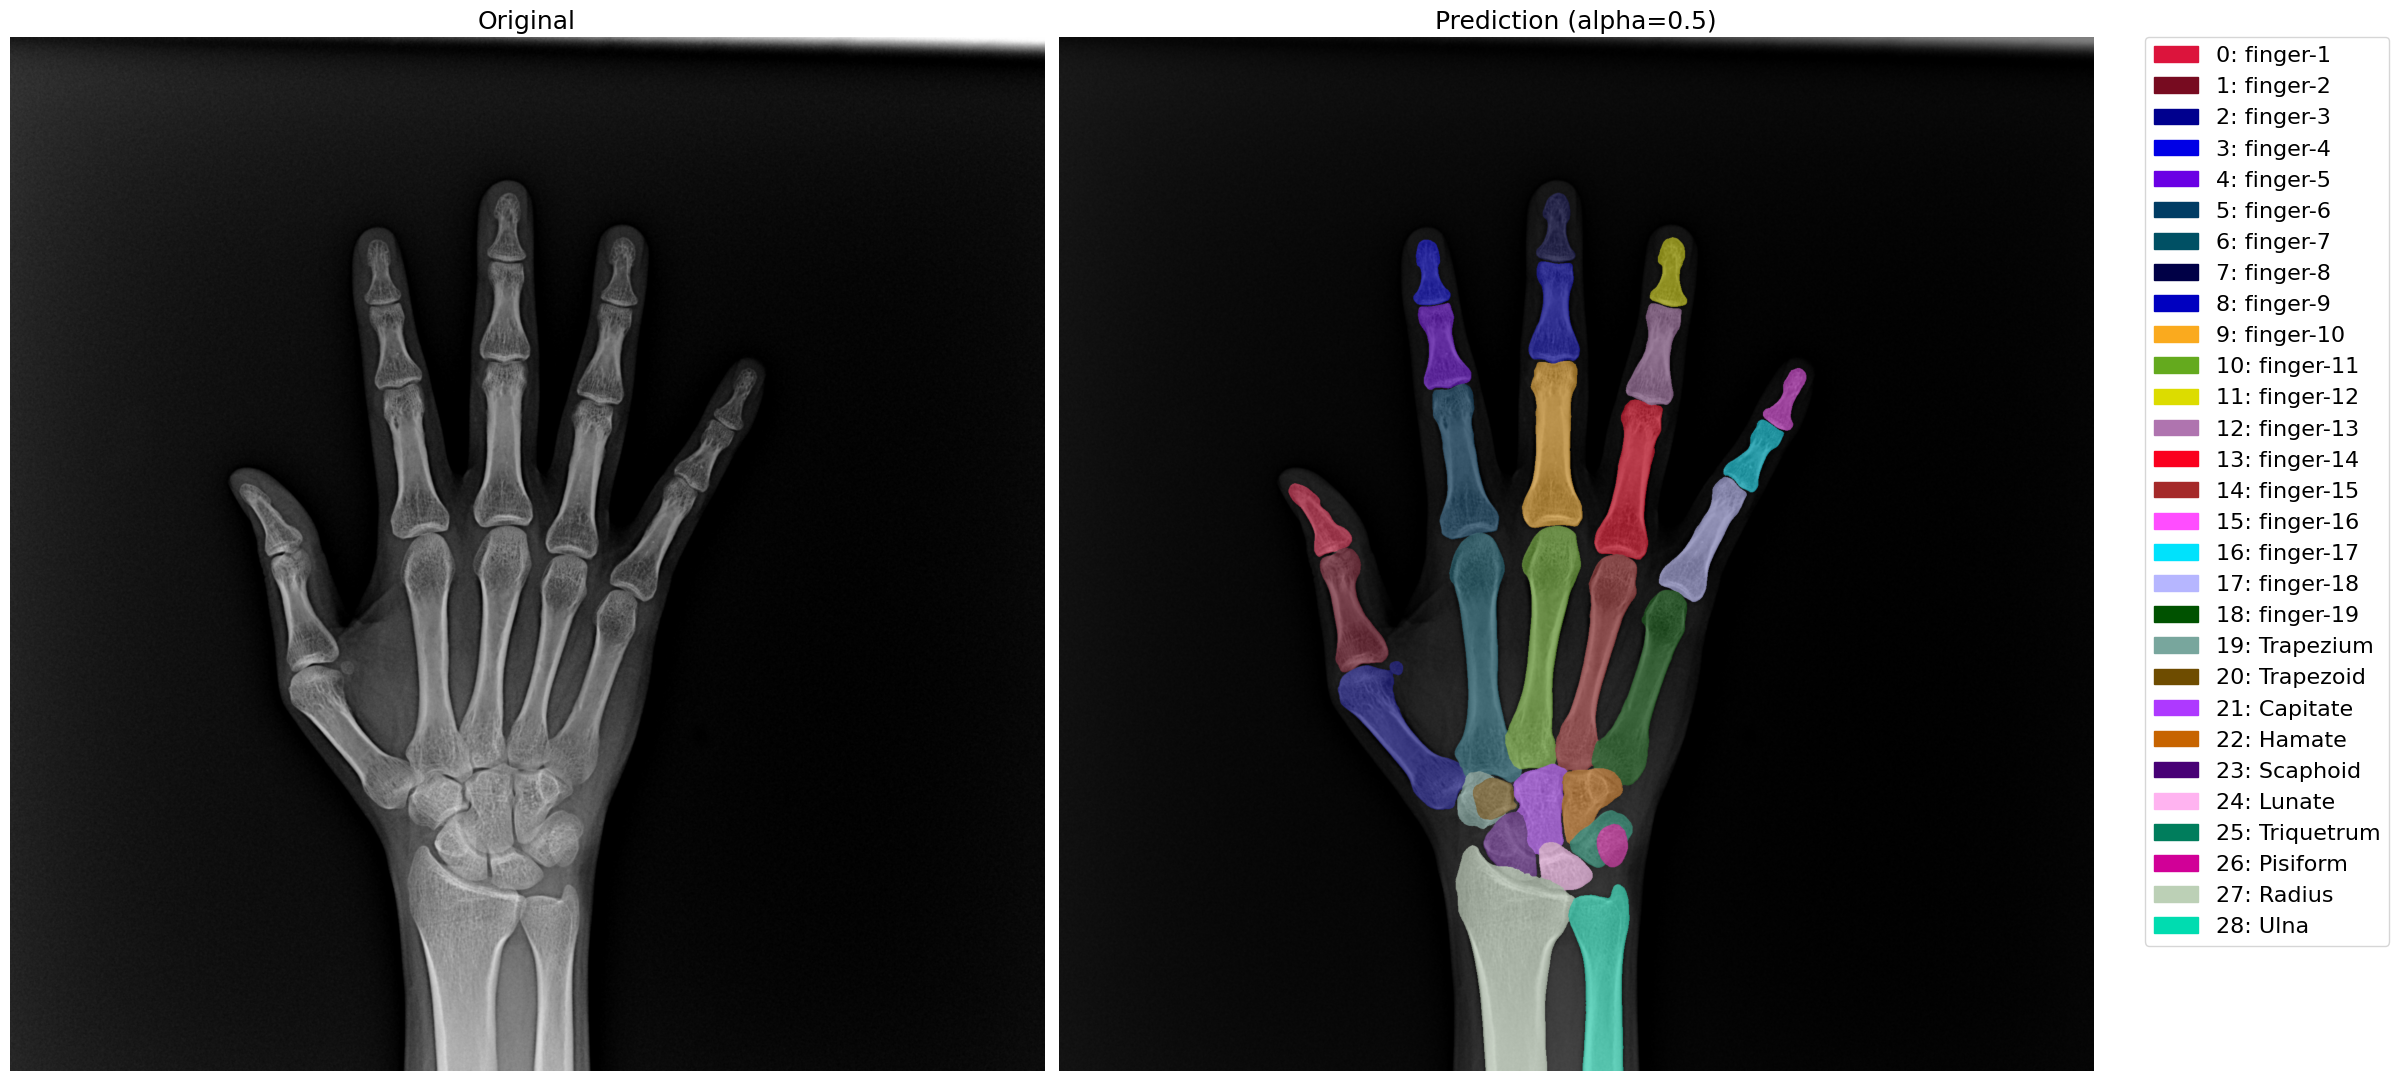

In [43]:
import matplotlib.patches as mpatches

alpha = 0.5

fig, ax = plt.subplots(1, 2, figsize=(24, 12))


ax[0].imshow(image)
ax[0].set_title("Original", fontsize=18)
ax[0].axis("off")


ax[1].imshow(image)                    
ax[1].imshow(label2rgb(preds), alpha=alpha)  
ax[1].set_title(f"Prediction (alpha={alpha})", fontsize=18)
ax[1].axis("off")


handles = []
for i, class_name in enumerate(CLASSES):
    color = np.array(PALETTE[i]) / 255.0
    patch = mpatches.Patch(color=color, label=f"{i}: {class_name}")
    handles.append(patch)

ax[1].legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=16,
)

plt.tight_layout()
plt.show()

# To CSV

In [44]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

image_name = [os.path.basename(f) for f in filename]
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})
df.head(30)
df.to_csv("output.csv", index=False)



# TTA


In [ ]:
import ttach as tta


def test_TTA(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()
    
    # Multi-scale + flip TTA
    transforms = tta.Compose(
        [
            tta.Scale(scales=[1.0, 1.25]),  # Multi-scale
            # tta.HorizontalFlip(),       
        ]
    )
    
    # Segmentation용 TTA Wrapper
    tta_model = tta.SegmentationTTAWrapper(
        model,
        transforms,
        merge_mode="mean"
    )

    rles = []
    filename_and_class = []
    
    with torch.no_grad():
        n_class = len(CLASSES)
        
        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()

            # TTA inference
            outputs = tta_model(images)  # [B, C, H', W']

            # Sigmoid + threshold
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()

            # RLE 인코딩
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
    
    return rles, filename_and_class

In [ ]:
rles, filename_and_class = test_TTA(model, test_loader)

# visualize output.csv


In [ ]:
def rle_decode(rle_str, shape):

    if isinstance(rle_str, float) and np.isnan(rle_str):

        return np.zeros(shape, dtype=np.uint8)

    s = list(map(int, rle_str.split()))
    starts = np.array(s[0::2]) - 1  
    lengths = np.array(s[1::2])
    ends = starts + lengths

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1

    return img.reshape(shape[0], shape[1]) 


def colorize_label_map(label_map, palette):
    """
    label_map: (H, W), 각 위치에 class index (0,1,2,...)
    palette: [[R, G, B], ...]
    """
    h, w = label_map.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for cls_idx, color in enumerate(palette, start=0):
        color_mask[label_map-1 == cls_idx] = color  
    return color_mask

In [ ]:
def visualize_from_csv(
    csv_path,
    image_dir,
    image_name,
    img_size=(2048, 2048),   # RLE 마스크가 인코딩된 사이즈
    alpha=0.5
):
    """
    csv_path: output.csv 경로
    image_dir: 원본 이미지들이 있는 디렉토리
    image_name: 시각화할 이미지 파일 이름 (예: "image1661319116107.png")
    img_size: (H, W) - RLE가 기준하고 있는 segmentation 사이즈
    alpha: overlay 비율
    """

    # CSV 로드
    df = pd.read_csv(csv_path)

    # 해당 image_name의 row만 추출
    df_img = df[df["image_name"] == image_name]
    if len(df_img) == 0:
        print(f"[WARN] {image_name} 에 해당하는 row가 CSV에 없습니다.")
        return

    # image_name -> 원본 이미지 경로
    image_path = os.path.join(image_dir, image_name)
    if not os.path.exists(image_path):
        print(f"[WARN] 원본 이미지가 없습니다: {image_path}")
        return

    # 원본 이미지 읽기 (시각화용)
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # segmentation mask와 동일한 크기로 맞추기
    if (image_rgb.shape[0], image_rgb.shape[1]) != img_size:
        image_vis = cv2.resize(image_rgb, (img_size[1], img_size[0]))
    else:
        image_vis = image_rgb

    # class name -> index 매핑
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(CLASSES)}

    # label map 초기화 (0 = background, 1~ = 각 클래스)
    label_map = np.zeros(img_size, dtype=np.int32)

    # 각 row마다 rle 디코딩해서 label_map에 쌓기
    for _, row in df_img.iterrows():
        cls_name = row["class"]
        rle_str = row["rle"]

        if cls_name not in class_to_idx:
            # CLASSES에 없는 클래스면 스킵
            print(f"[INFO] CLASSES에 없는 클래스: {cls_name} -> 스킵")
            continue

        cls_idx = class_to_idx[cls_name]

        mask = rle_decode(rle_str, img_size)  # (H, W), 0/1

        # 해당 클래스인 위치에 클래스 index 부여
        # 겹치는 영역이 있을 경우, 나중에 오는 클래스로 덮어씀
        label_map[mask == 1] = cls_idx+1

    # color mask 생성
    color_mask = colorize_label_map(label_map, PALETTE)

    # overlay
    overlay = (image_vis * (1 - alpha) + color_mask * alpha).astype(np.uint8)

    # 시각화
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay from CSV", fontsize=18)
    ax[1].axis("off")

    # legend 생성
    handles = []
    for i, class_name in enumerate(CLASSES):
        color = np.array(PALETTE[i]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{i}: {class_name}"))

    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=14,
    )

    plt.tight_layout()
    plt.show()

In [ ]:
csv_path = "./output.csv"
image_dir = "../data/test_merged"  # 실제 이미지 폴더 경로로 수정
image_name = "image1661319116107.png"

visualize_from_csv(
    csv_path=csv_path,
    image_dir=image_dir,
    image_name=image_name,
    img_size=(2048, 2048),   # CSV RLE가 기준한 크기
    alpha=0.5
)

# Test one image


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [ ]:
def test_one_image_visual(model,image_root,thr=0.5,transforms=None, out_size=(2048, 2048)):
    
    image = cv2.imread(image_root)
    model = model.cuda()
    model.eval()
    
    rles = []
    filename_and_class = []

    image = cv2.imread(image_root)
    image = image / 255.
    
    if transforms is not None:
        inputs = {"image": image}
        result = transforms(**inputs)
        image = result["image"]

    image = image.transpose(2, 0, 1)  
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.unsqueeze(0).cuda()
    image_vis = cv2.cvtColor(cv2.imread(image_root), cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        outputs = model(image_tensor)
        outputs = F.interpolate(outputs, size=out_size, mode="bilinear", align_corners=False)
        outputs = torch.sigmoid(outputs)
        preds = (outputs > thr).cpu().numpy()[0]

    color_mask = label2rgb(preds)
    alpha = 0.5
    overlay = (image_vis * (1 - alpha) + color_mask * alpha).astype(np.uint8)
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")
    
    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay (thr={thr})", fontsize=18)
    ax[1].axis("off")
    
    handles = []
    for i, class_name in enumerate(CLASSES):
        color = np.array(PALETTE[i]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{i}: {class_name}"))
    
    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=14,
    )
    
    plt.tight_layout()
    plt.show()




In [ ]:
image_root="../data/train_merged/ID283_image1664155969209.png"
# image_root=os.path.join(image_root,os.listdir(image_root)[0])
# print(image_root)
test_one_image_visual(model,
                      image_root,
                      transforms=test_tf,
                      thr=0.5, out_size=(2048, 2048))

# Visualize each class

In [ ]:
def test_one_image_visual_with_roi(
    model,
    image_root,
    thr=0.5,
    transforms=None,
    out_size=(2048, 2048),
    roi_classes=None,        
    margin=40,
    max_cols=4
):
    """
    - 기존 test_one_image_visual 방식 그대로 사용
    - roi_classes:
        * bbox 계산
        * 클래스별 확률 heatmap 시각화
    """

    assert roi_classes is not None, "roi_classes는 반드시 지정해야 해"

    model = model.cuda()
    model.eval()

    image = cv2.imread(image_root)
    image = image / 255.0

    if transforms is not None:
        inputs = {"image": image}
        result = transforms(**inputs)
        image = result["image"]

    image = image.transpose(2, 0, 1)
    image_tensor = torch.from_numpy(image).float().unsqueeze(0).cuda()

    image_vis = cv2.cvtColor(cv2.imread(image_root), cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        outputs = model(image_tensor)
        outputs = F.interpolate(outputs, size=out_size, mode="bilinear", align_corners=False)
        outputs = torch.sigmoid(outputs)                 
        probs = outputs.cpu().numpy()[0]                 
        preds = (probs > thr).astype(np.uint8) 

    roi_indices = [CLASSES.index(name) for name in roi_classes]
    

    preds_roi = np.zeros_like(preds, dtype=np.uint8)
    preds_roi[roi_indices] = preds[roi_indices]
    
    color_mask = label2rgb(preds_roi)
    
    alpha = 0.5
    overlay = (
        image_vis.astype(np.float32) * (1 - alpha)
        + color_mask.astype(np.float32) * alpha
    ).astype(np.uint8)


    roi_indices = [CLASSES.index(name) for name in roi_classes]


    union = np.zeros_like(preds[0], dtype=bool)
    for idx in roi_indices:
        union |= (preds[idx] == 1)

    ys, xs = np.where(union)
    bbox = None
    if len(xs) > 0 and len(ys) > 0:
        y1, y2 = ys.min(), ys.max()
        x1, x2 = xs.min(), xs.max()

        H, W = union.shape
        y1 = max(0, y1 - margin)
        x1 = max(0, x1 - margin)
        y2 = min(H - 1, y2 + margin)
        x2 = min(W - 1, x2 + margin)

        bbox = (x1, y1, x2, y2)

    # =========================
    # 4) Overlay + bbox 시각화
    # =========================
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay (thr={thr})", fontsize=18)
    ax[1].axis("off")

    if bbox is not None:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle(
            (x1, y1),
            (x2 - x1 + 1),
            (y2 - y1 + 1),
            fill=False,
            linewidth=3
        )
        ax[1].add_patch(rect)

    handles = []
    for name in roi_classes:
        idx = CLASSES.index(name)
        color = np.array(PALETTE[idx]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{idx}: {name}"))

    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=12,
    )

    plt.tight_layout()
    plt.savefig("inference.png")
    plt.show()

    # =========================
    # 5) 클래스별 확률 Heatmap (ROI crop)
    # =========================
    if bbox is None:
        print("[warn] ROI bbox를 찾지 못해 클래스별 시각화를 건너뜀")
        return preds

    x1, y1, x2, y2 = bbox
    preds_crop = preds[:, y1:y2+1, x1:x2+1]

    K = len(roi_indices)
    cols = min(max_cols, K)
    rows = int(np.ceil(K / cols))

    fig2, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for k, cls_idx in enumerate(roi_indices):
        r, c = divmod(k, cols)
        hm = preds_crop[cls_idx]

        im = axes[r, c].imshow(hm, vmin=0.0, vmax=1.0)
        axes[r, c].set_title(
            f"{cls_idx}: {CLASSES[cls_idx]}\nmean={hm.mean():.3f}",
            fontsize=12
        )
        axes[r, c].axis("off")
        plt.colorbar(im, ax=axes[r, c], fraction=0.046, pad=0.04)

    for k in range(K, rows * cols):
        r, c = divmod(k, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    
    plt.show()

    return preds


In [ ]:
roi_classes = ["Trapezium", "Trapezoid", "Capitate", "Hamate",
               "Scaphoid", "Lunate", "Triquetrum", "Pisiform"]

# ROI bbox도 이걸로 잡고, 시각화도 이걸로 하고 싶으면 vis_class_names=None

preds = test_one_image_visual_with_roi(
    model,
    image_root,
    thr=0.5,
    transforms=test_tf,
    out_size=(2048, 2048),
    roi_classes=roi_classes
)

In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def _bbox_from_union_mask(label_chw, class_indices, margin=40):
    union = np.zeros_like(label_chw[0], dtype=bool)
    for idx in class_indices:
        union |= (label_chw[idx] == 1)

    ys, xs = np.where(union)
    if len(xs) == 0 or len(ys) == 0:
        return None

    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    H, W = union.shape
    y1 = max(0, y1 - margin)
    x1 = max(0, x1 - margin)
    y2 = min(H - 1, y2 + margin)
    x2 = min(W - 1, x2 + margin)

    if x2 <= x1 or y2 <= y1:
        return None
    return (x1, y1, x2, y2)


def load_gt_from_image_and_label(image_root, label_root):
    """
    return:
      image_rgb: (H,W,3) uint8
      label_chw: (C,H,W) uint8
    """
    image_bgr = cv2.imread(image_root)
    if image_bgr is None:
        raise FileNotFoundError(image_root)

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    H, W = image_rgb.shape[:2]

    label_hwc = np.zeros((H, W, len(CLASSES)), dtype=np.uint8)

    with open(label_root, "r") as f:
        data = json.load(f)

    for ann in data["annotations"]:
        cname = ann["label"]
        if cname not in CLASS2IND:
            continue

        idx = CLASS2IND[cname]
        pts = np.array(ann["points"], dtype=np.int32)

        m = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(m, [pts], 1)
        label_hwc[..., idx] = m

    return image_rgb, label_hwc.transpose(2, 0, 1)


def visualize_gt_roi_only(
    image_root,
    label_root,
    roi_classes,
    margin=40,
    max_cols=4,
    alpha=0.5
):
    image_vis, label_chw = load_gt_from_image_and_label(image_root, label_root)

    roi_indices = [CLASSES.index(n) for n in roi_classes]

    # roi_classes만 남기기
    label_roi = np.zeros_like(label_chw, dtype=np.uint8)
    label_roi[roi_indices] = label_chw[roi_indices]

    # =========================
    # Overlay + bbox
    # =========================
    color_mask = label2rgb(label_roi)   # 네가 정의한 label2rgb
    overlay = (image_vis.astype(np.float32) * (1 - alpha)
               + color_mask.astype(np.float32) * alpha).astype(np.uint8)

    bbox = _bbox_from_union_mask(label_roi, roi_indices, margin=margin)

    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title("GT Overlay (roi_classes only)", fontsize=18)
    ax[1].axis("off")

    if bbox is not None:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle((x1, y1), x2-x1+1, y2-y1+1,
                              fill=False, linewidth=3)
        ax[1].add_patch(rect)
    else:
        print("[warn] ROI bbox를 찾지 못함")

    handles = []
    for name in roi_classes:
        idx = CLASSES.index(name)
        handles.append(
            mpatches.Patch(color=np.array(PALETTE[idx]) / 255.0,
                            label=f"{idx}: {name}")
        )

    ax[1].legend(handles=handles,
                 bbox_to_anchor=(1.05, 1),
                 loc="upper left",
                 fontsize=12)

    plt.tight_layout()
    plt.show()

    # =========================
    # bbox crop + 클래스별 시각화 (네 블록 그대로)
    # =========================
    if bbox is None:
        print("[warn] ROI bbox를 찾지 못해 클래스별 시각화를 건너뜀")
        return

    x1, y1, x2, y2 = bbox
    label_crop = label_roi[:, y1:y2+1, x1:x2+1]

    K = len(roi_indices)
    cols = min(max_cols, K)
    rows = int(np.ceil(K / cols))

    fig2, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for k, cls_idx in enumerate(roi_indices):
        r, c = divmod(k, cols)
        hm = label_crop[cls_idx].astype(np.float32)

        im = axes[r, c].imshow(hm, vmin=0.0, vmax=1.0)
        axes[r, c].set_title(
            f"{cls_idx}: {CLASSES[cls_idx]}\nmean={hm.mean():.3f}",
            fontsize=12
        )
        axes[r, c].axis("off")
        plt.colorbar(im, ax=axes[r, c], fraction=0.046, pad=0.04)

    for k in range(K, rows * cols):
        r, c = divmod(k, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
visualize_gt_roi_only(
    image_root="../data/train_merged/ID283_image1664155969209.png",
    label_root="../data/train_merged/ID283_image1664155969209.json",
    roi_classes=roi_classes,
    margin=40,
    max_cols=4
)